In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from copy import deepcopy
%matplotlib inline
#%matplotlib qt

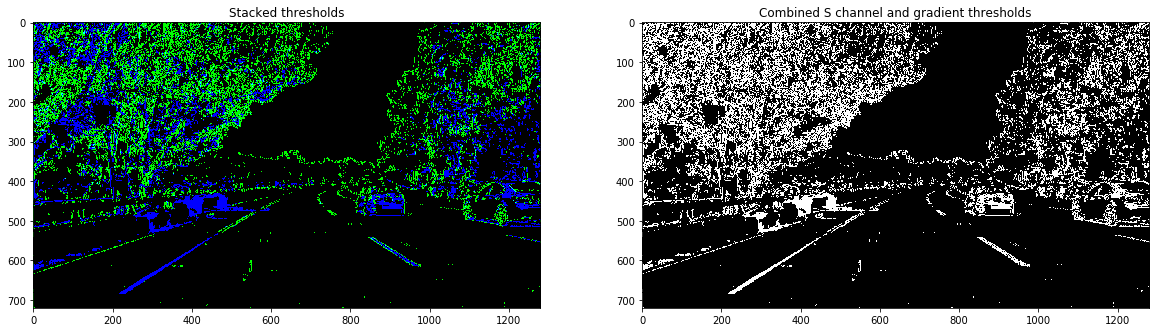

In [2]:
img  = mpimg.imread('./test_images/test5.jpg')
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 185
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

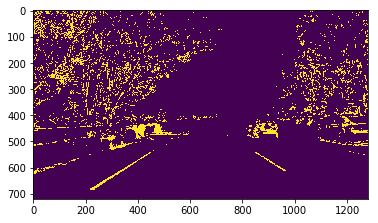

In [3]:
plt.imshow(s_binary)

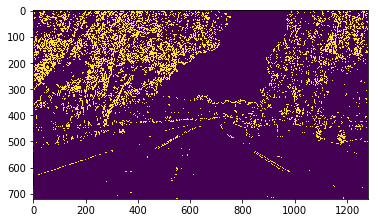

In [4]:
plt.imshow(sxbinary)

In [21]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255) ):
    
    imgcopy = np.copy(img)    
    
    assert orient== 'x' or orient=='y'    
    sobel = None
    
    if orient == 'x':
        sobel = cv2.Sobel(imgcopy, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(imgcopy, cv2.CV_64F, 0, 1)
    
    #without the np.absolute gets less noise
    abs_sobel = sobel
    #abs_sobel = np.absolute(sobel)
    
    #convert to 8-bit 0..255 image
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    #numpy zeros_like --> Returns an array of zeros with the same shape and type as a given array.
    thresh_min = thresh[0]
    thresh_max = thresh[1]    
    
    #new image array with zeros
    sxbinary = np.zeros_like(scaled_sobel)
    
    #make anything with the inputted thresholds 1
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary

In [5]:
def unwarp(img):
    
    img2 = deepcopy(img)
    
    img_size = (img2.shape[1], img2.shape[0])
    
    corners = [[[595,450]],[[200,720]],[[1150,720]],[[695,450]]]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([[250,0], [250,700],[960,700], [960,0]])        
    M = cv2.getPerspectiveTransform(src,dst)
    
    unwarped = cv2.warpPerspective(img2, M, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped

def channelImageMaker(img_chann, tmin,tmax):
    '''
    takes in a single channel of an image
    output: a blue (RGB) thresholded
    '''
    
    assert len(img_chann.shape) == 2, "Check the inputted image shape; insert a channel of an image"
    
    img_channel = np.copy(img_chann)
    binary = np.zeros_like(img_channel)
    binary[(img_chann >= tmin) & (img_chann <= tmax)] = 1

    spacer = np.zeros_like(img_channel)
    binary = np.dstack((spacer,binary, spacer) ) * 255
    
    return binary

def printLotsOfThresholds(img_1, thresholds, number_of_columns,FIGSIZE = (12,12)):
    
    fig = plt.figure(figsize=FIGSIZE)
    col = 0    
    
    for i,t in enumerate(thresholds):
        
        col += 1
        
        if col == number_of_columns + 1:
            fig = plt.figure(figsize=FIGSIZE)
            col = 1
        
        #img_try = abs_sobel_thresh(img_1, 'x', (t[0], t[1]))
        img_try = channelImageMaker(img_1, t[0], t[1])
        img_try = unwarp(img_try)
        
        fig.add_subplot(1,number_of_columns,col)     
        plt.imshow(img_try,cmap='gray')
        plt.axis('off')
        title = "sobel-x:{0}, {1} \n".format(
        str(t[0]), str(t[1]) )        
        plt.title(title, wrap=True)        
        
param_search_image = mpimg.imread('./test_images/test5.jpg')
param_search_image = cv2.cvtColor(param_search_image, cv2.COLOR_RGB2GRAY)

attempt = unwarp(param_search_image)
#attempt = cv2.blur(attempt,(5,5))


Goal:
    check:
        HLS
        HSV
        RGB
     get the best parameters to see in shadows

2 (720, 1280)
3 (720, 1280, 3)


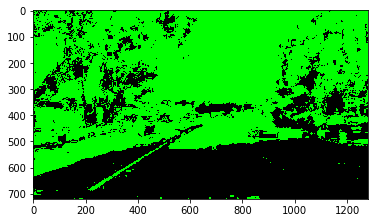

In [6]:
img  = mpimg.imread('./test_images/test5.jpg')
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,0]
# Threshold color channel
s_thresh_min = 185
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

spacer = np.zeros_like(s_channel)
s_binary = np.dstack((spacer,spacer,s_binary) )
print(len(s_channel.shape), s_channel.shape)


thing = channelImageMaker(s_channel,20,235)
print(len(thing.shape), thing.shape)
plt.imshow(thing)

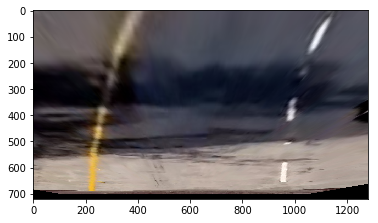

In [7]:
plt.imshow(unwarp(img))

## H in HLS

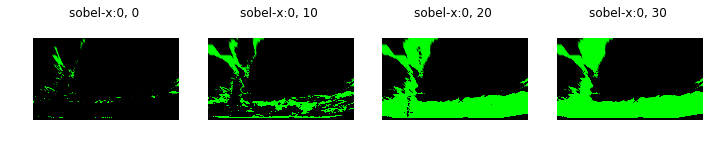

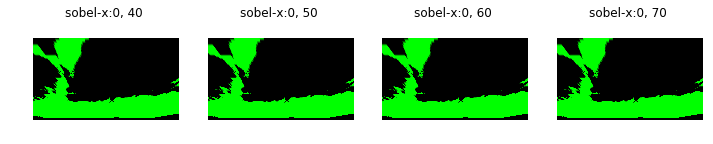

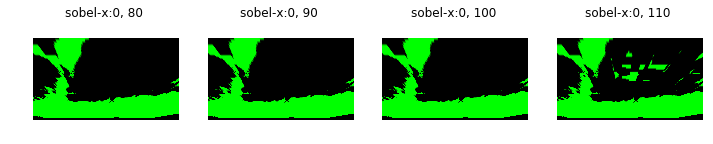

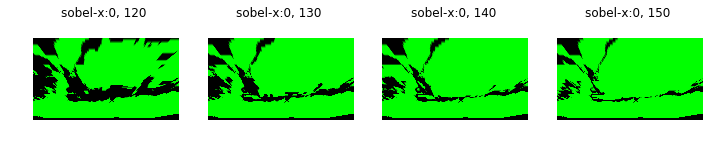

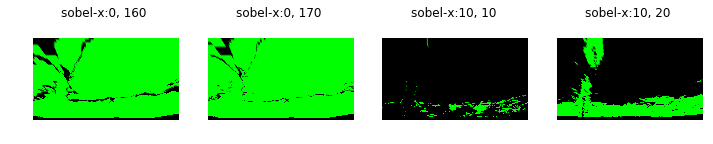

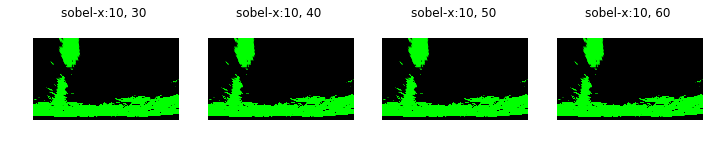

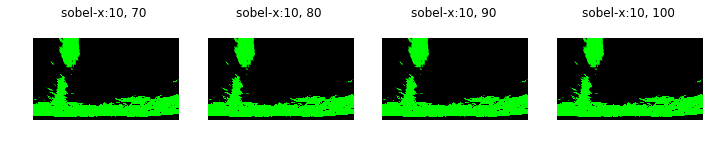

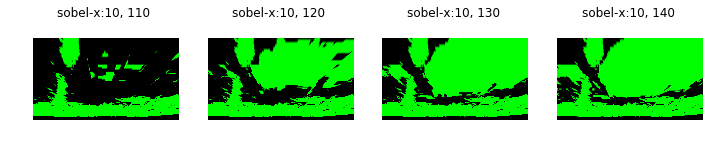

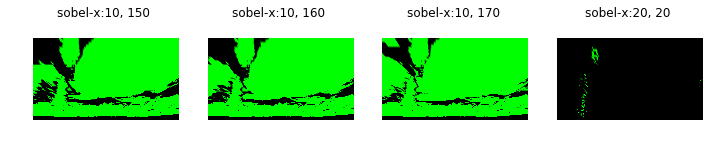

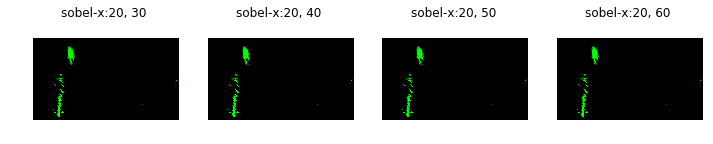

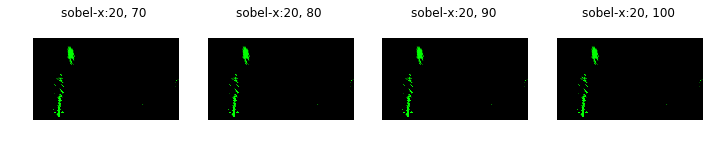

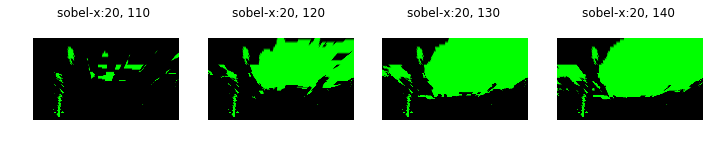

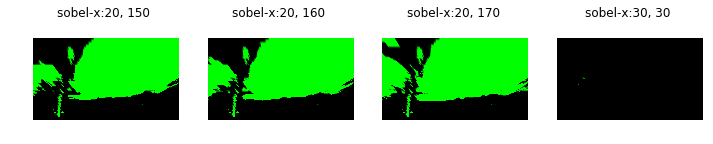

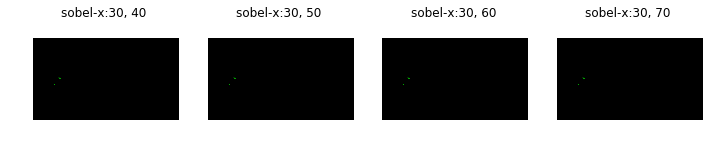

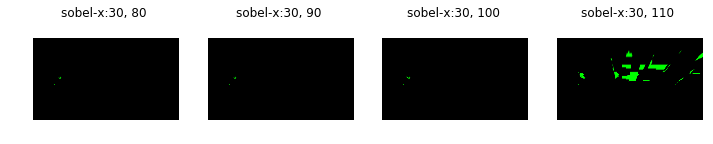

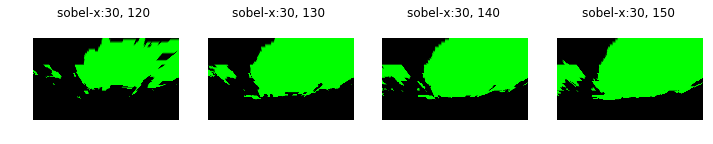

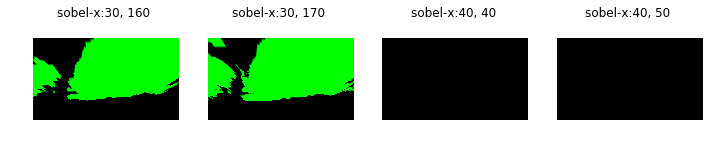

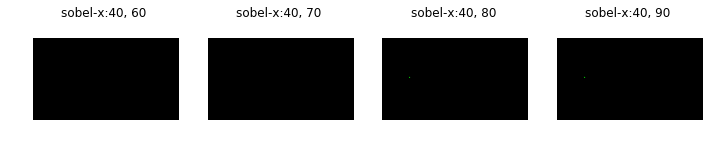

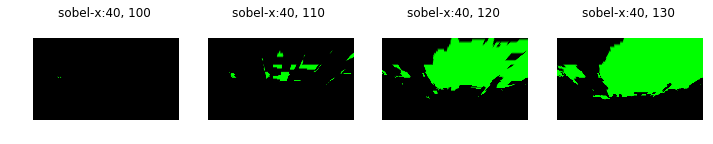

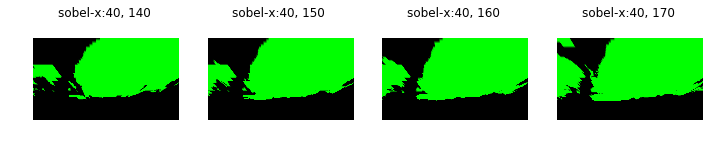

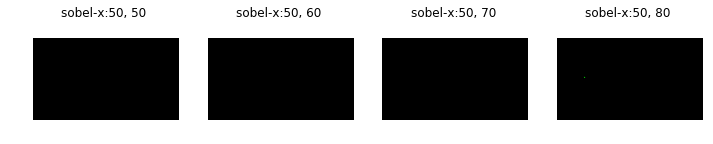

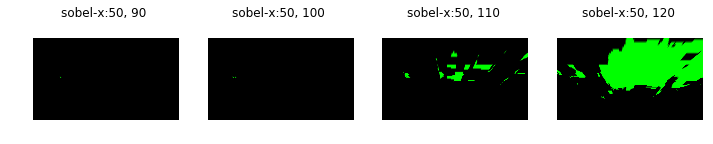

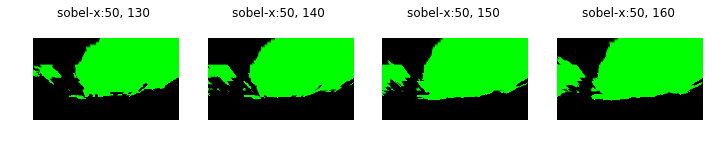

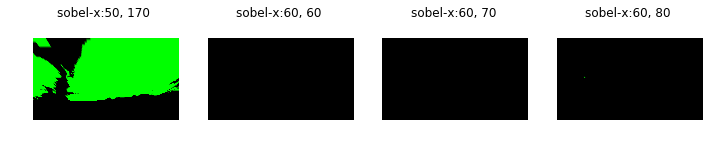

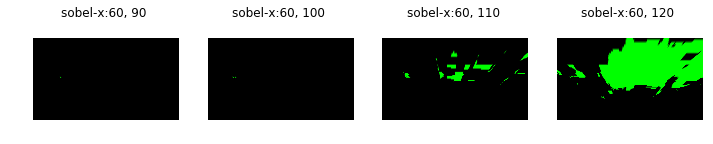

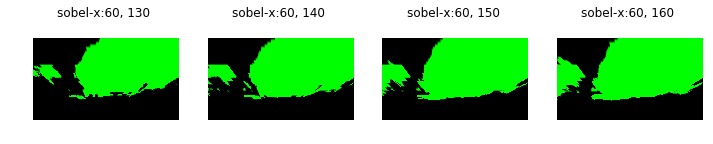

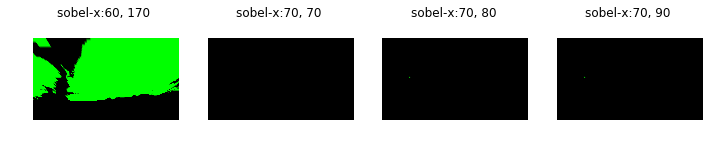

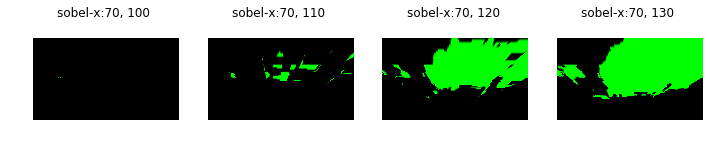

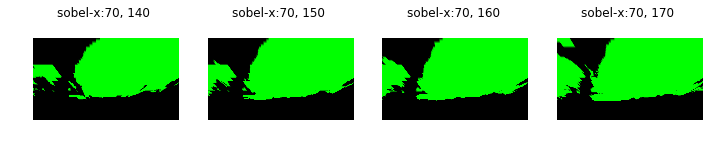

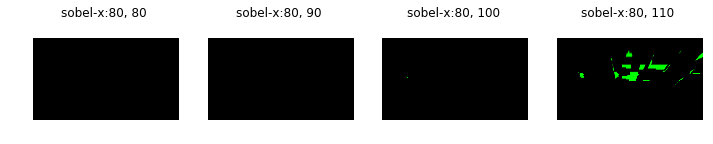

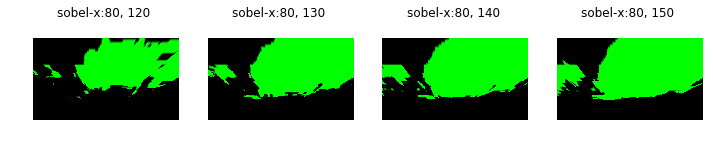

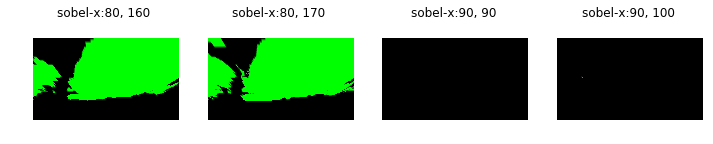

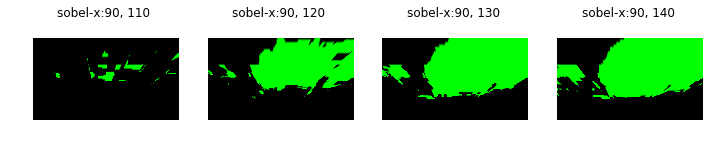

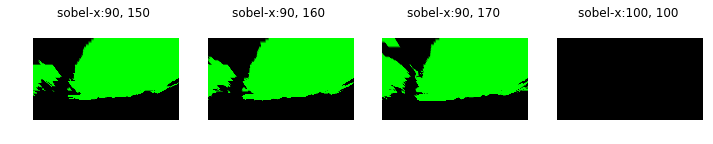

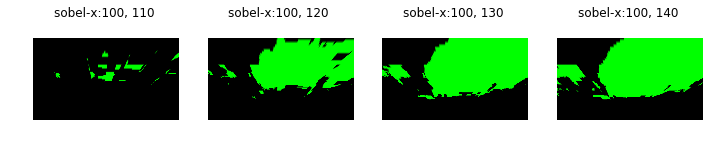

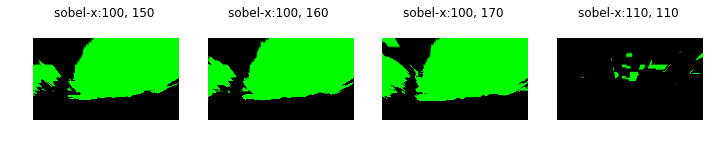

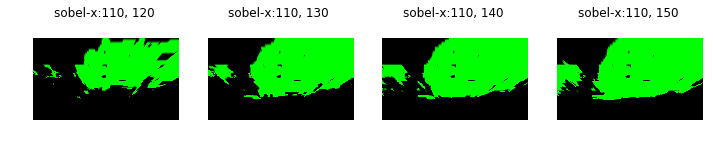

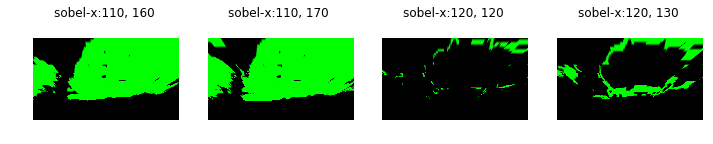

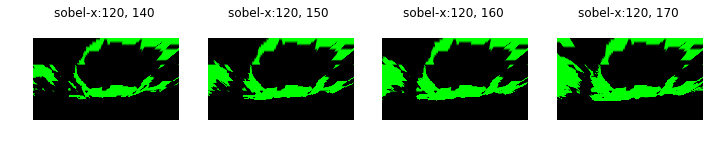

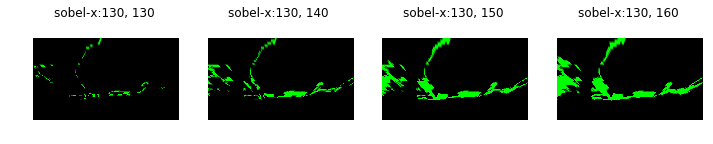

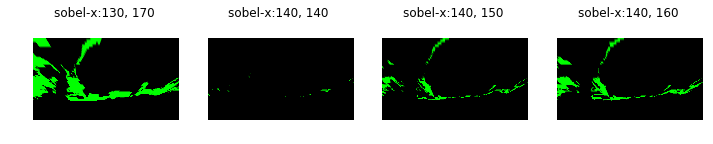

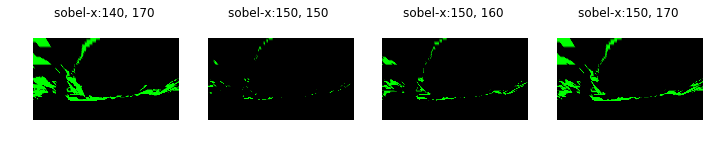

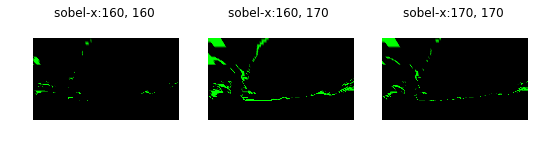

In [8]:
#printLotsOfThresholds(img_1, thresholds, number_of_columns,FIGSIZE = (12,12))
thresholds= []
for i in range(0,179,10):
    for j in range(0,179,10):
        if i>j:
            continue
        thresholds.append((i,j))
        
img  = mpimg.imread('./test_images/test5.jpg')
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]

printLotsOfThresholds(H, thresholds, 4,FIGSIZE = (12,12))

## L in HLS

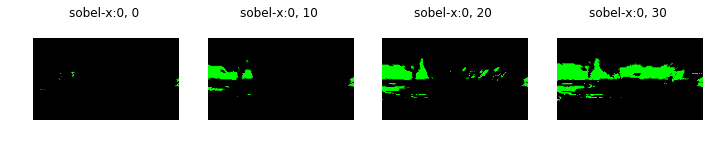

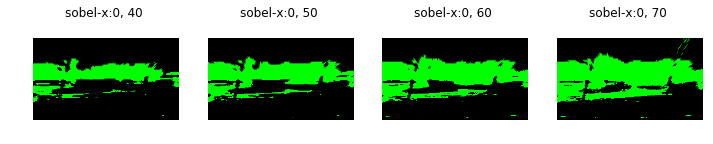

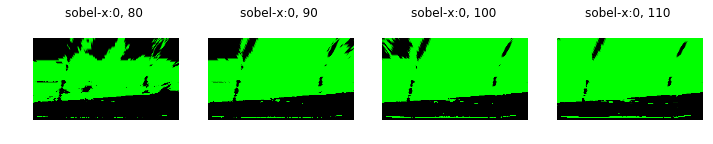

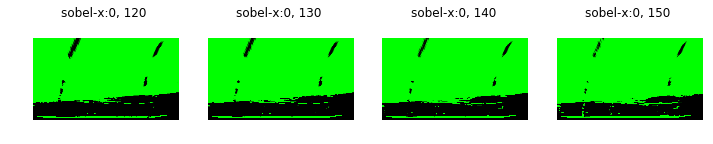

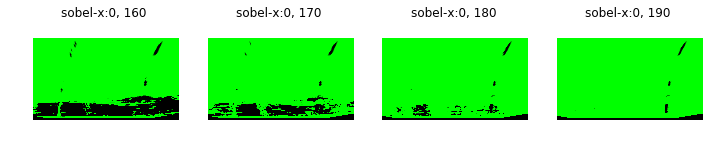

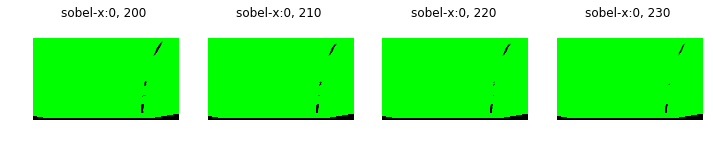

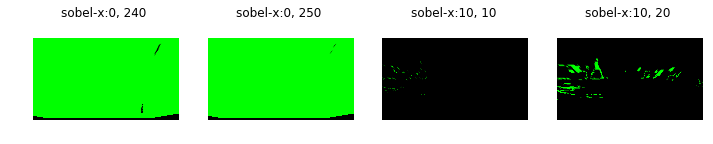

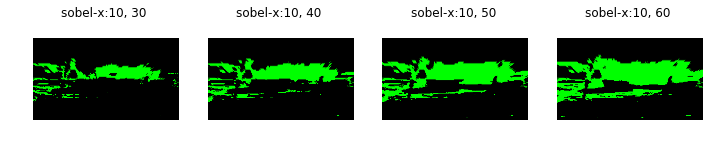

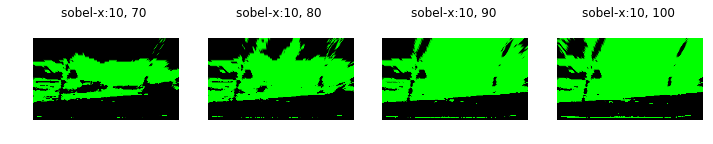

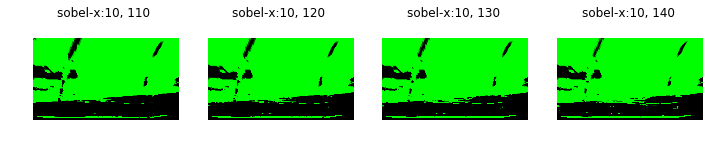

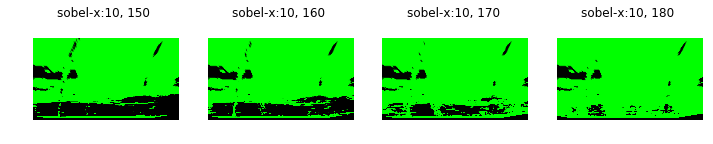

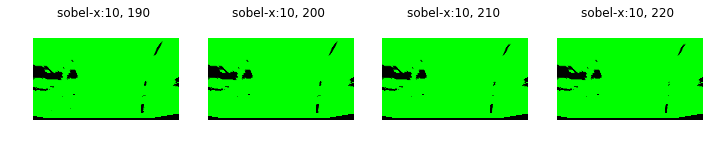

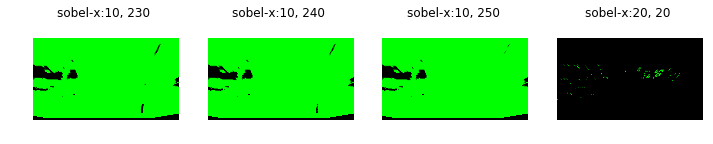

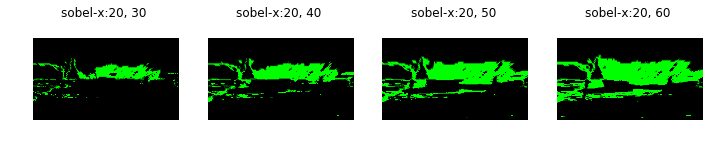

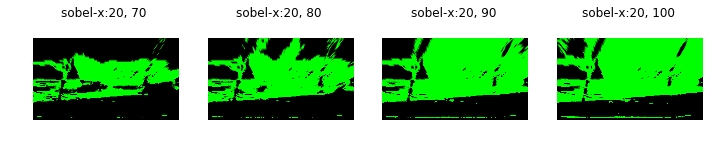

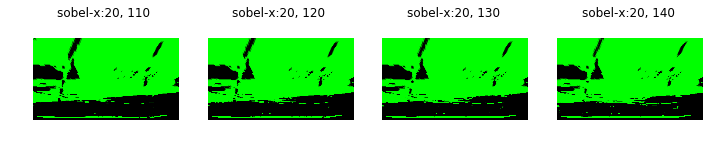

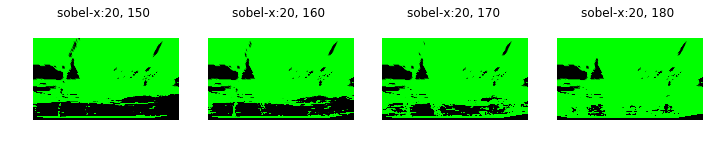

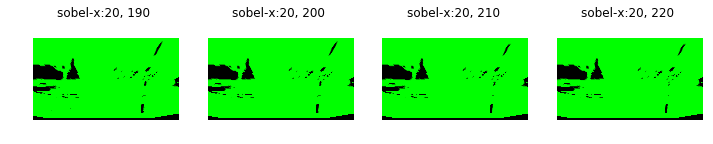

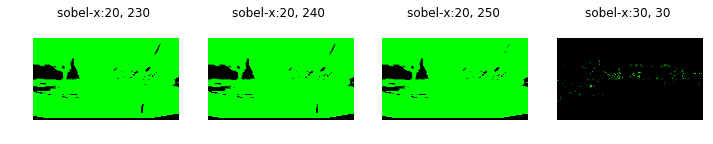

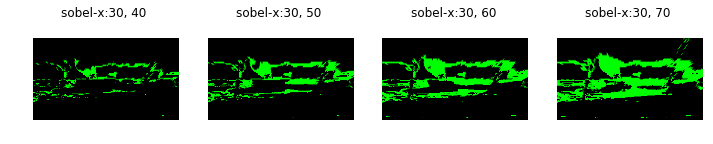

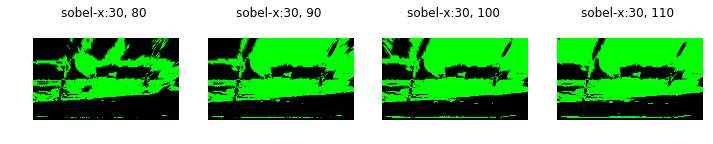

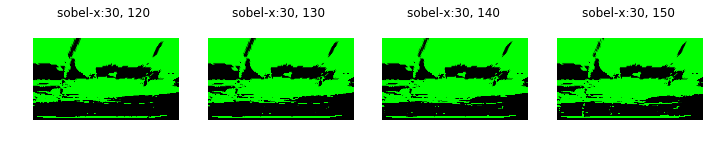

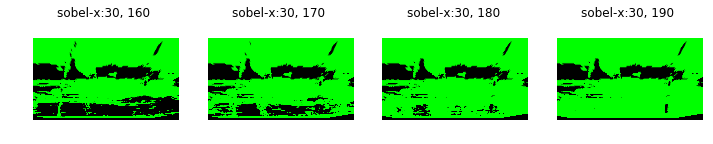

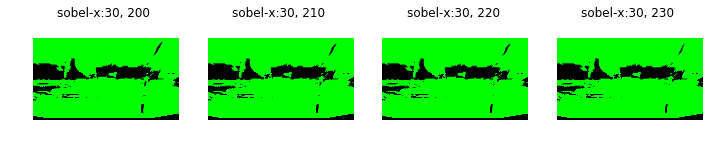

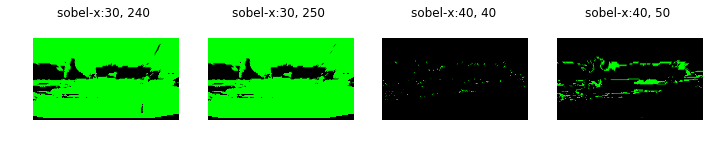

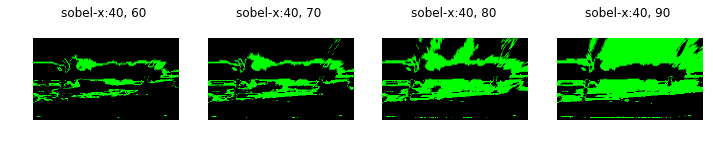

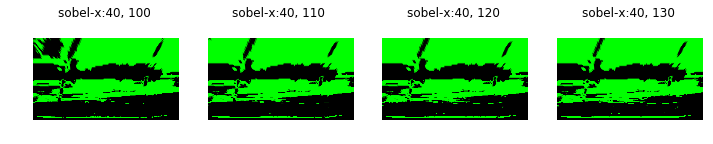

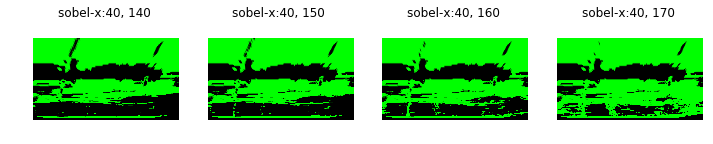

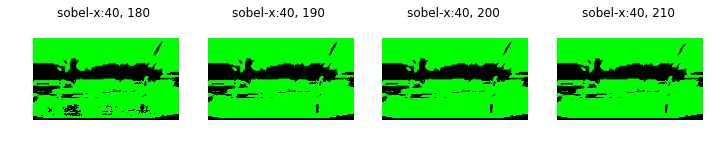

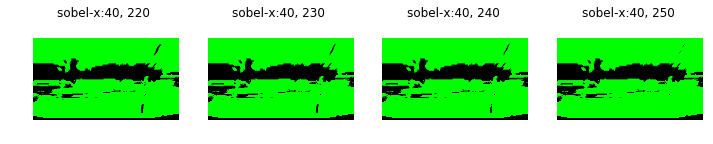

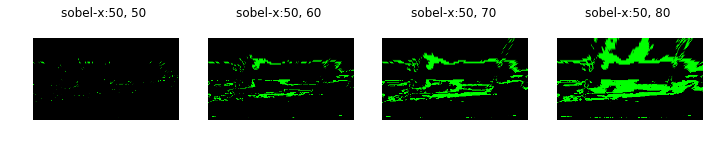

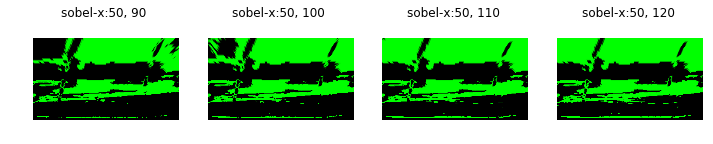

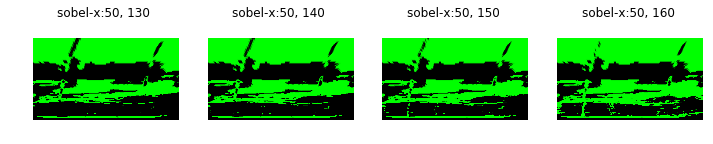

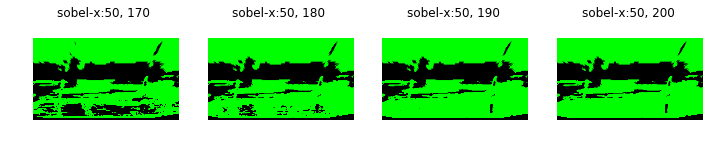

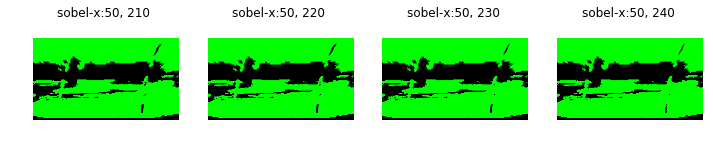

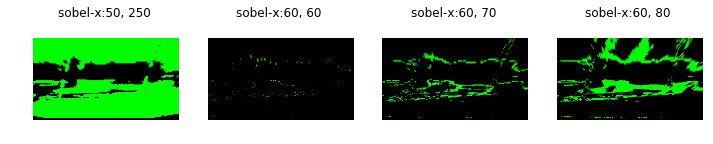

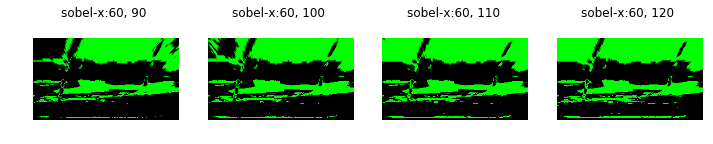

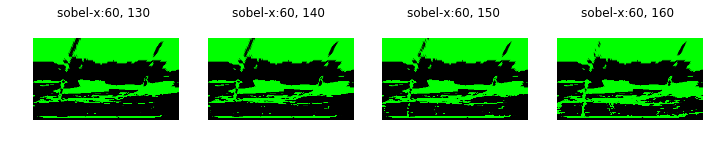

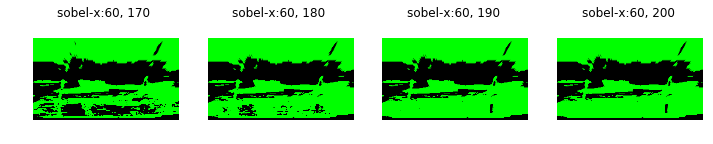

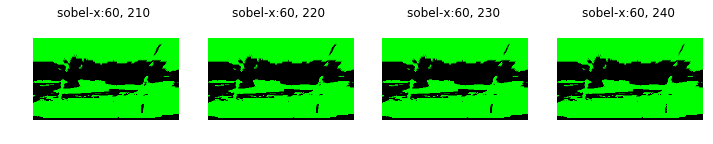

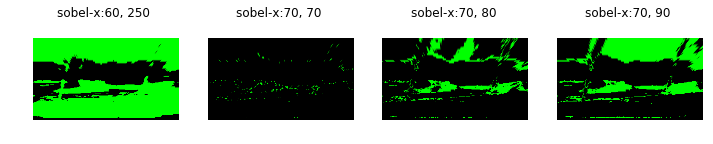

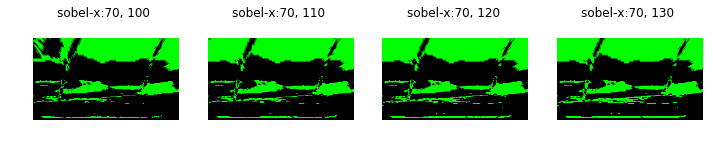

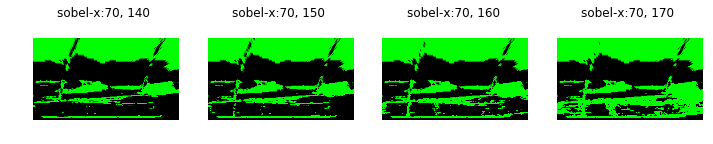

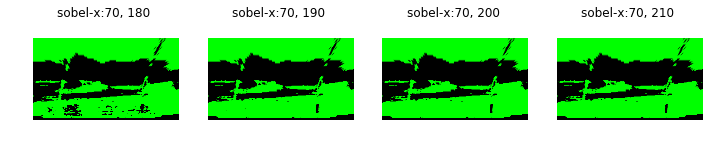

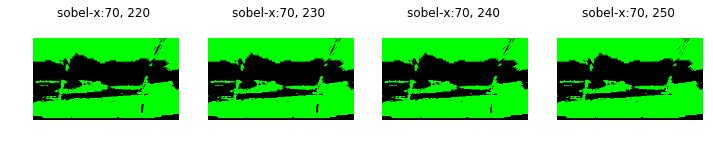

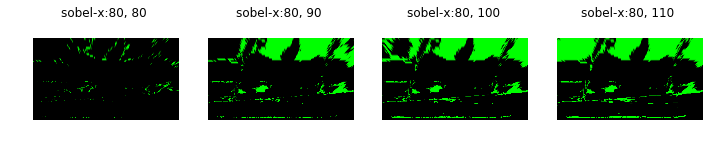

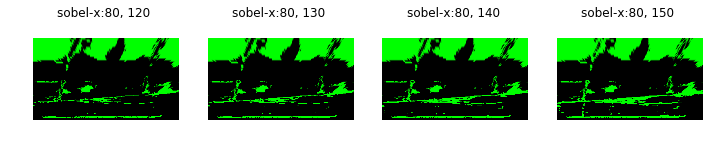

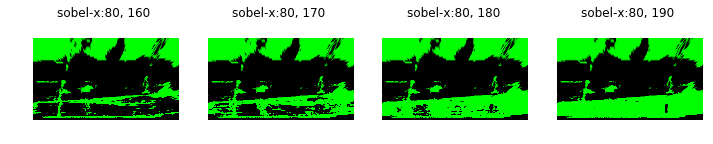

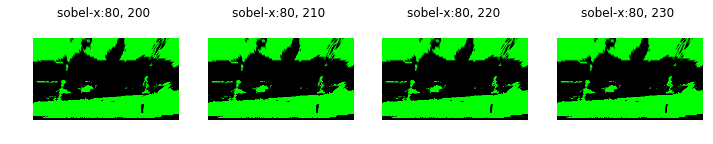

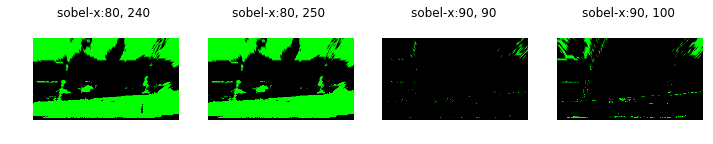

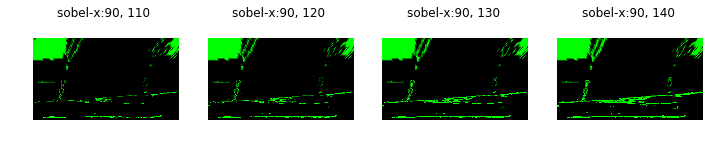

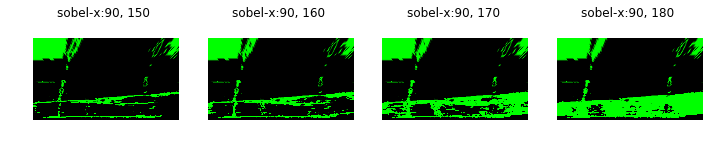

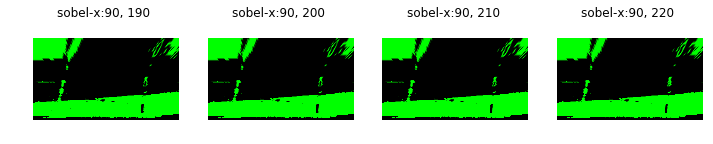

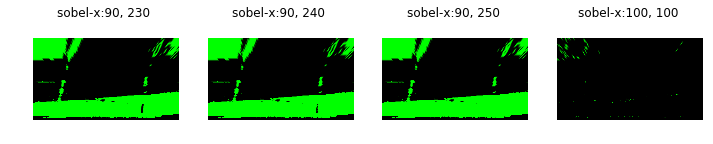

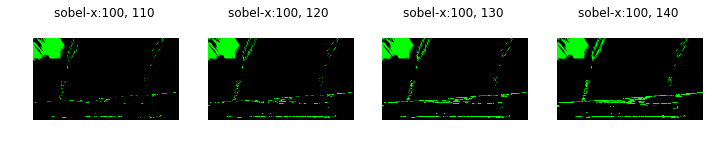

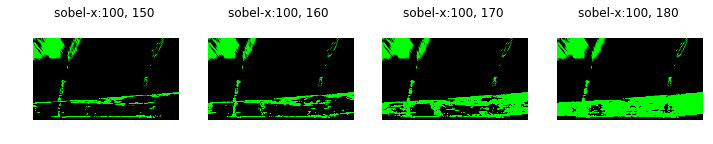

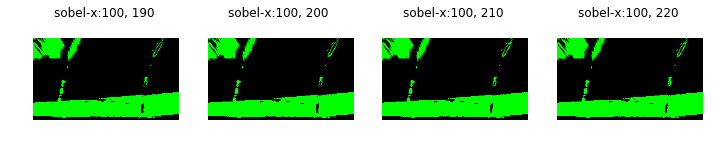

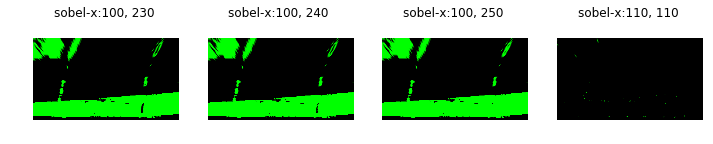

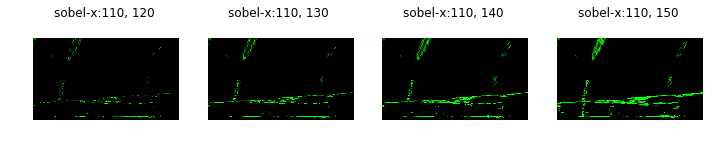

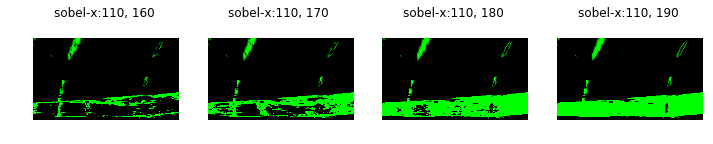

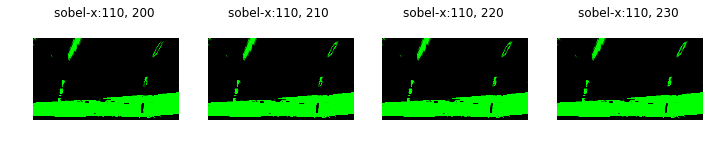

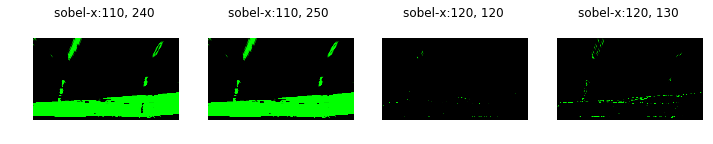

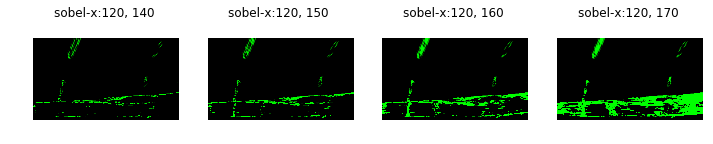

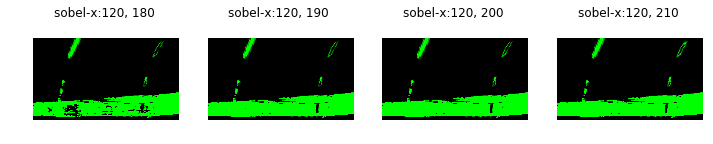

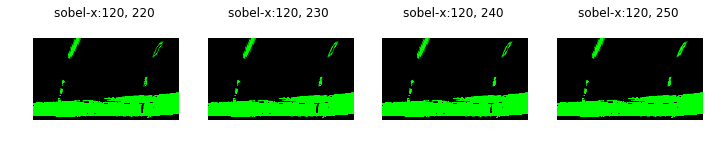

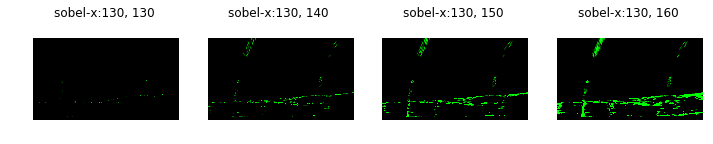

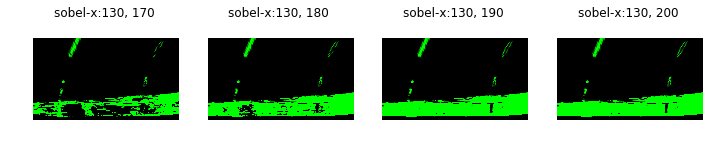

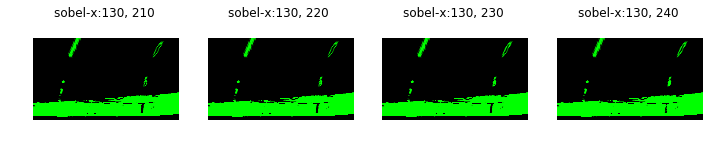

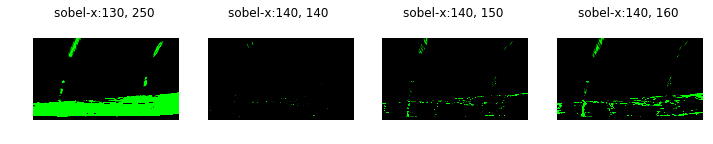

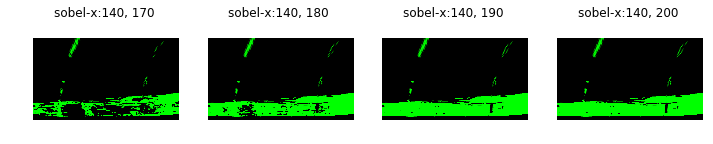

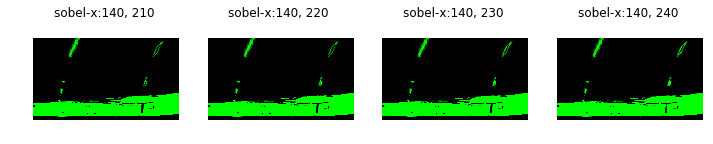

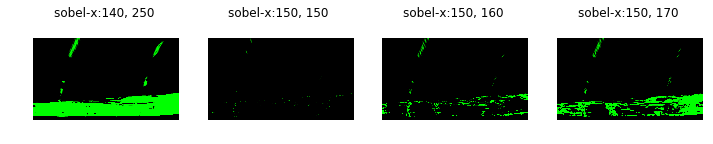

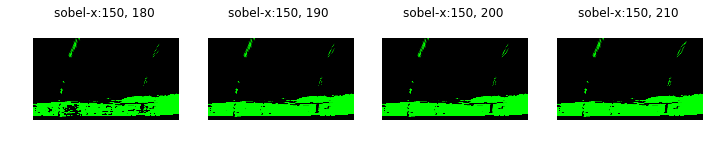

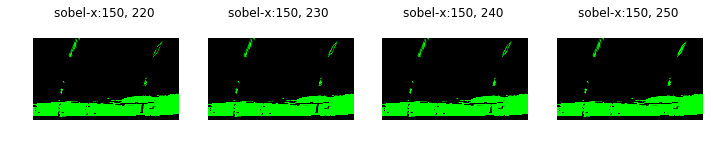

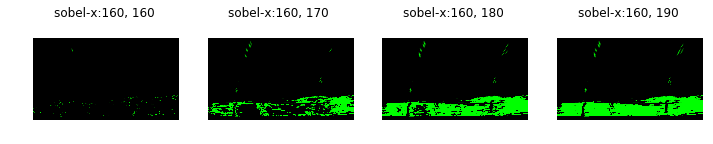

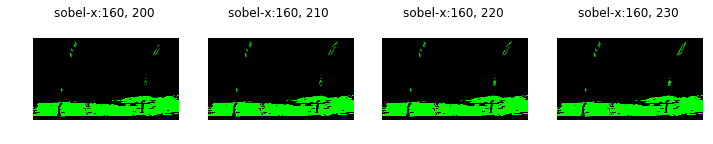

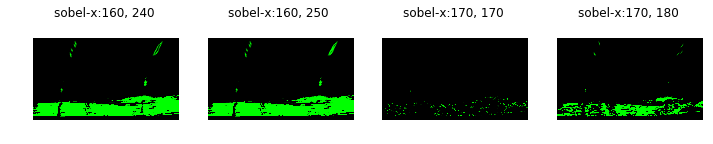

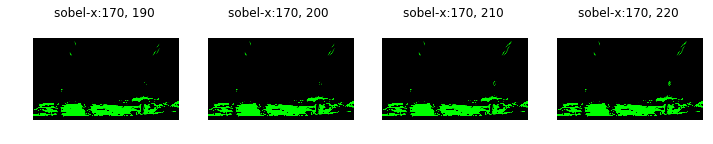

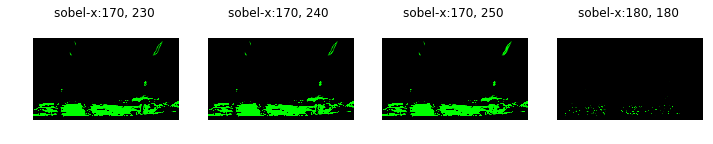

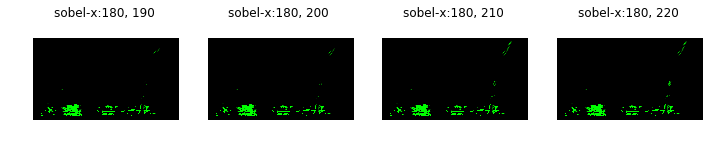

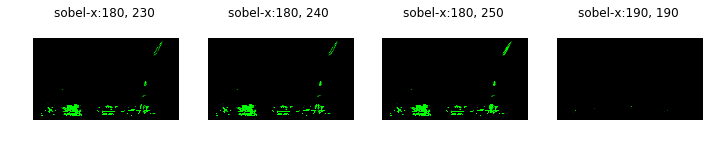

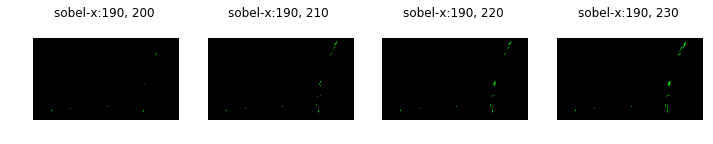

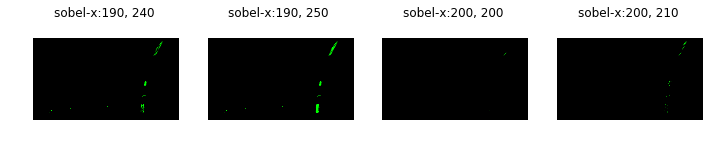

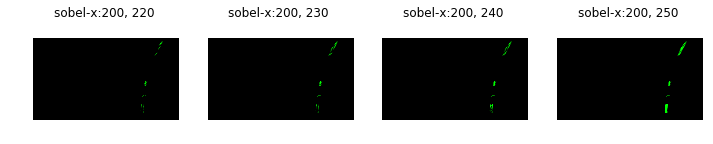

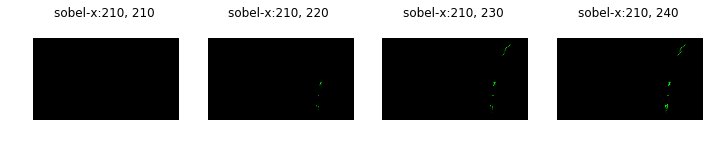

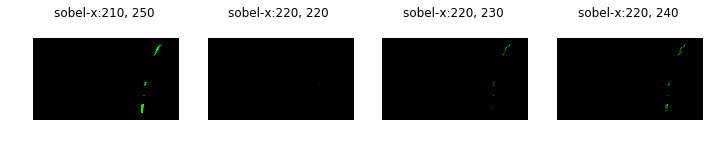

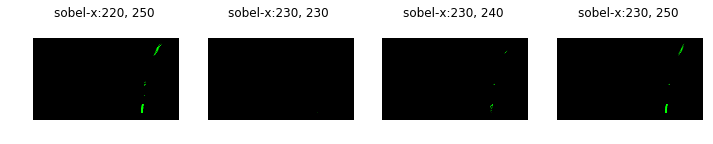

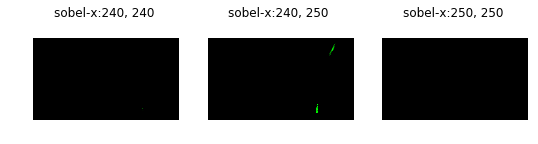

In [9]:
thresholds= []
for i in range(0,255,10):
    for j in range(0,255,10):
        if i>j:
            continue
        thresholds.append((i,j))
        
img  = mpimg.imread('./test_images/test5.jpg')
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
L = hls[:,:,1]

printLotsOfThresholds(L, thresholds, 4,FIGSIZE = (12,12))

## S in HLS

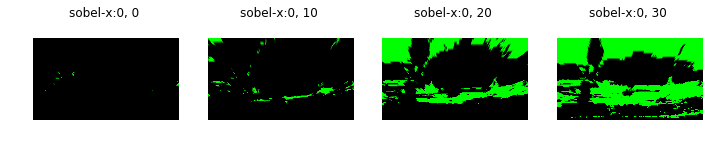

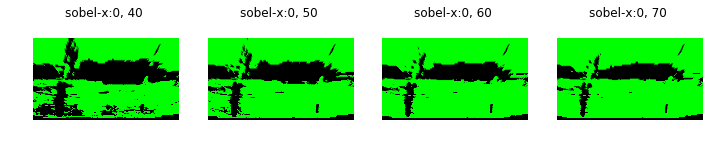

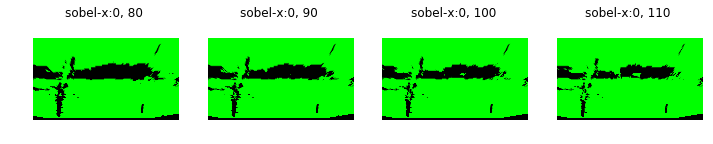

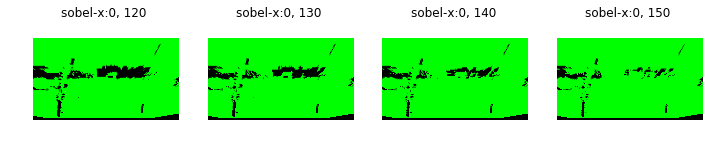

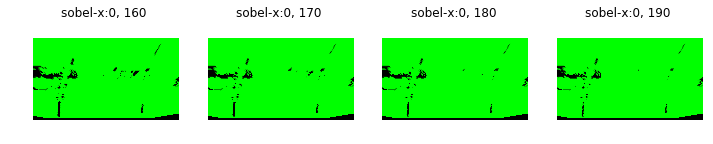

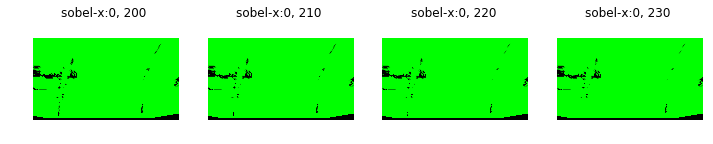

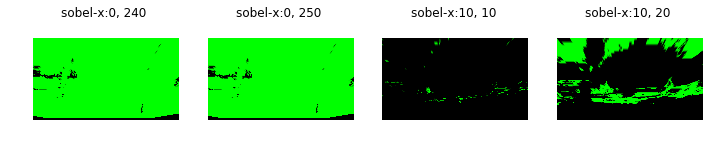

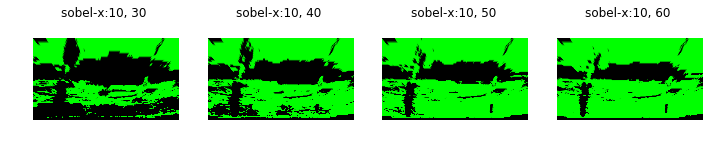

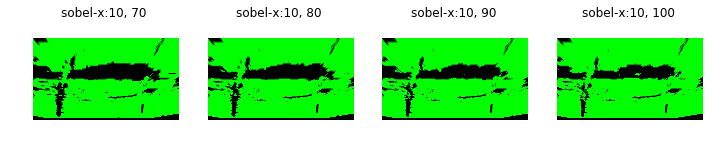

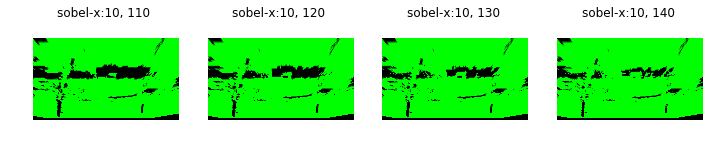

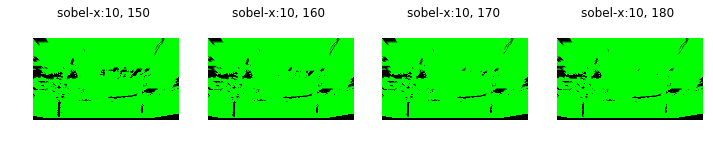

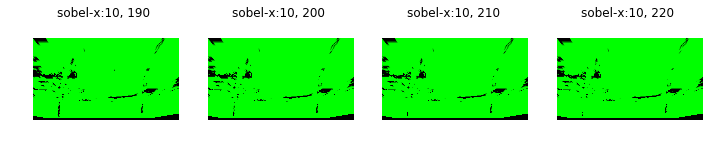

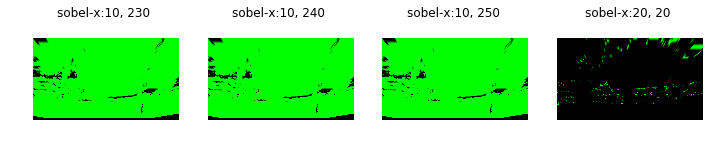

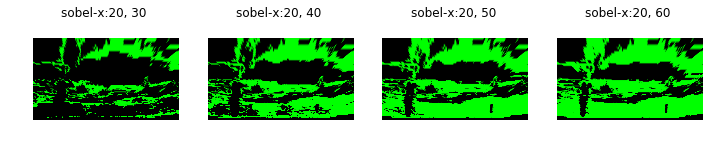

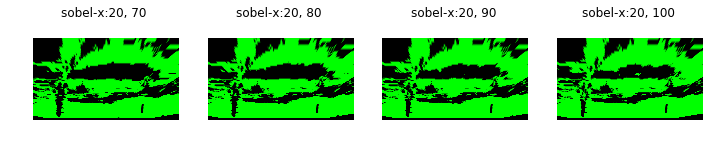

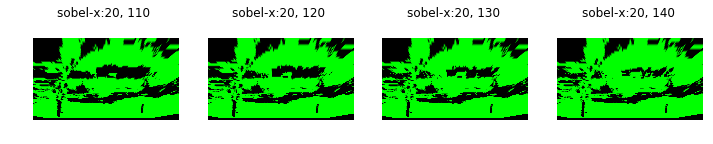

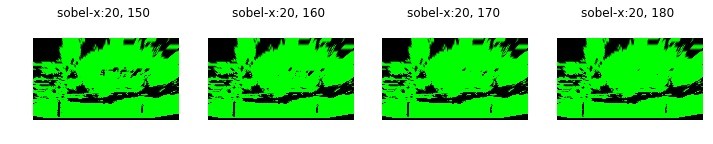

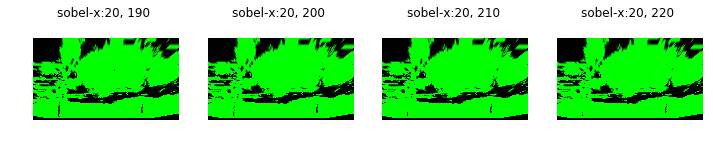

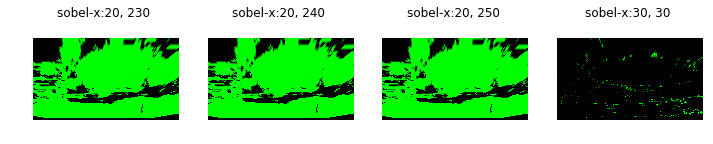

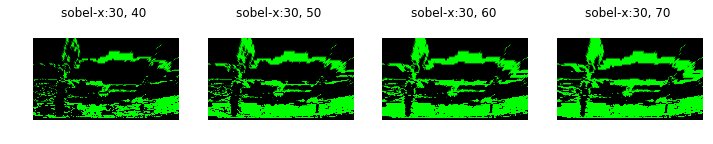

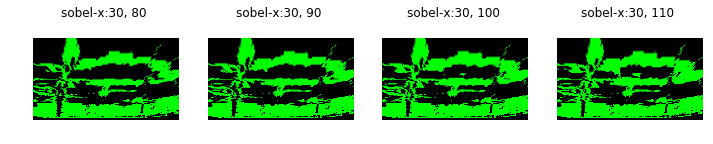

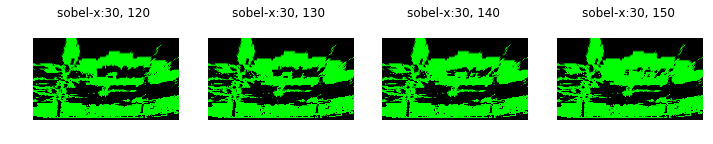

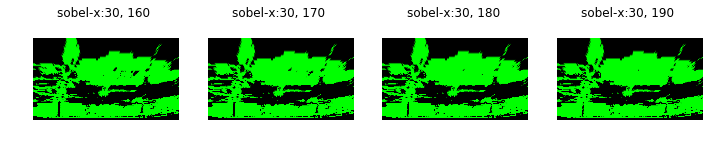

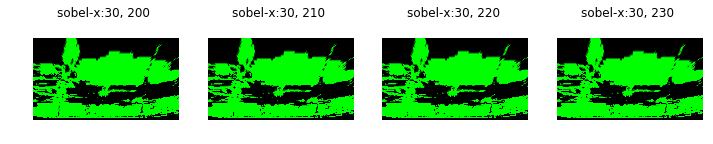

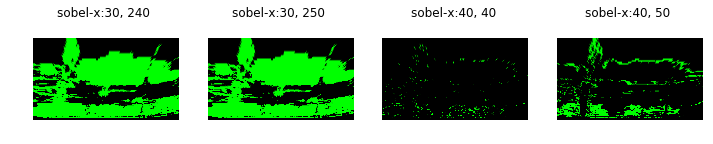

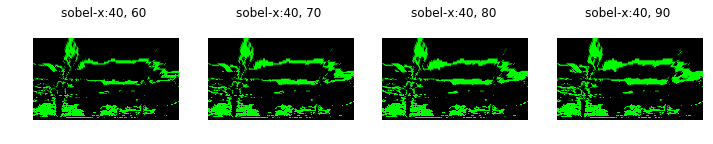

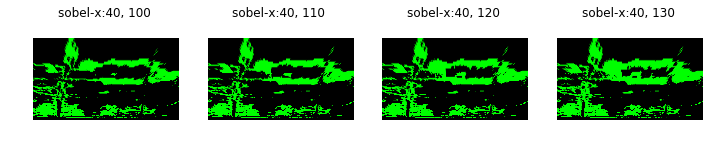

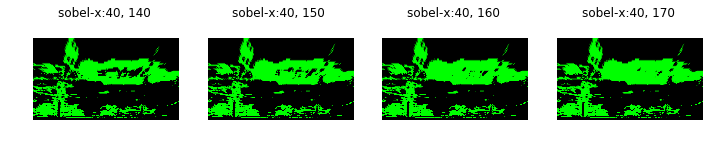

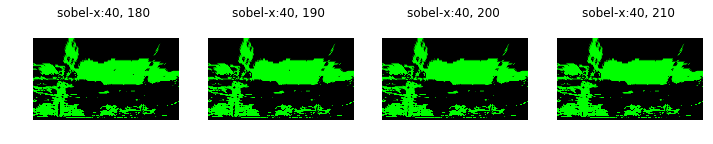

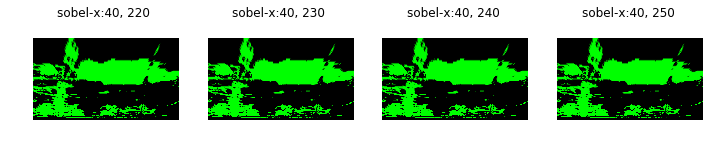

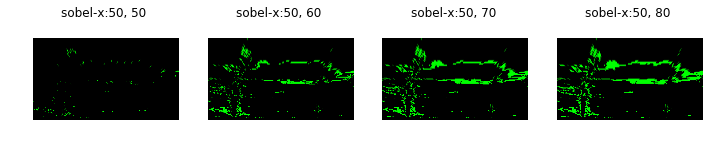

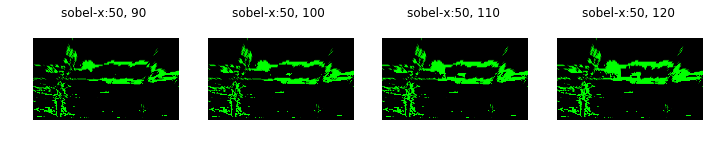

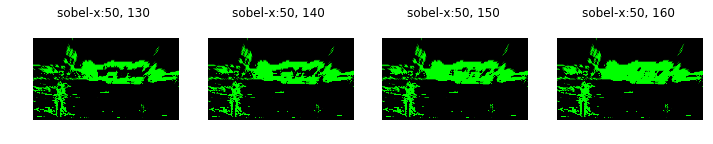

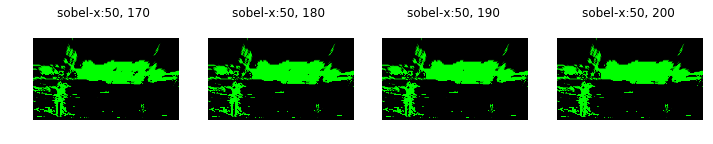

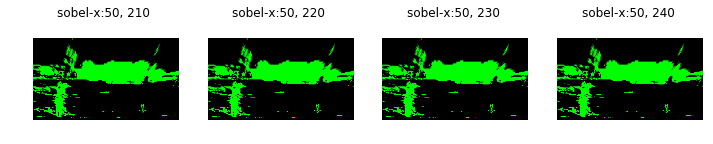

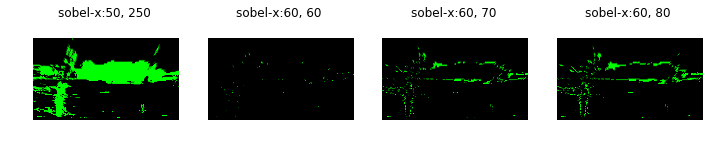

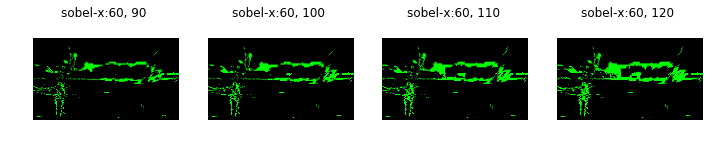

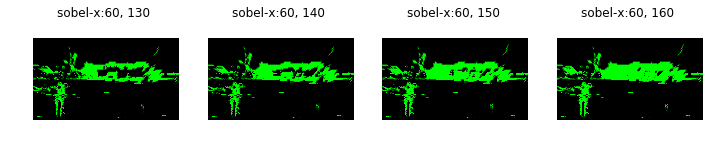

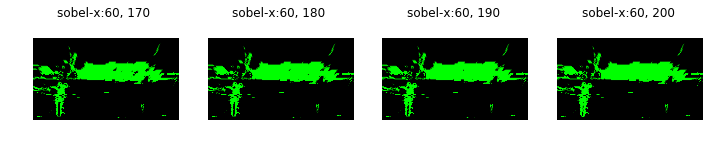

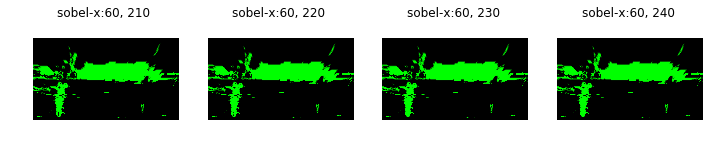

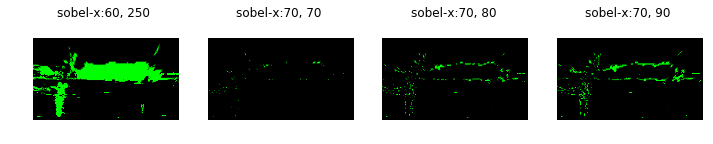

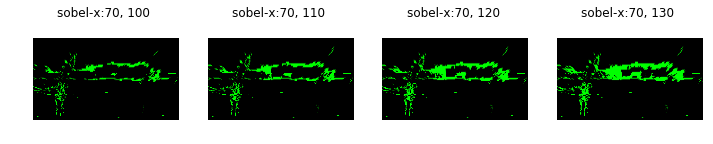

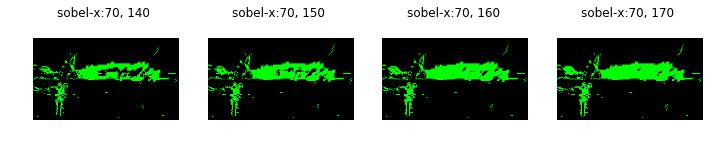

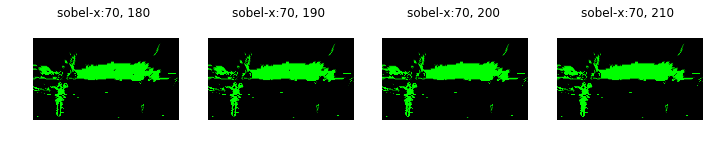

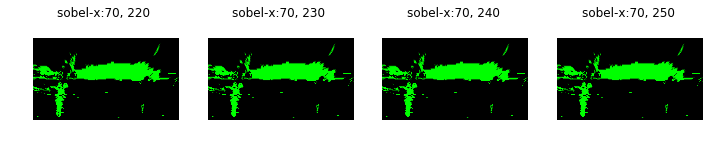

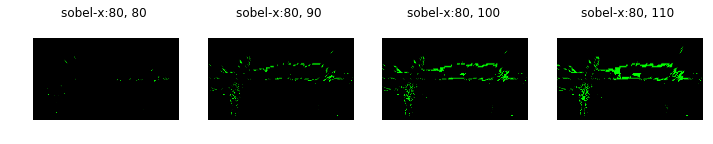

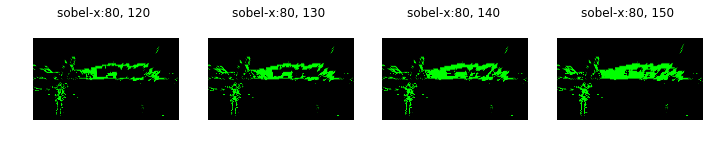

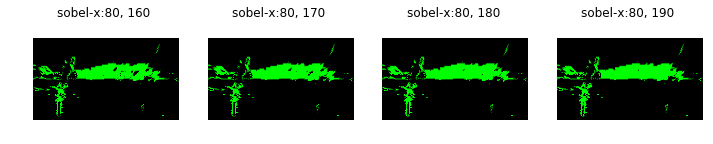

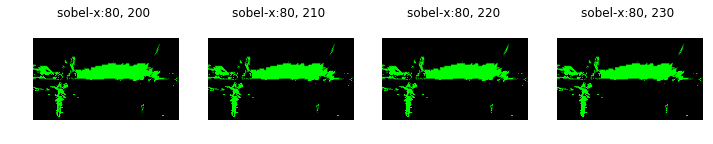

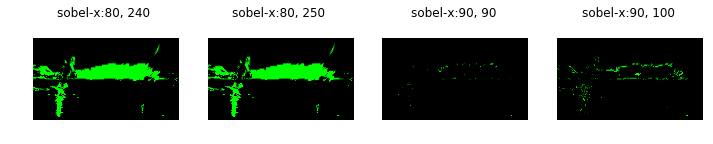

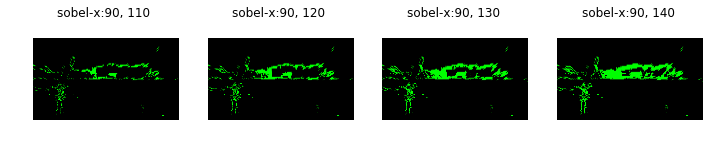

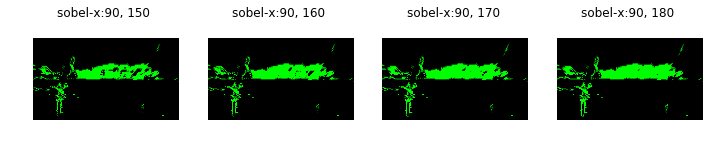

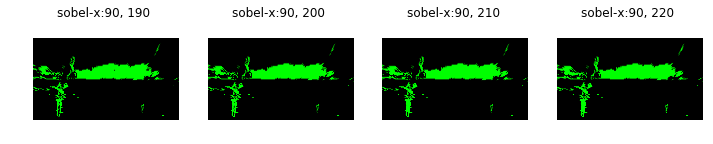

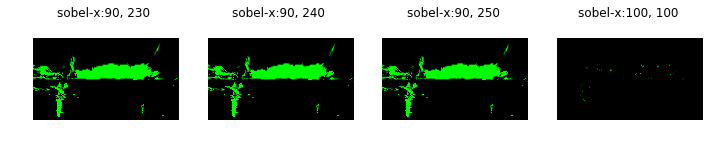

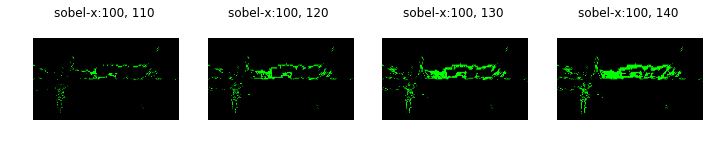

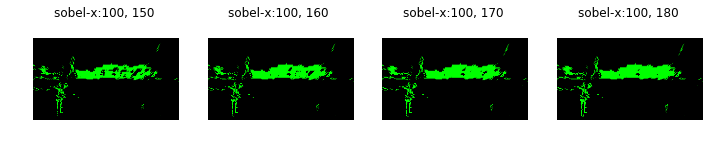

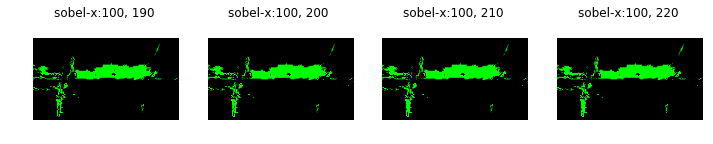

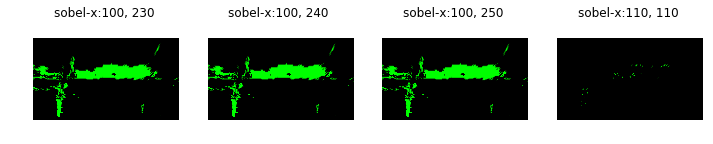

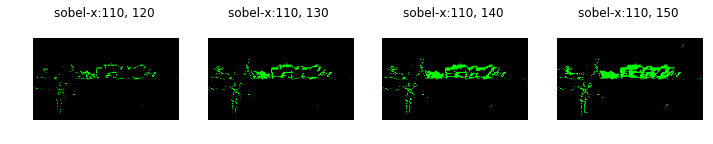

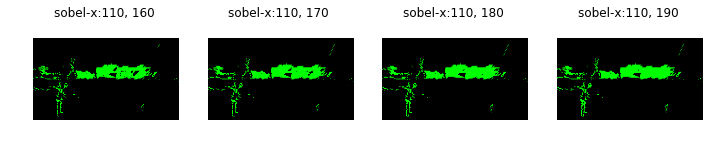

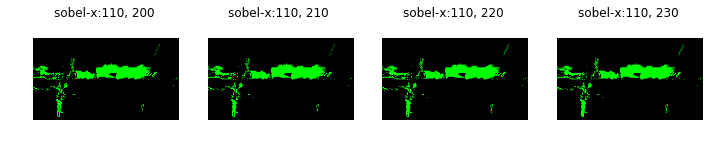

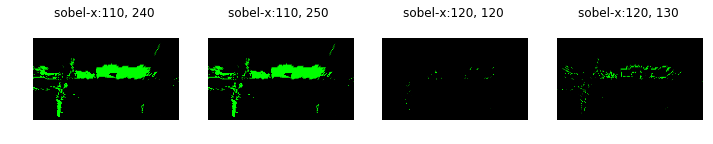

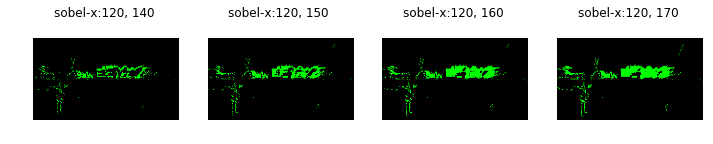

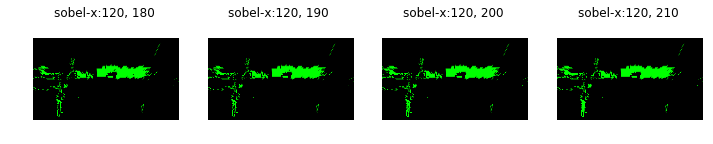

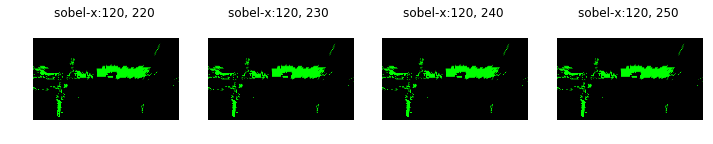

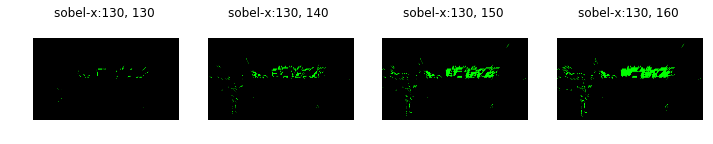

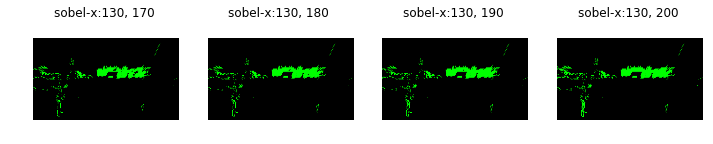

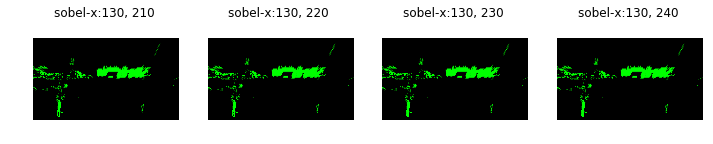

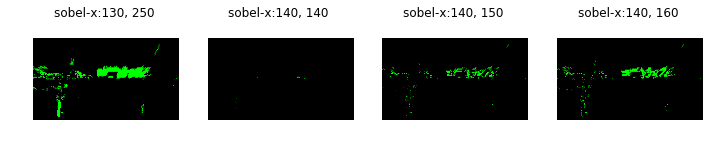

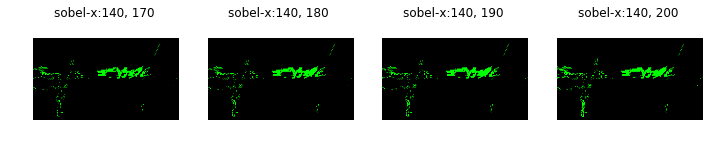

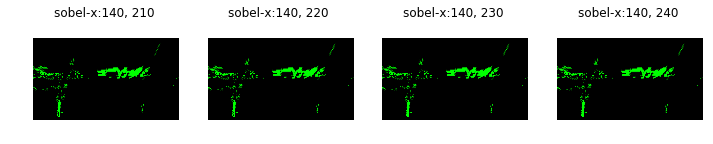

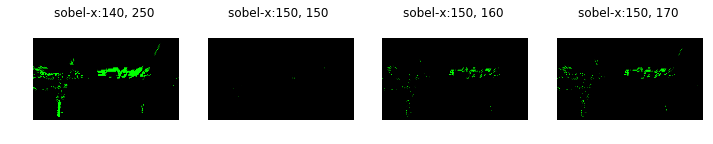

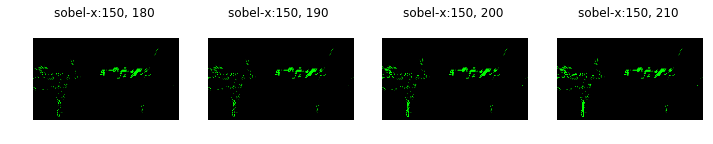

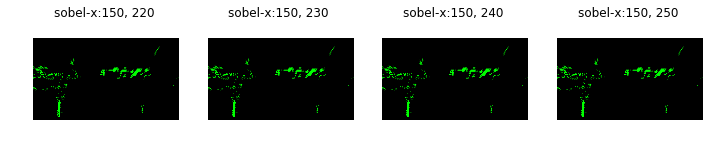

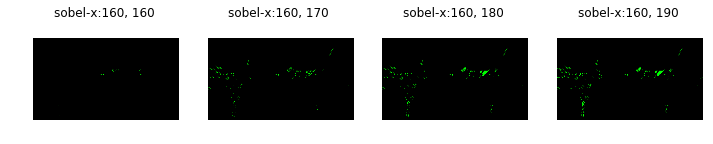

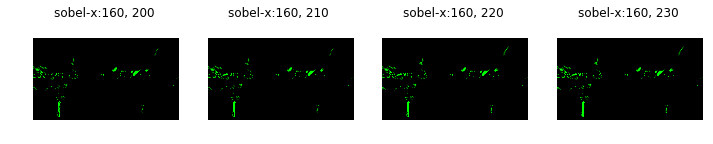

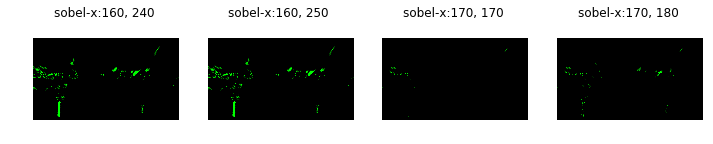

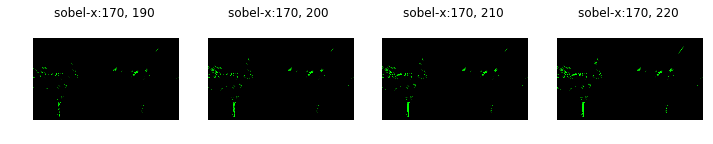

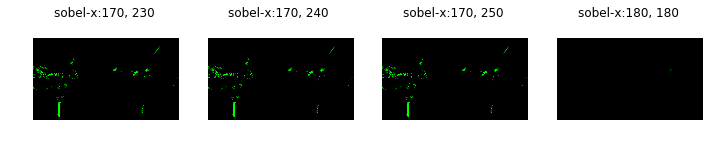

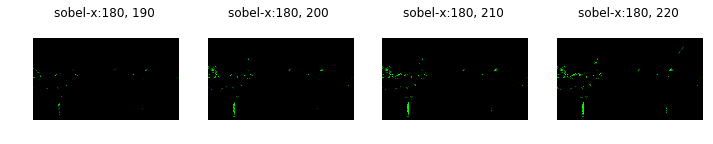

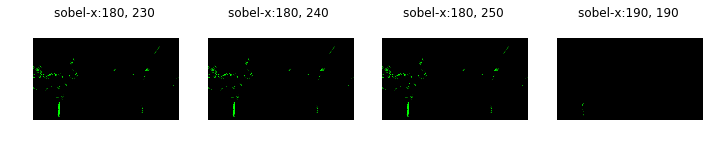

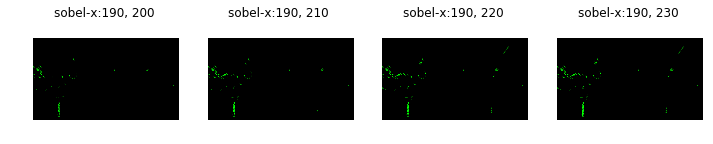

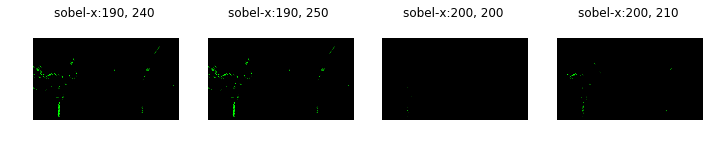

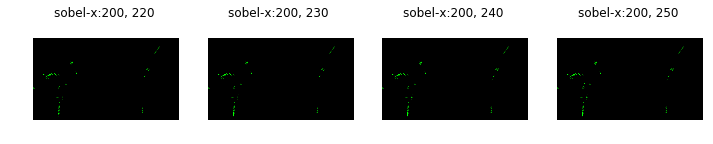

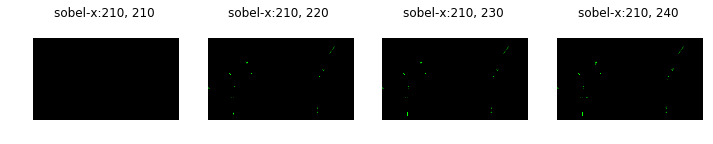

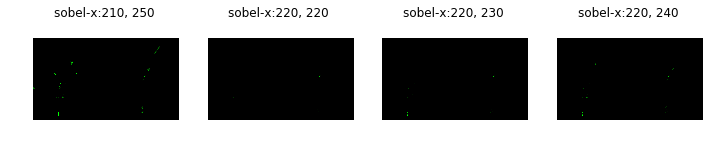

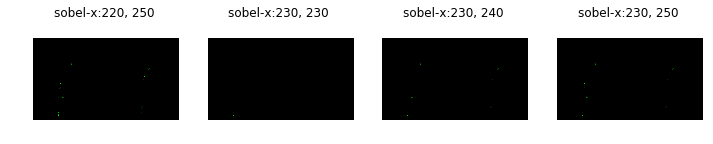

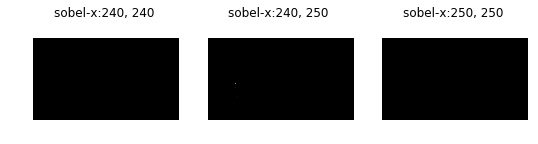

In [10]:
thresholds= []
for i in range(0,255,10):
    for j in range(0,255,10):
        if i>j:
            continue
        thresholds.append((i,j))
        
img  = mpimg.imread('./test_images/test5.jpg')
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
S = hls[:,:,2]

printLotsOfThresholds(S, thresholds, 4,FIGSIZE = (12,12))

## H in HSV

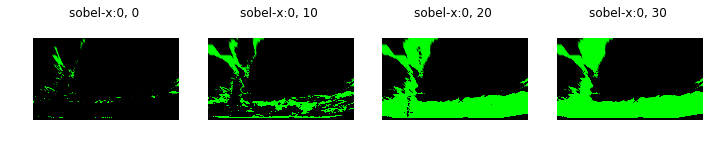

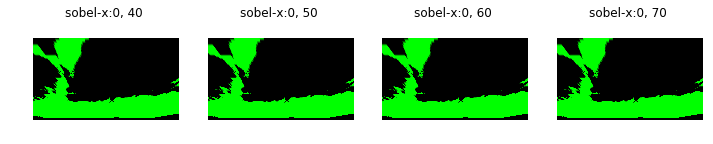

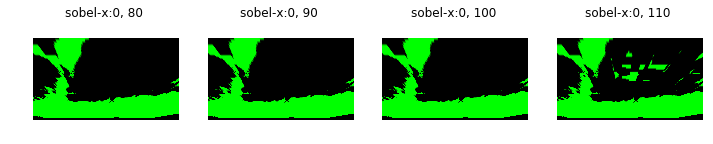

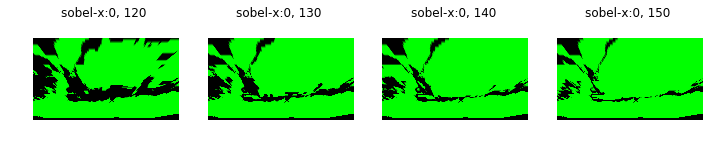

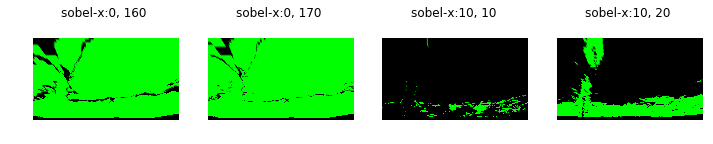

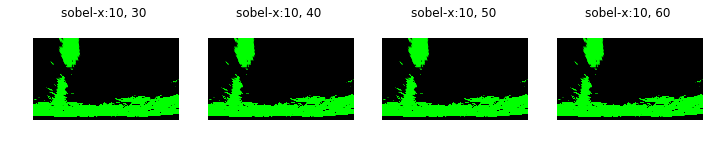

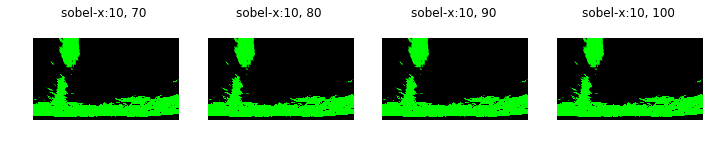

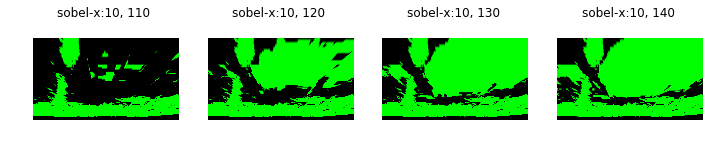

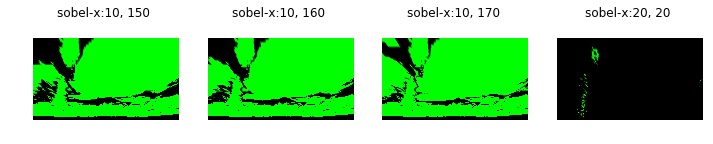

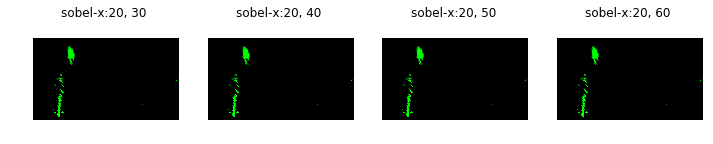

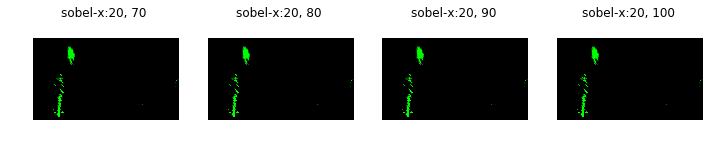

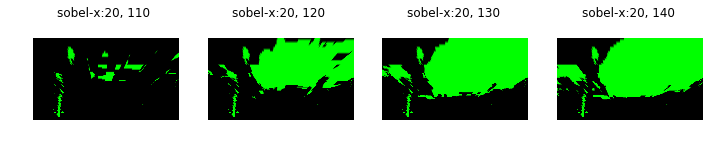

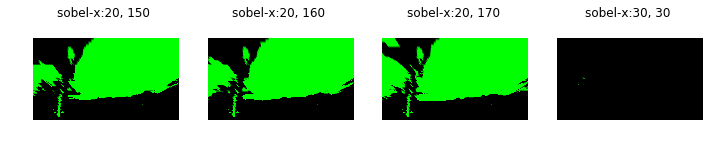

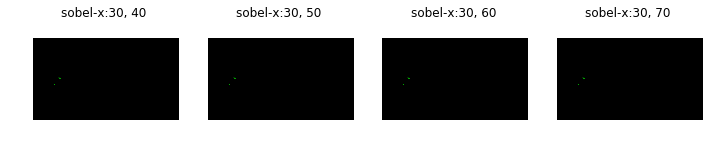

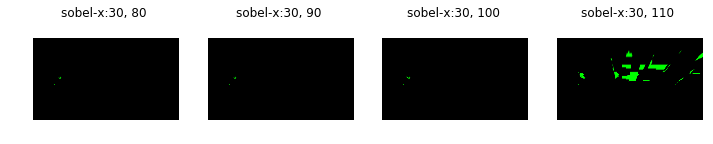

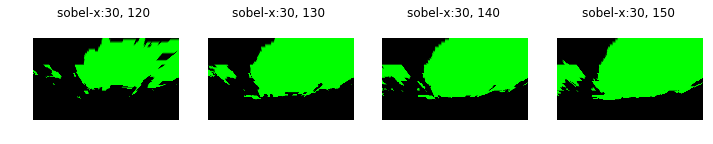

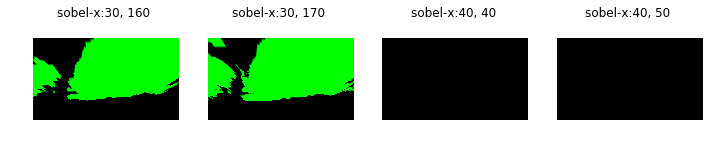

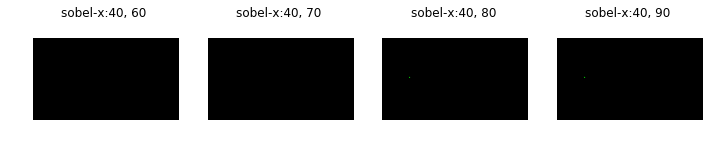

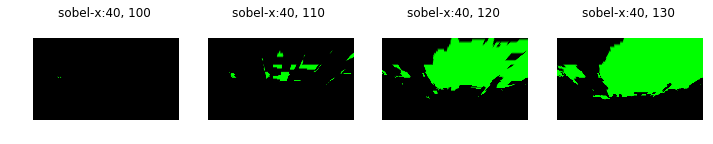

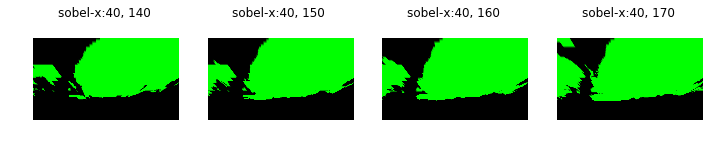

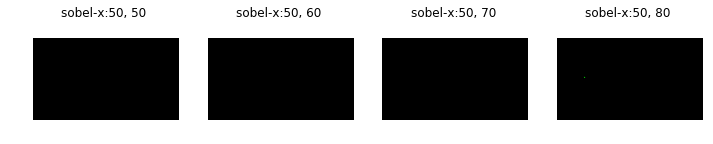

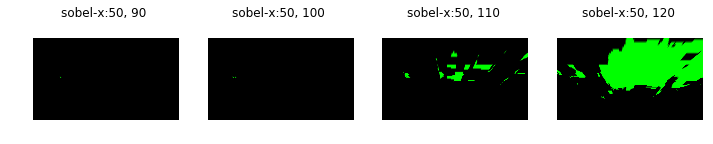

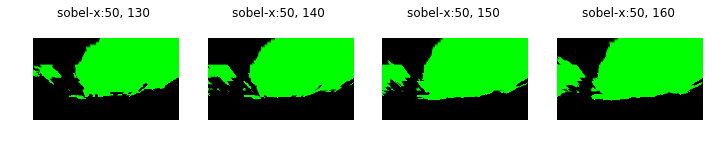

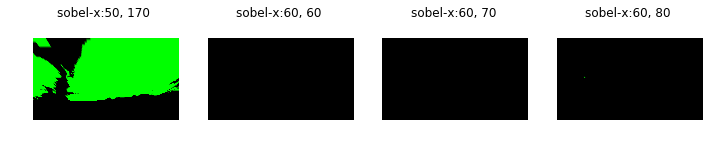

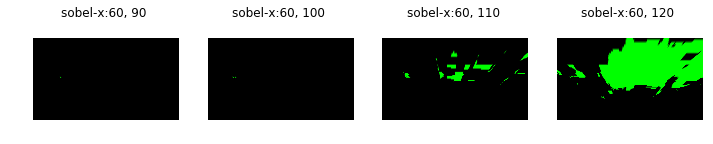

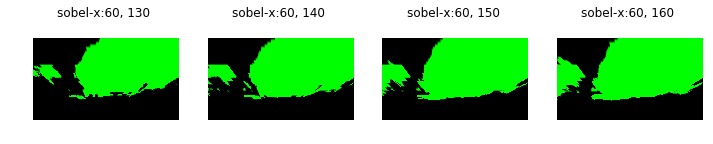

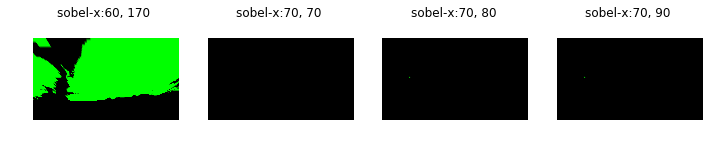

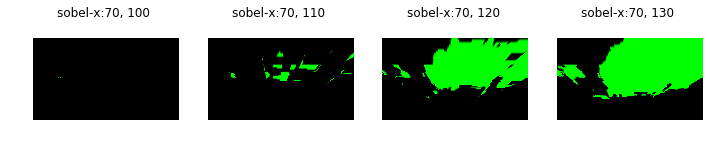

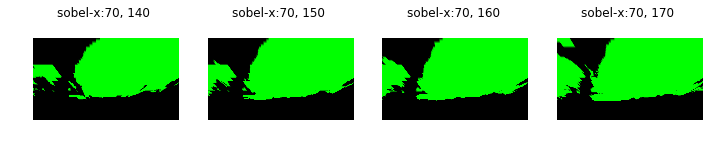

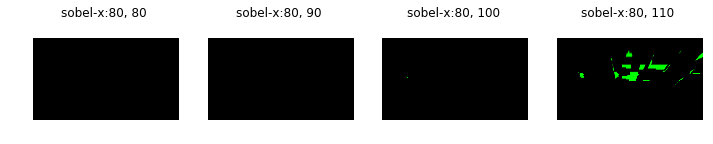

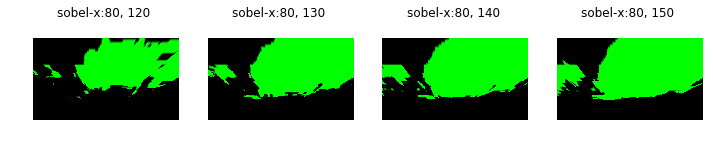

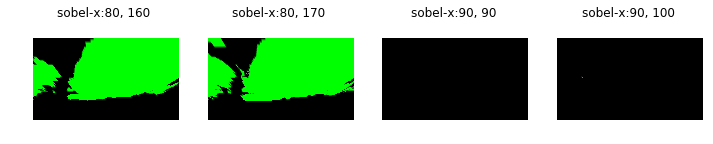

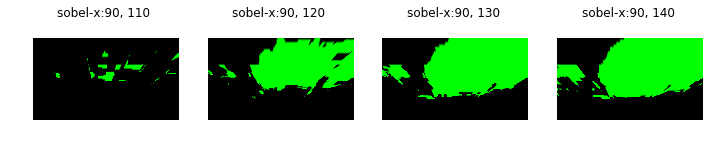

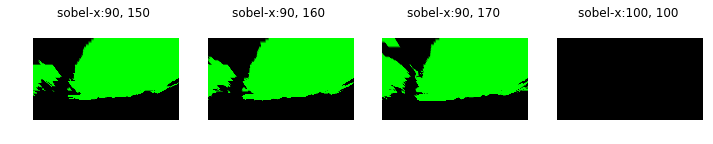

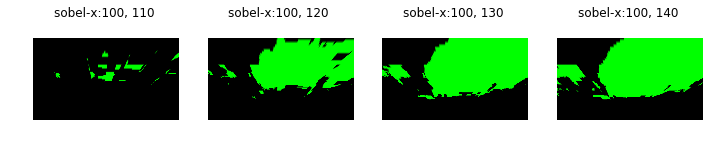

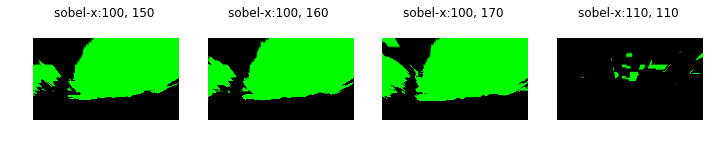

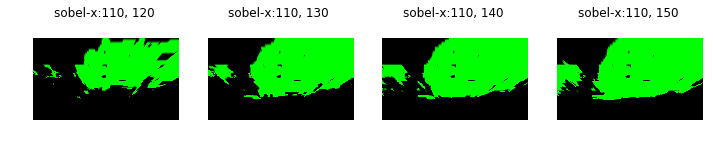

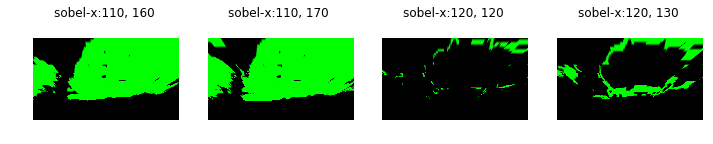

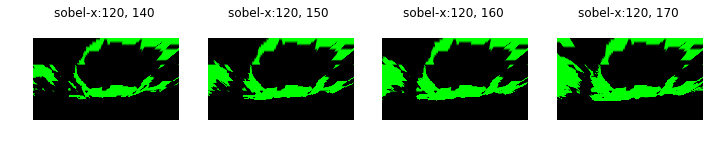

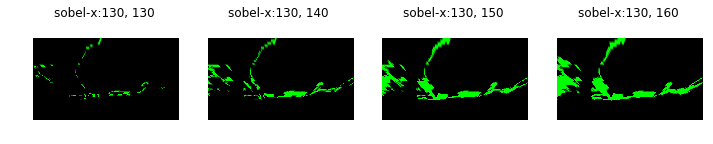

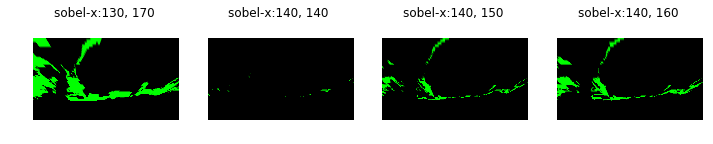

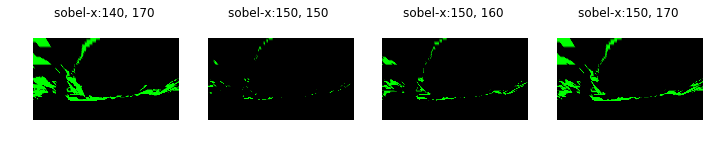

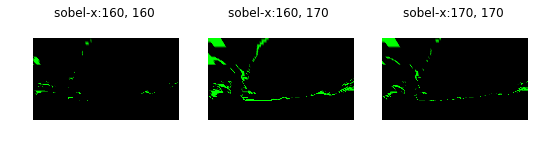

In [11]:
thresholds= []
for i in range(0,179,10):
    for j in range(0,179,10):
        if i>j:
            continue
        thresholds.append((i,j))
        
img  = mpimg.imread('./test_images/test5.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
H = hsv[:,:,0]

printLotsOfThresholds(H, thresholds, 4,FIGSIZE = (12,12))

## S in HSV

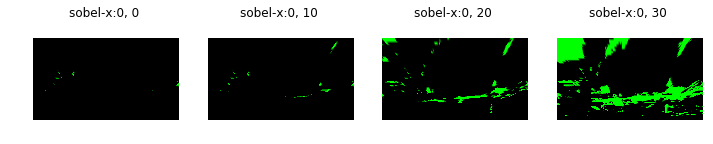

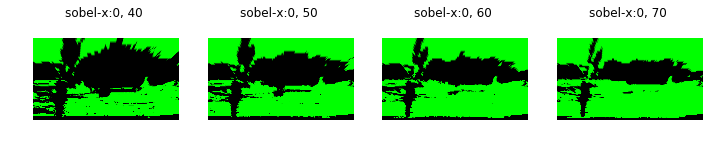

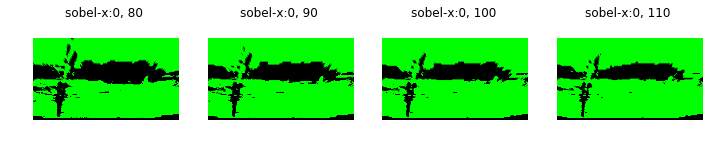

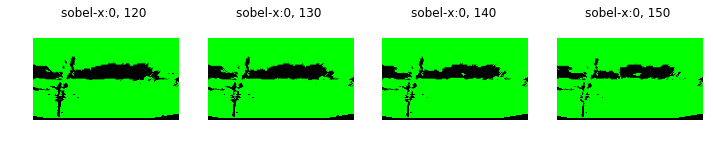

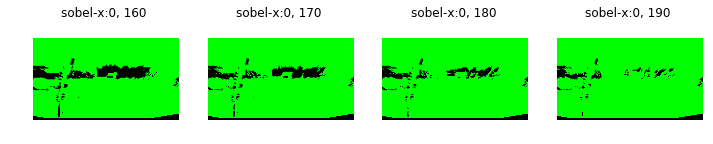

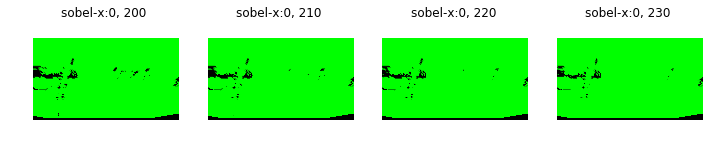

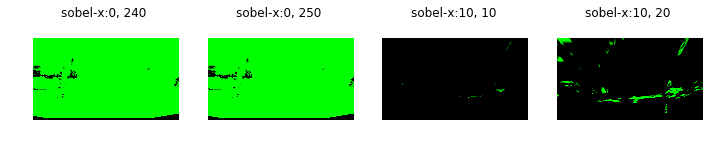

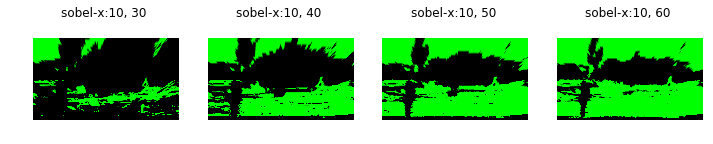

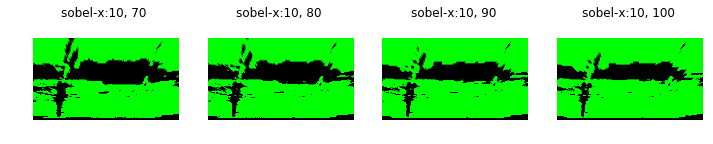

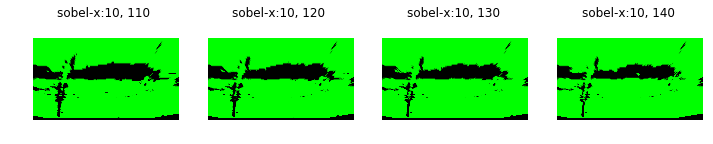

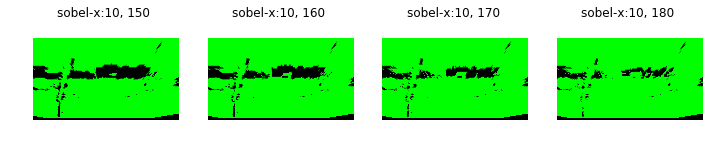

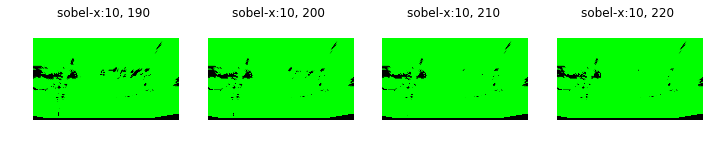

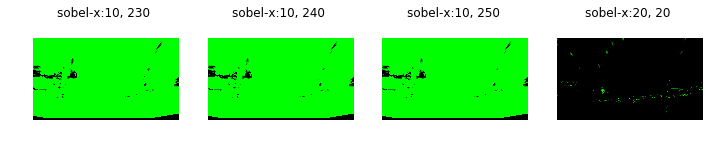

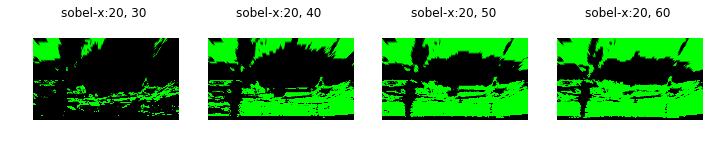

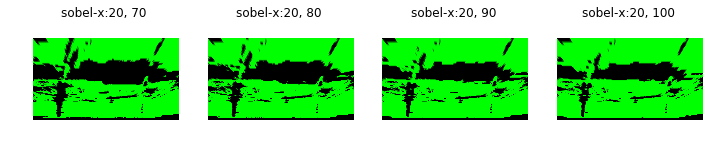

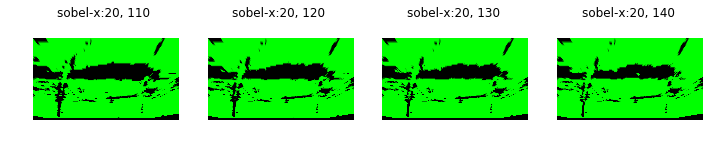

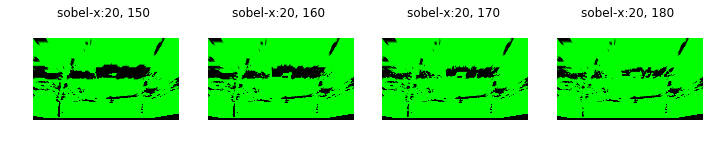

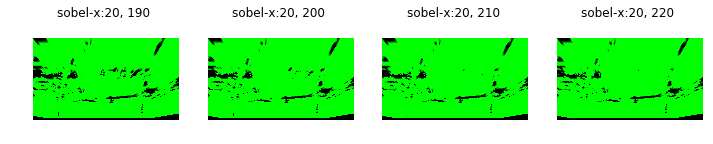

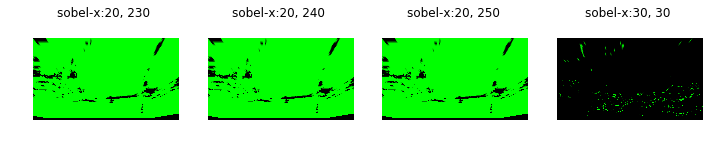

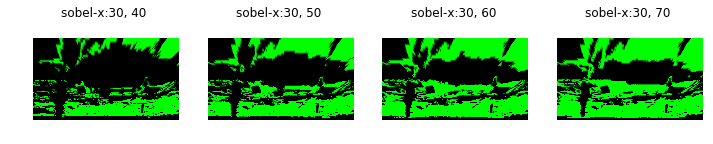

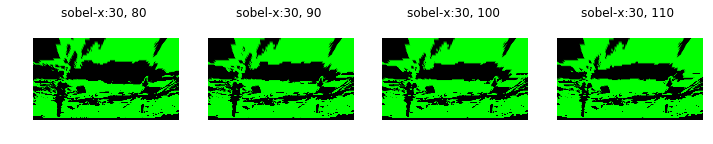

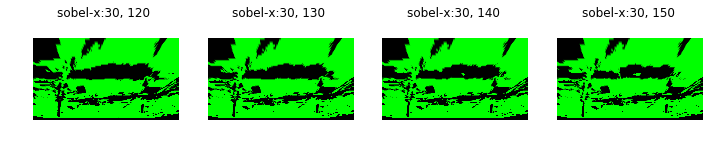

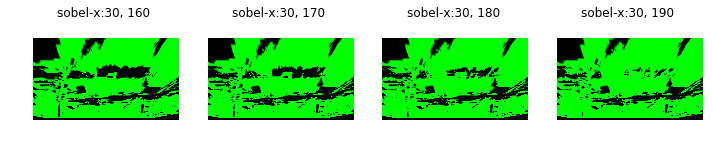

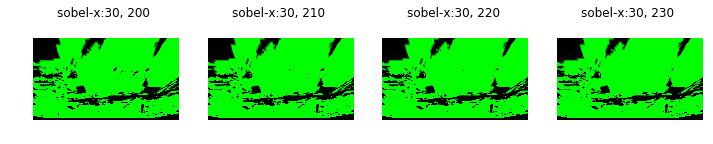

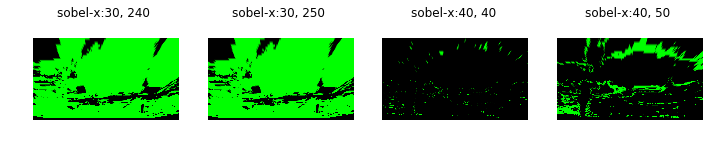

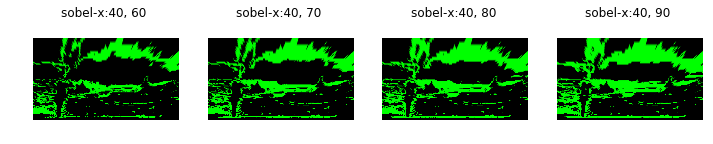

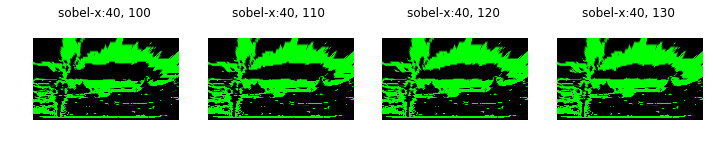

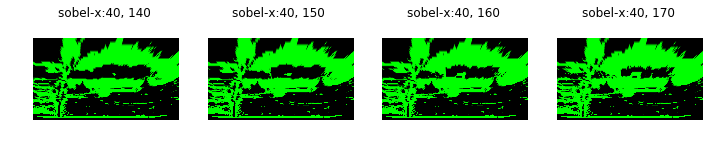

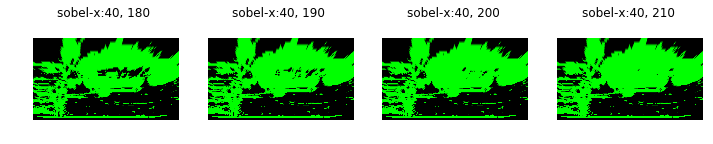

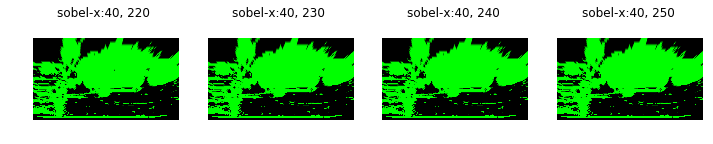

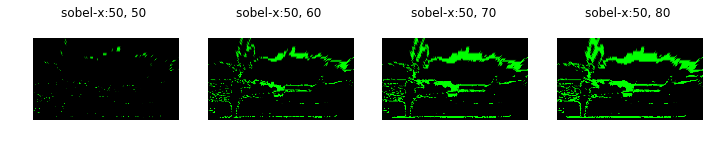

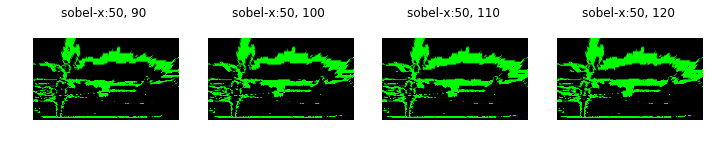

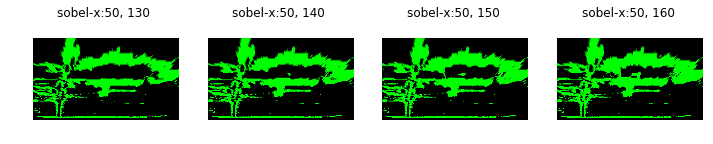

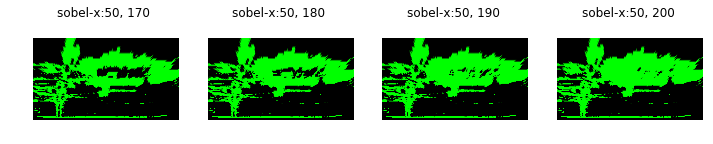

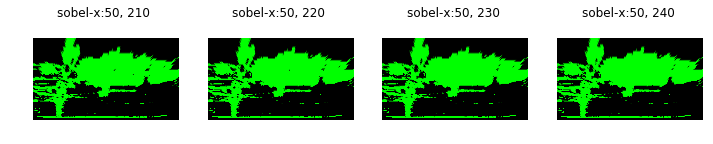

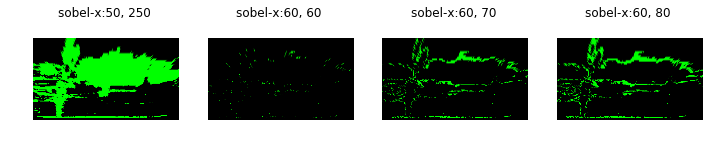

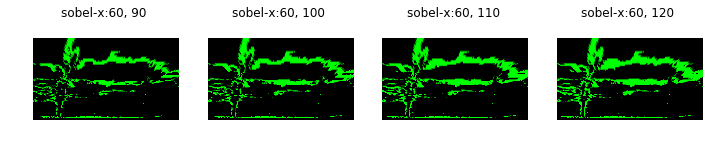

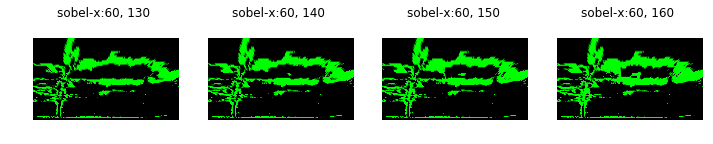

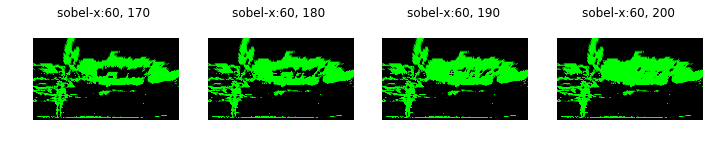

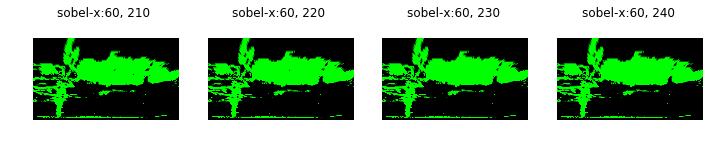

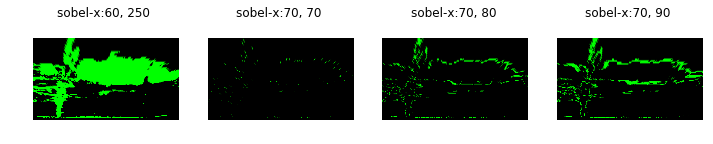

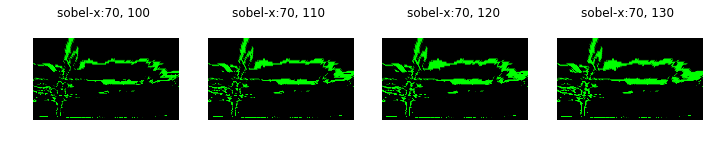

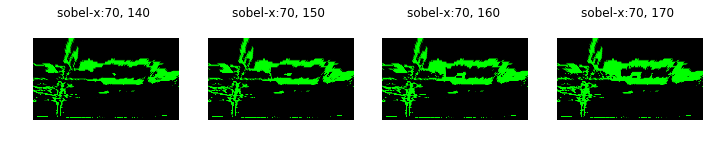

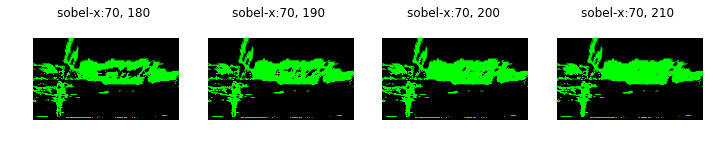

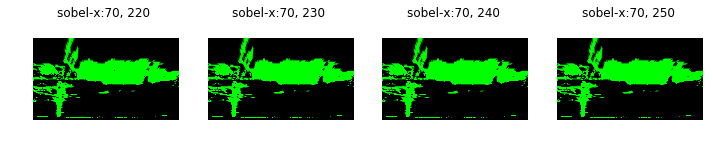

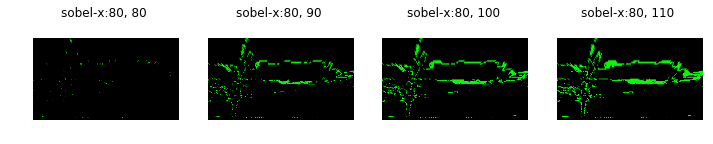

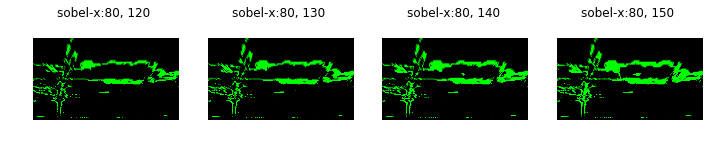

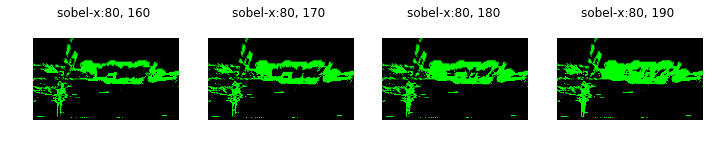

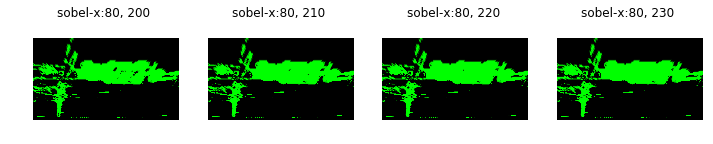

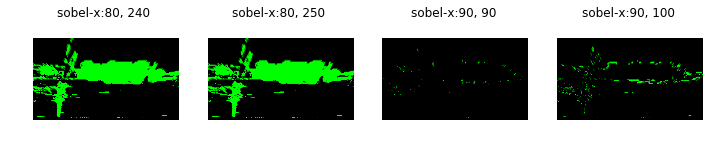

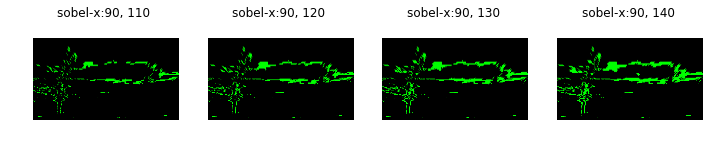

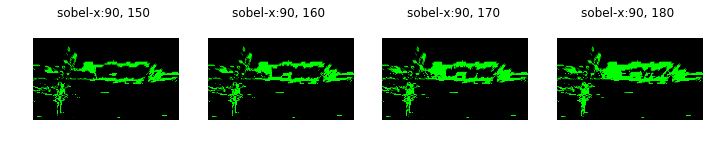

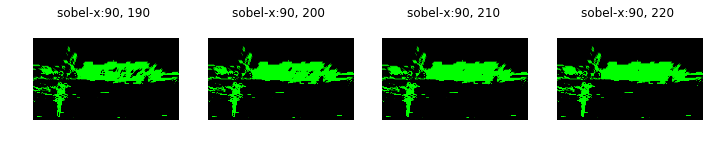

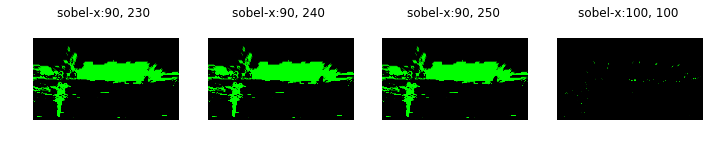

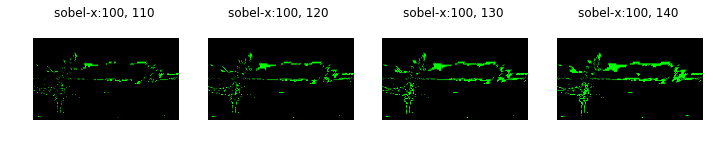

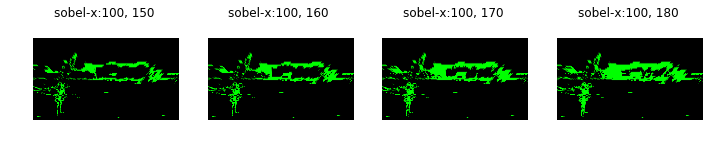

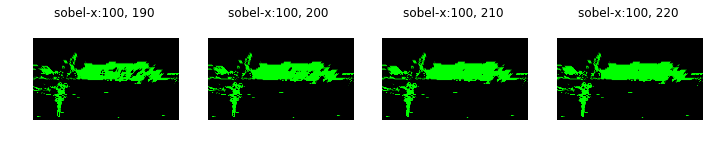

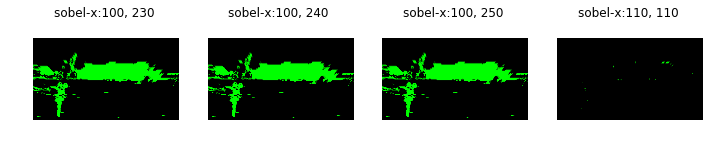

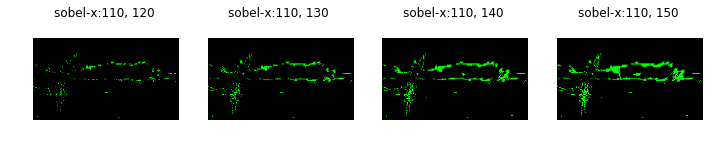

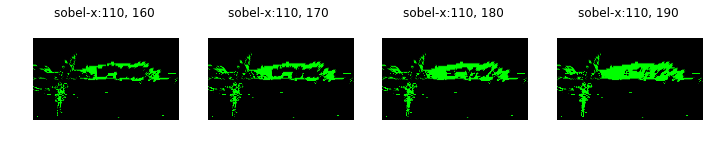

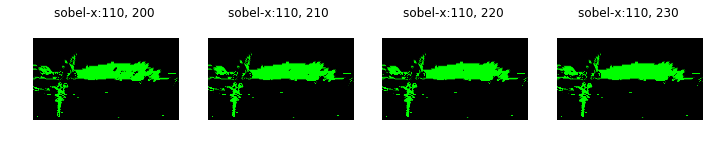

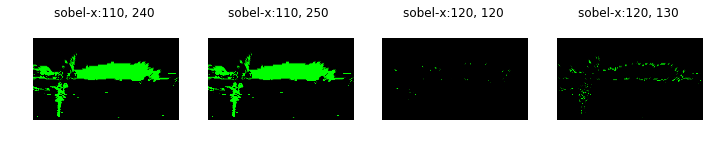

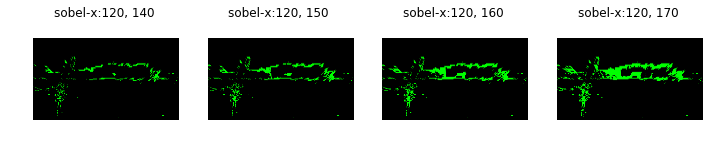

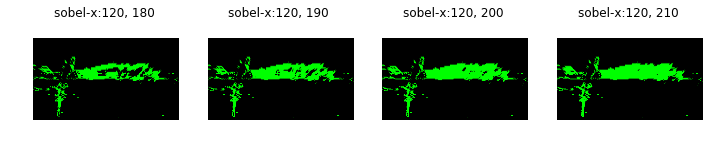

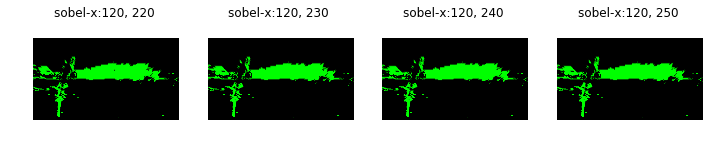

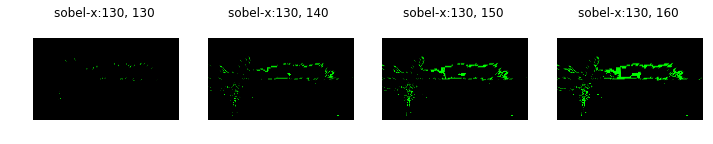

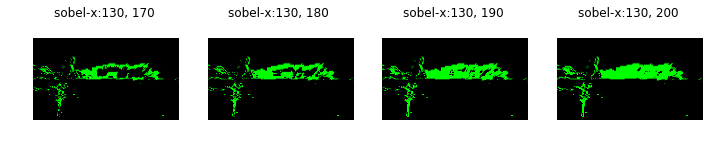

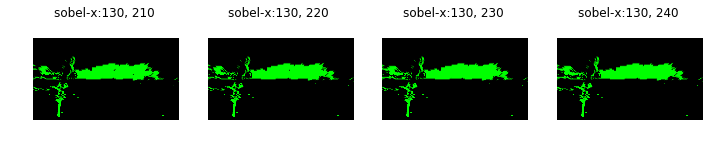

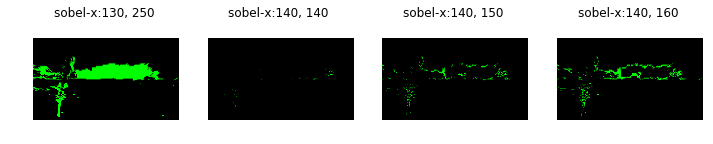

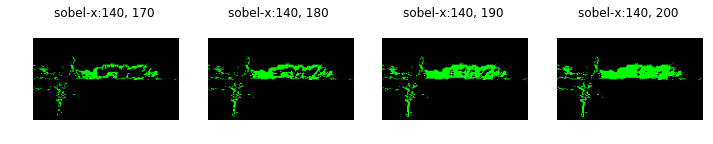

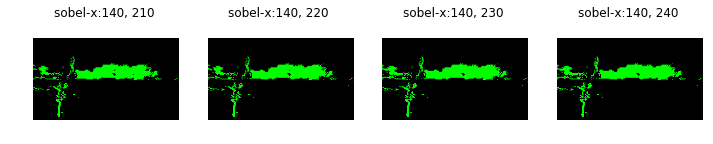

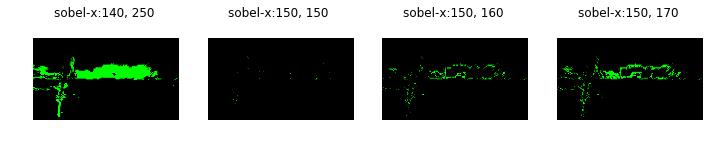

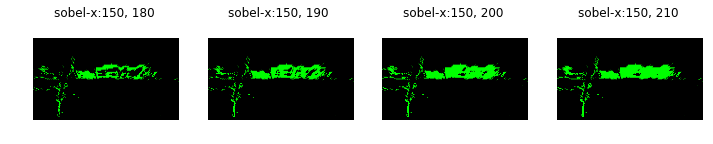

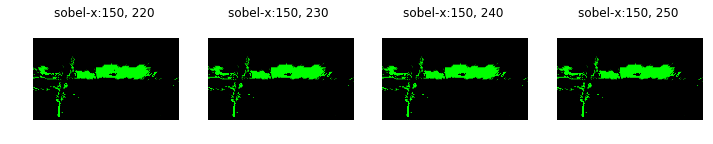

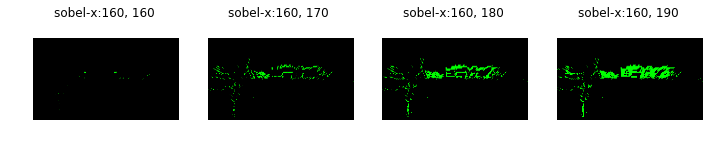

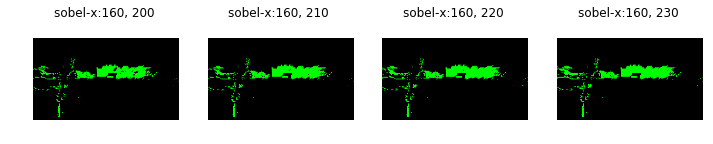

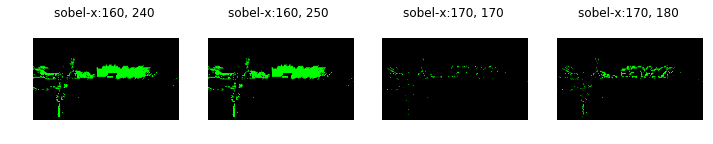

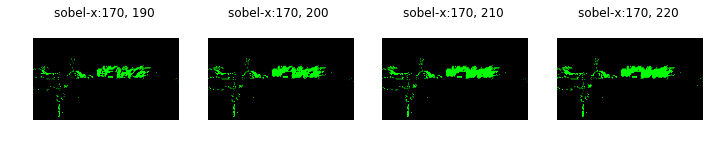

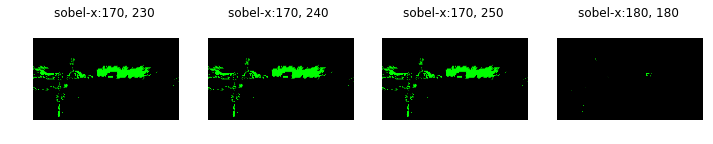

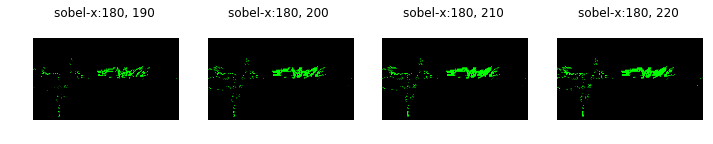

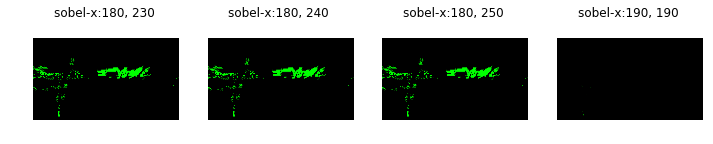

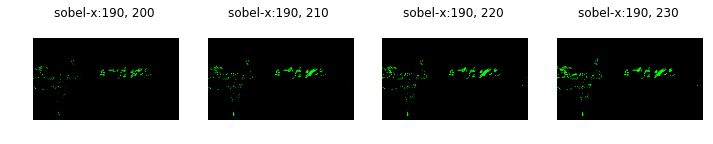

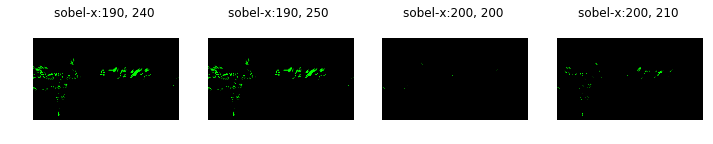

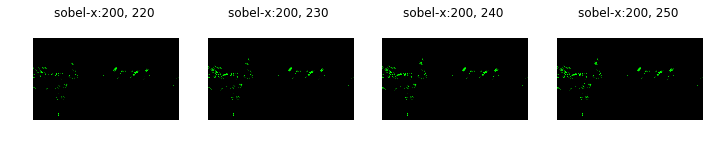

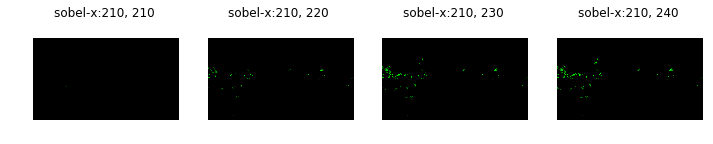

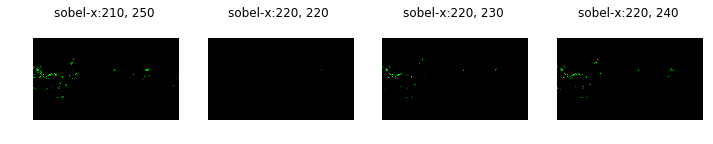

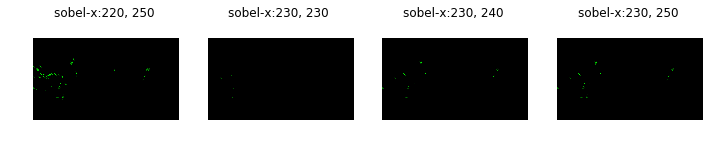

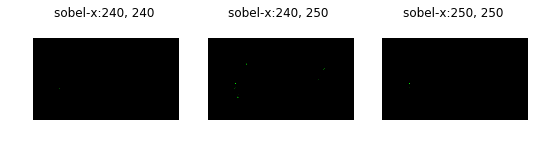

In [12]:
thresholds= []
for i in range(0,255,10):
    for j in range(0,255,10):
        if i>j:
            continue
        thresholds.append((i,j))
        
img  = mpimg.imread('./test_images/test5.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
S = hsv[:,:,1]

printLotsOfThresholds(S, thresholds, 4,FIGSIZE = (12,12))

## V in HSV

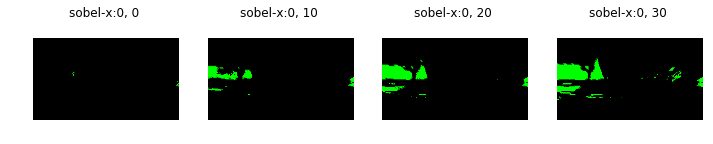

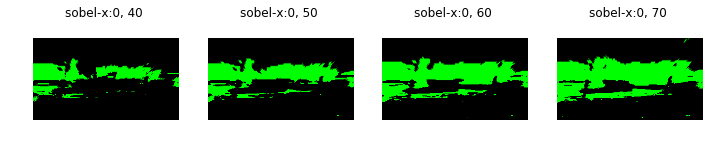

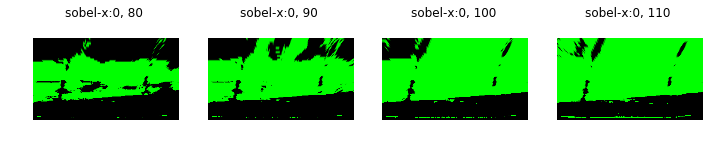

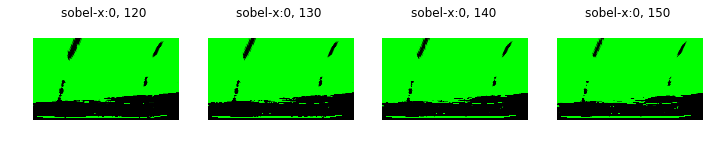

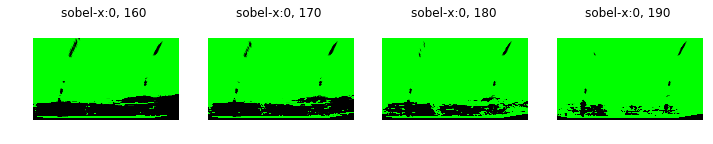

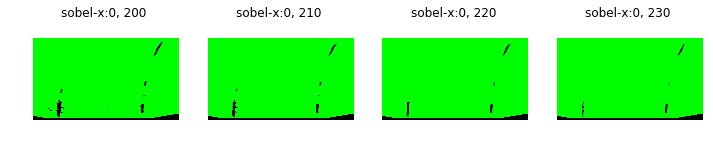

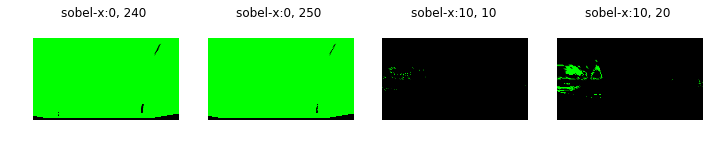

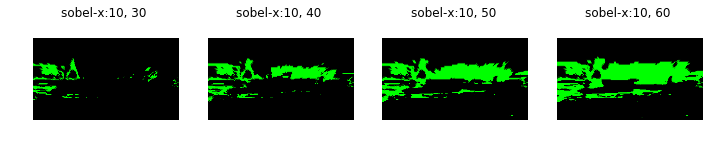

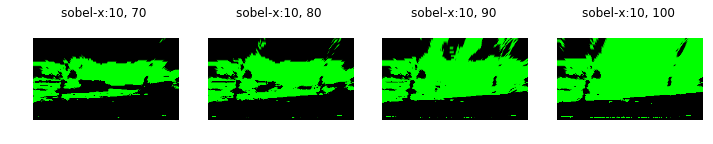

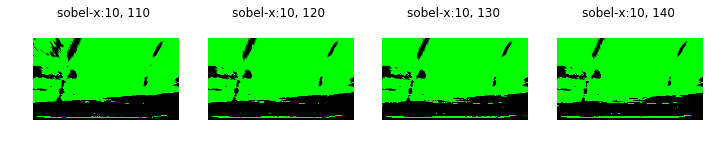

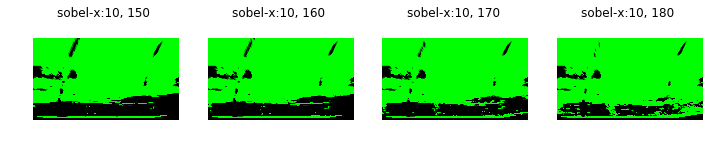

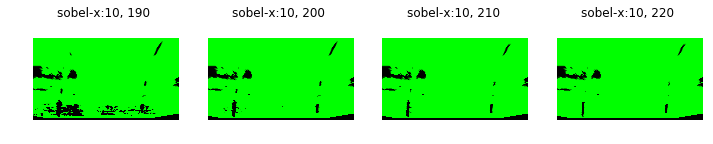

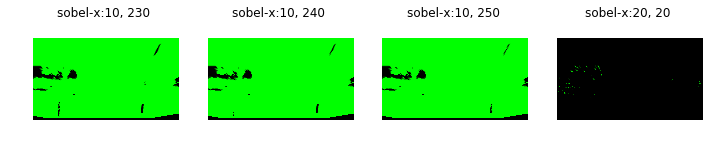

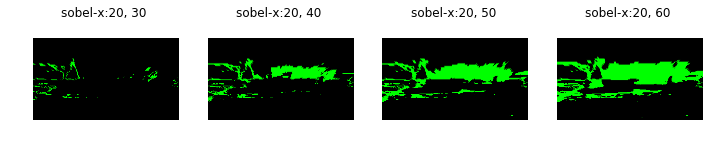

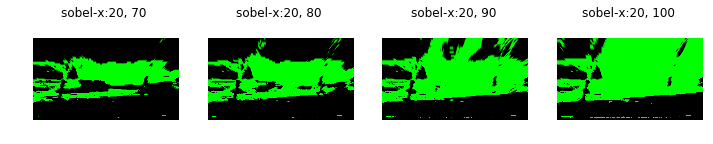

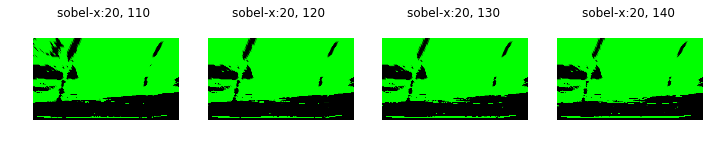

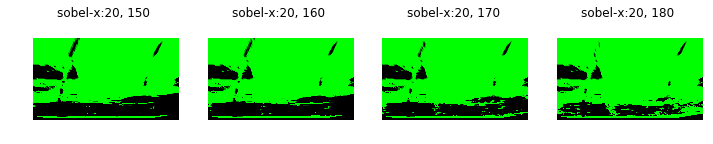

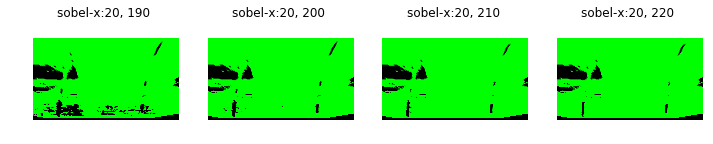

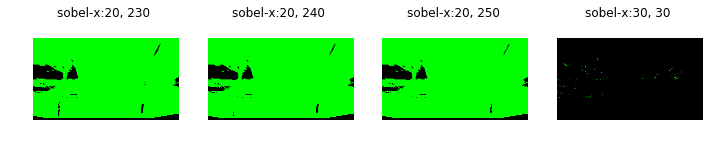

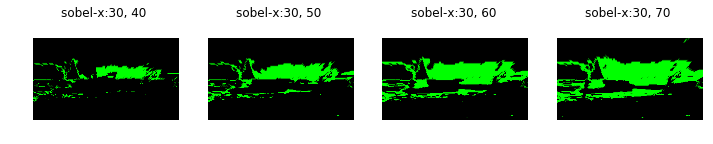

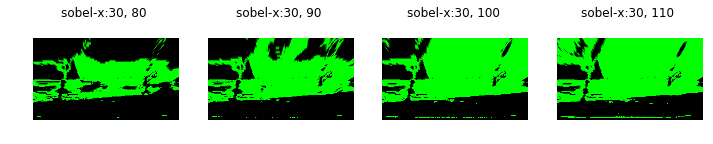

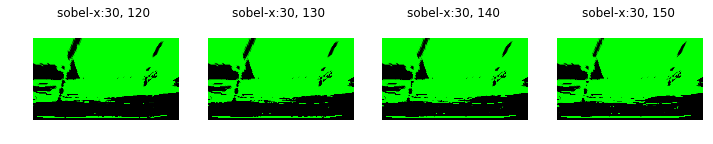

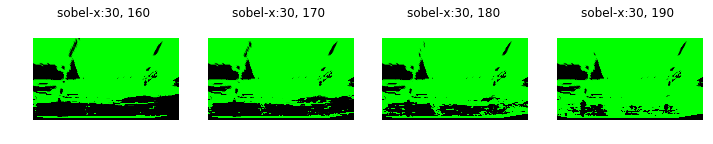

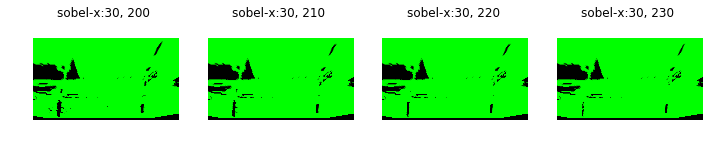

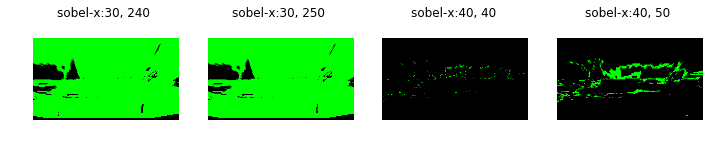

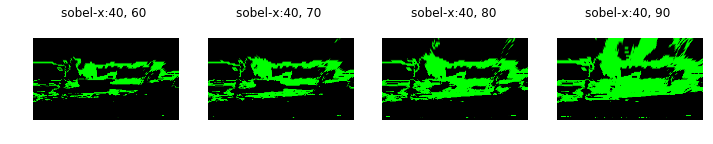

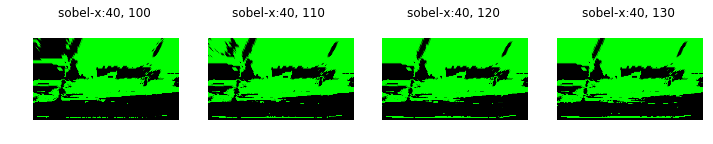

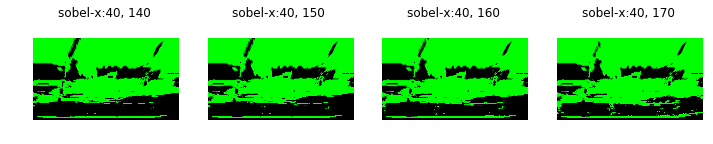

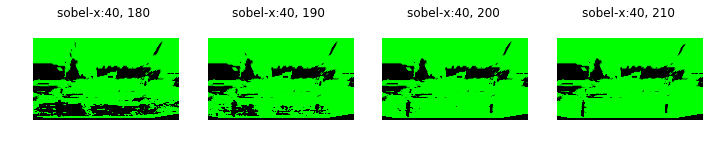

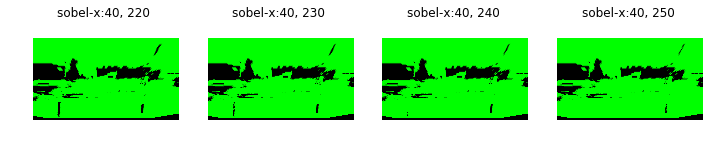

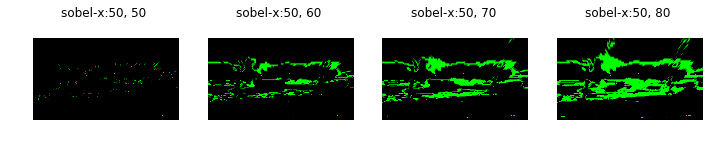

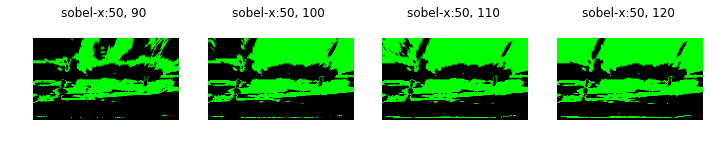

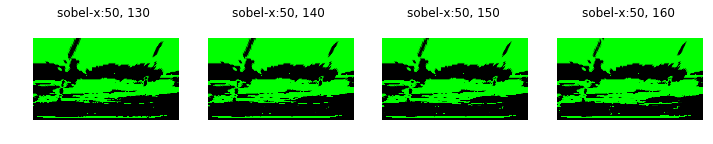

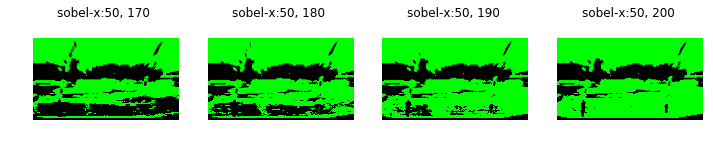

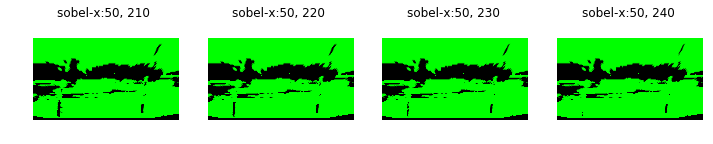

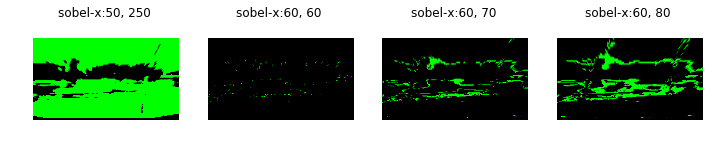

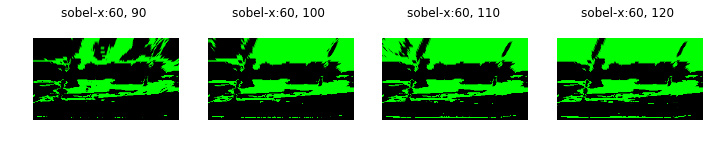

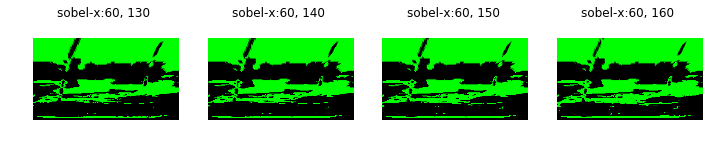

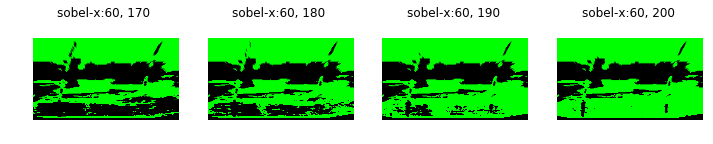

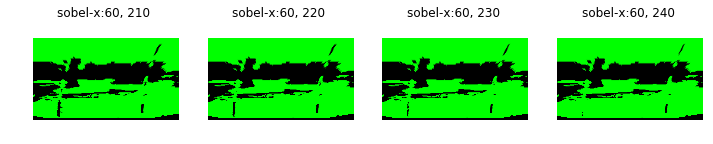

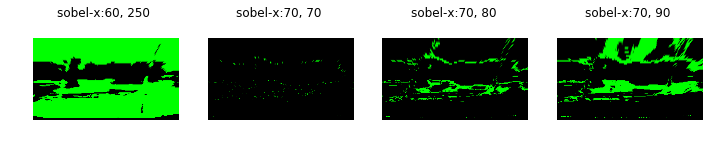

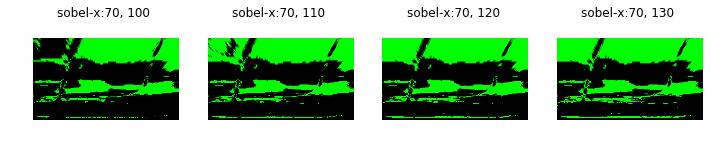

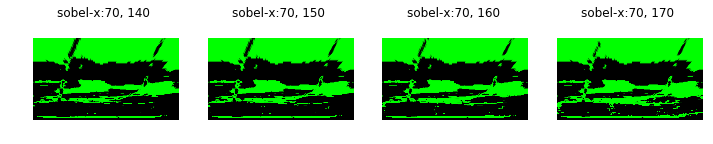

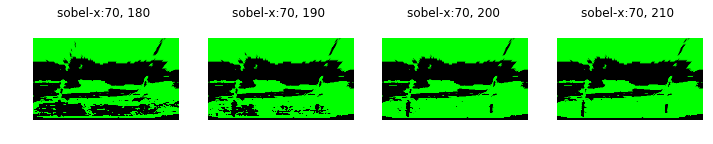

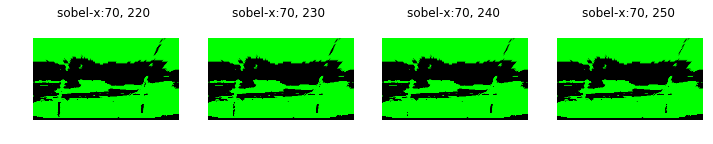

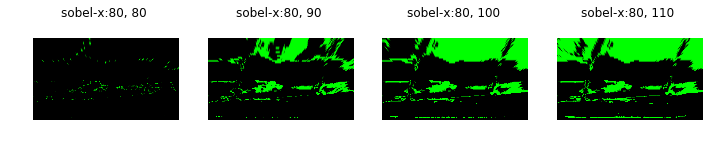

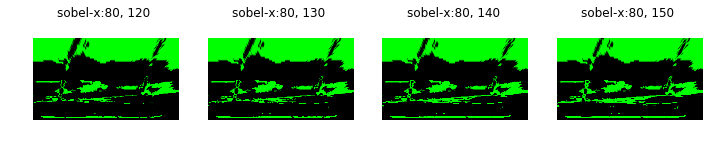

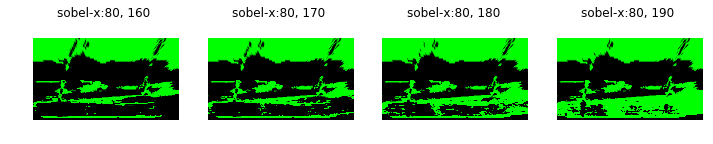

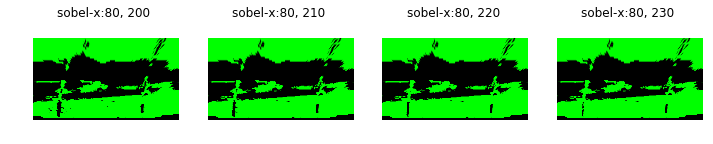

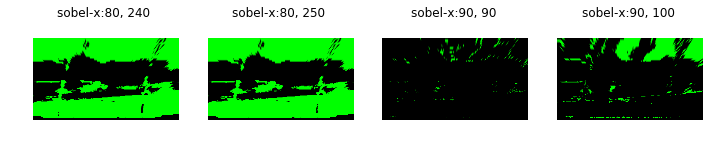

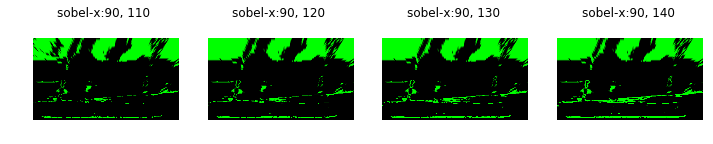

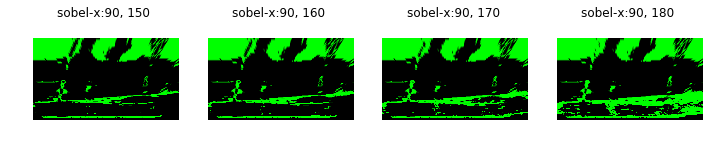

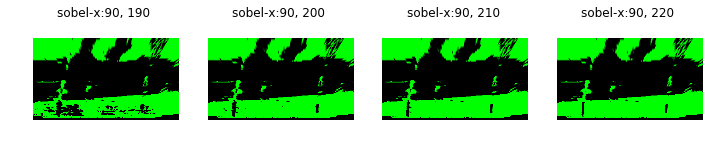

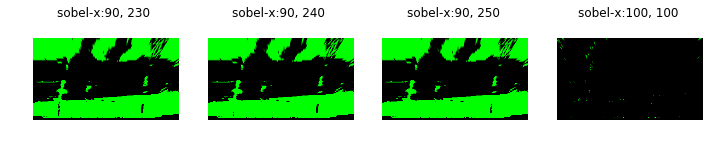

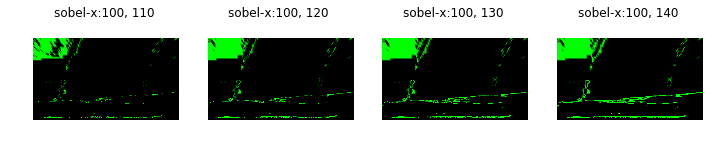

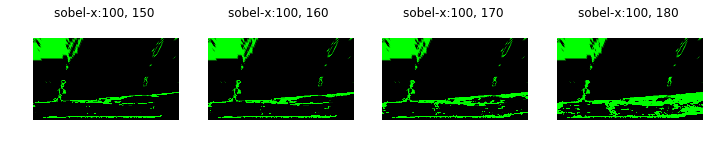

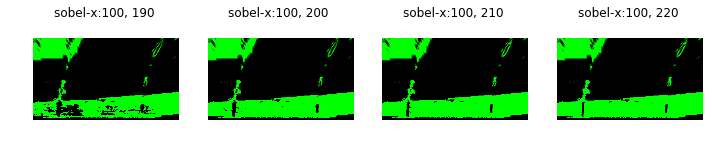

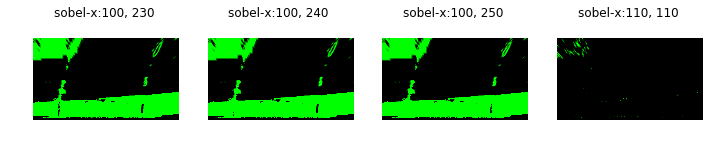

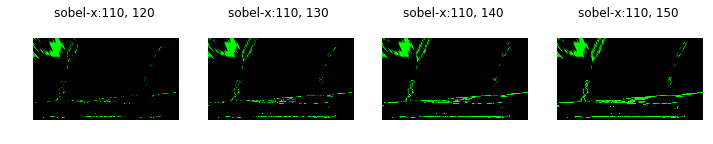

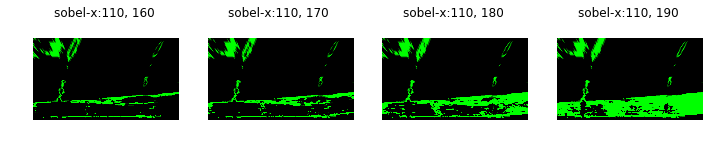

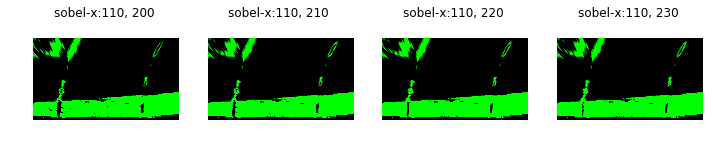

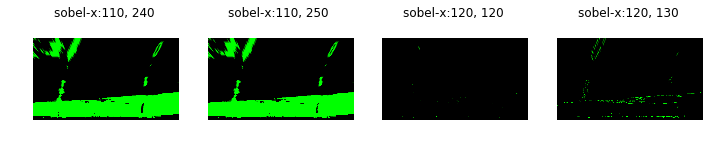

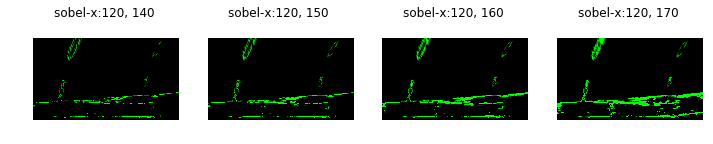

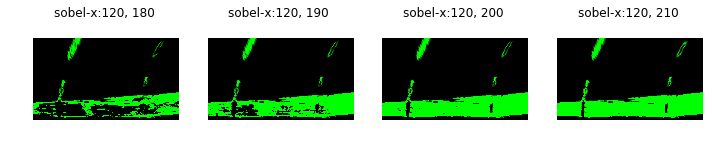

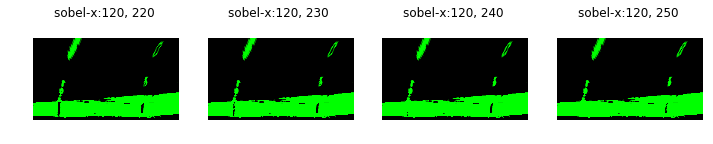

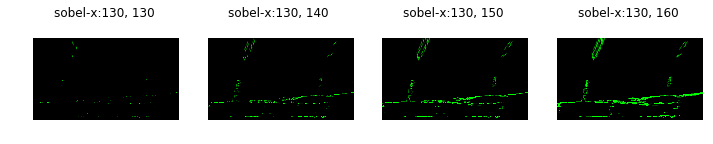

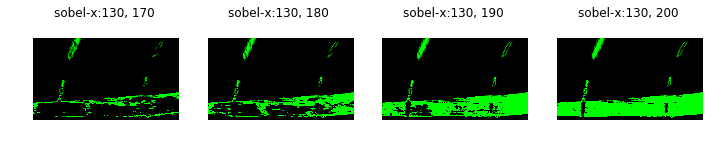

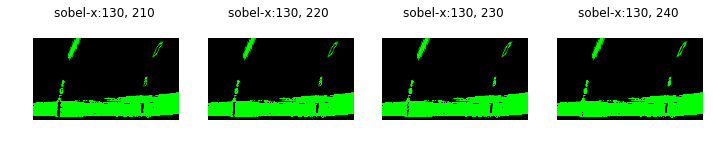

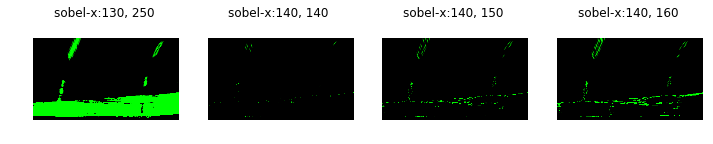

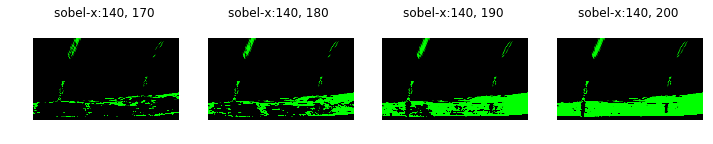

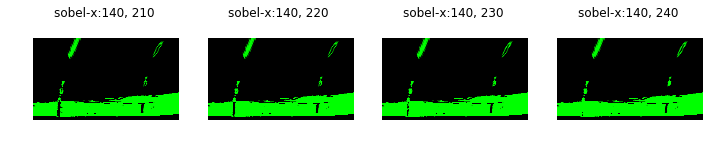

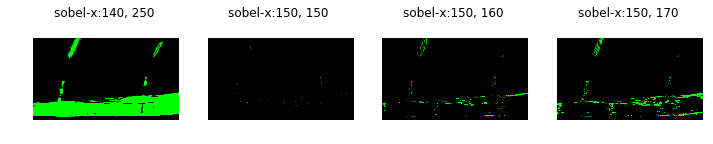

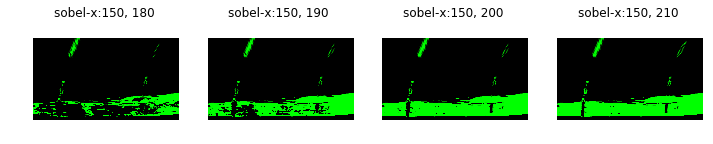

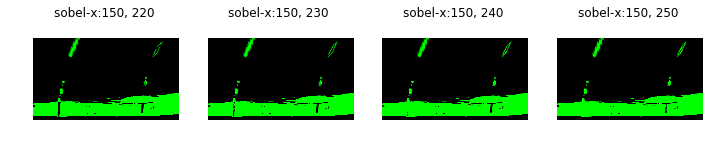

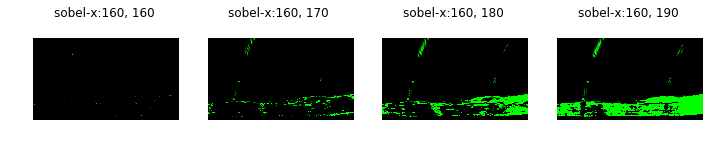

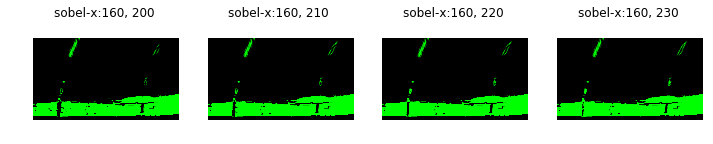

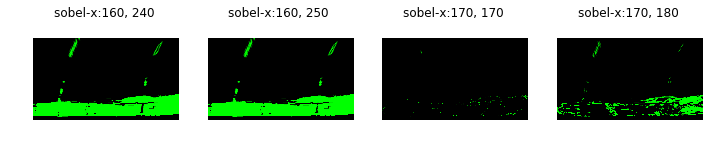

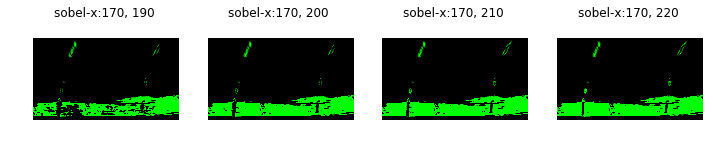

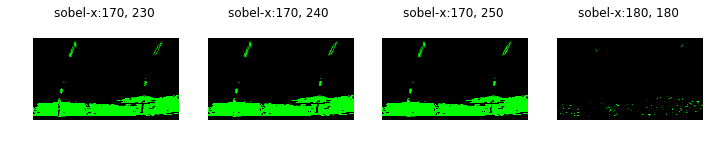

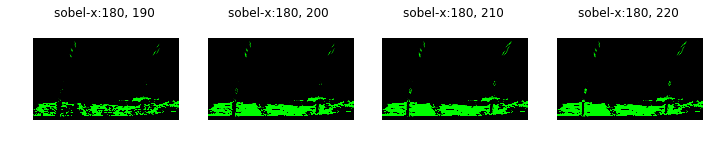

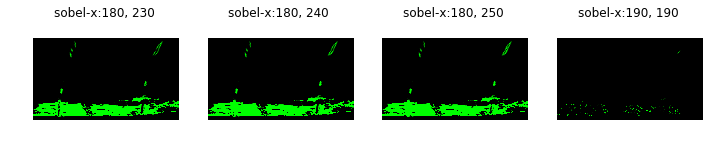

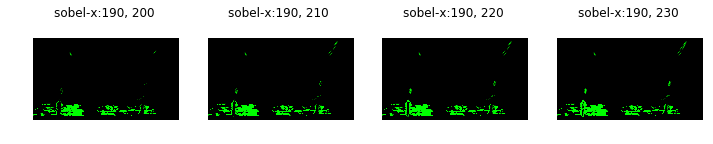

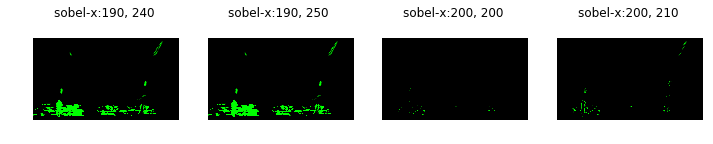

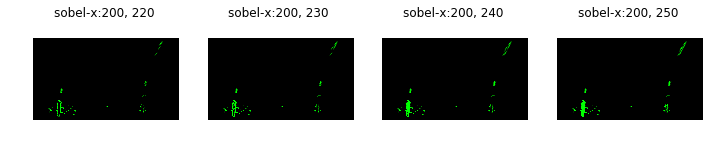

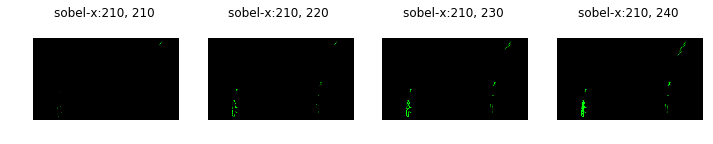

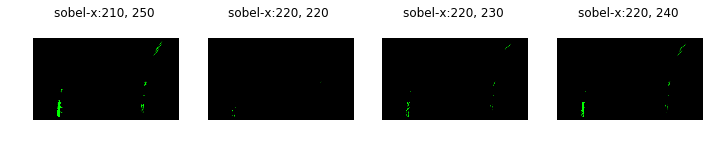

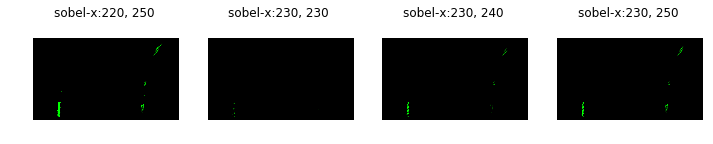

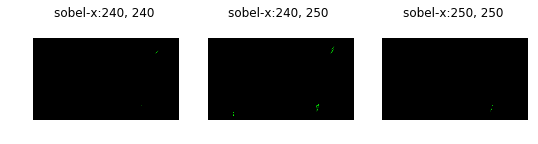

In [13]:
thresholds= []
for i in range(0,255,10):
    for j in range(0,255,10):
        if i>j:
            continue
        thresholds.append((i,j))
        
img  = mpimg.imread('./test_images/test5.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
V = hsv[:,:,2]

printLotsOfThresholds(V, thresholds, 4,FIGSIZE = (12,12))

## R in RGB

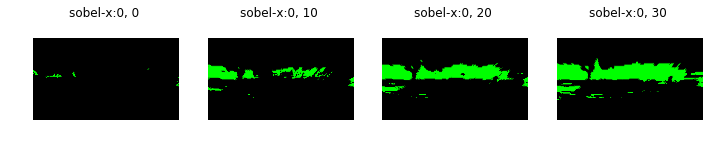

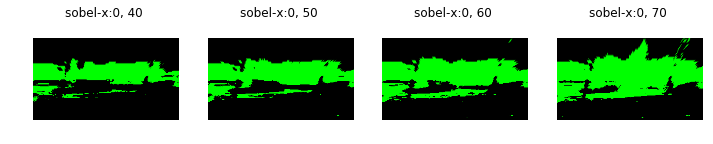

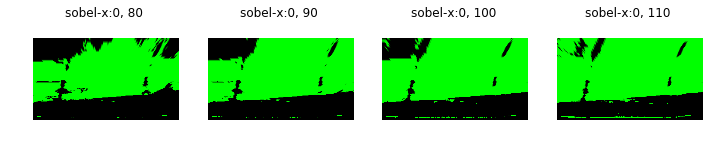

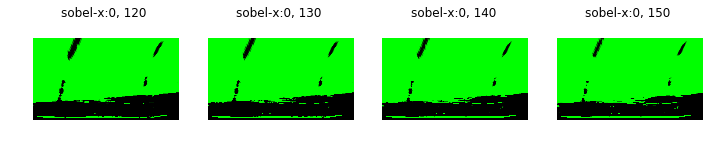

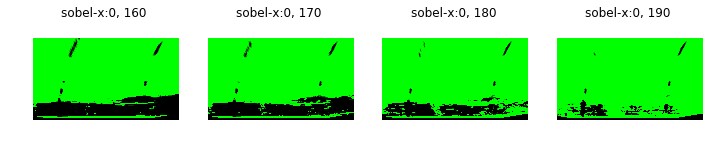

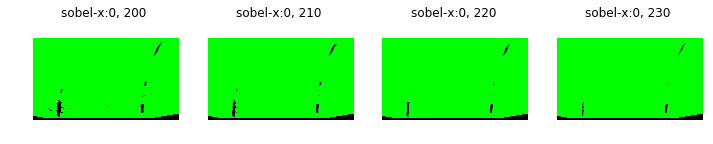

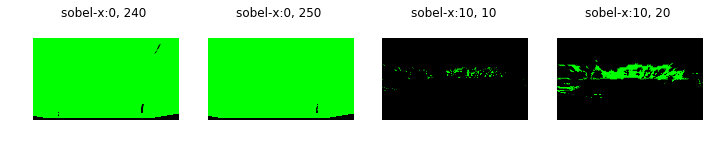

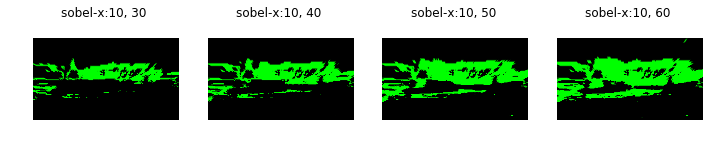

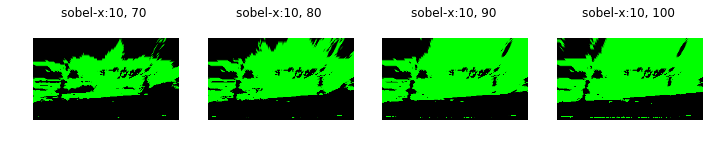

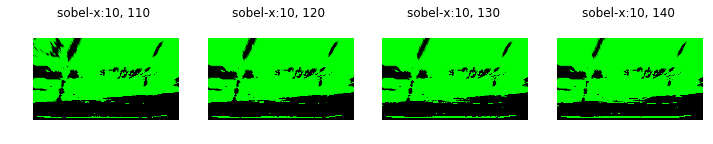

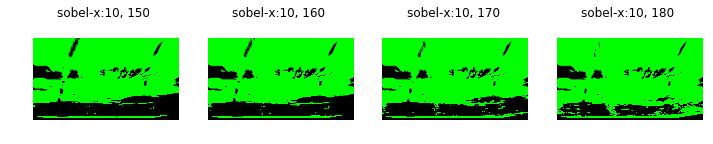

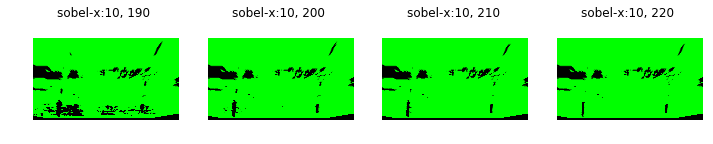

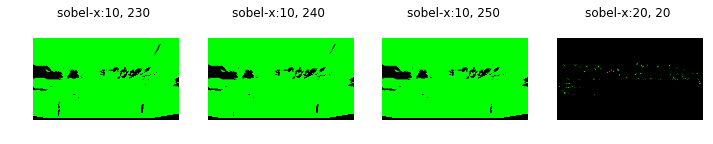

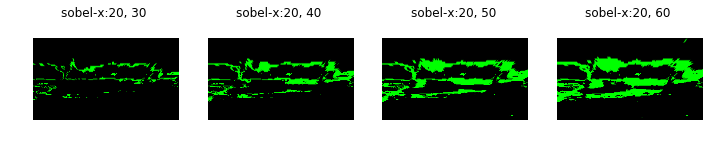

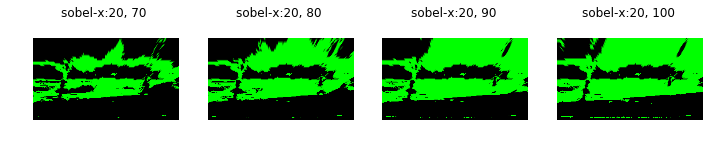

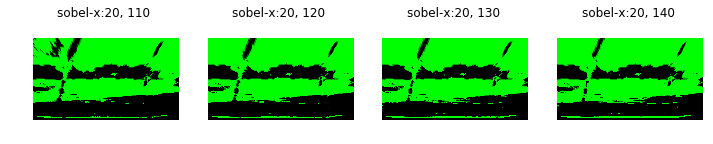

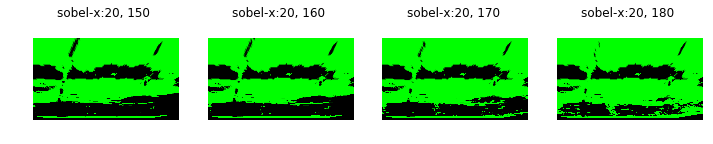

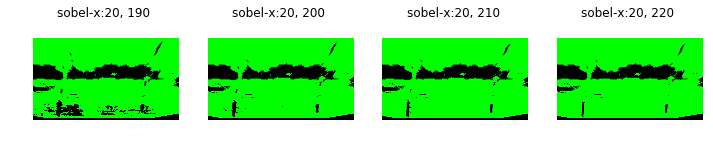

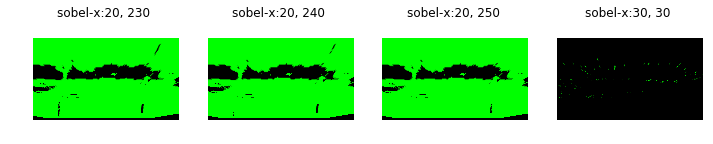

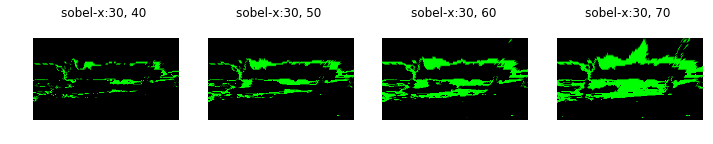

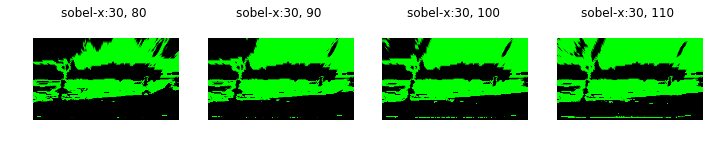

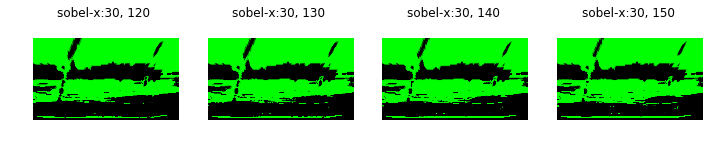

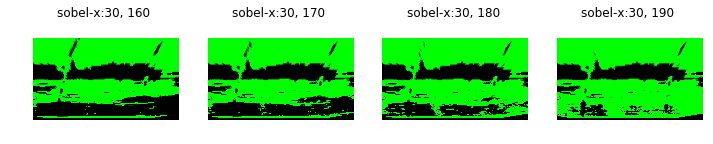

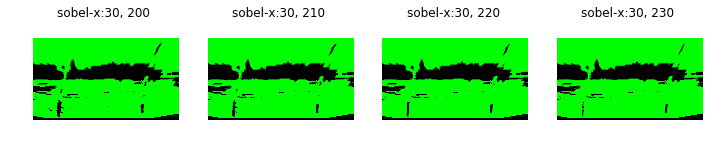

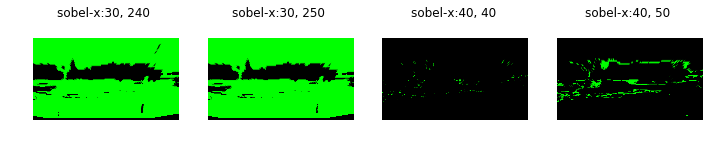

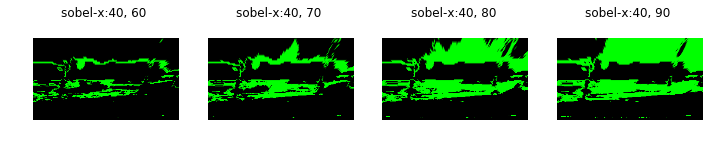

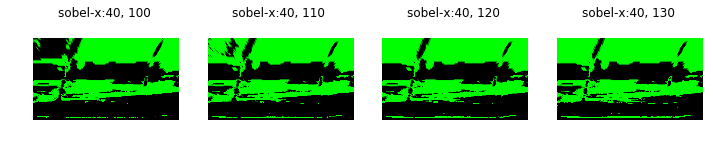

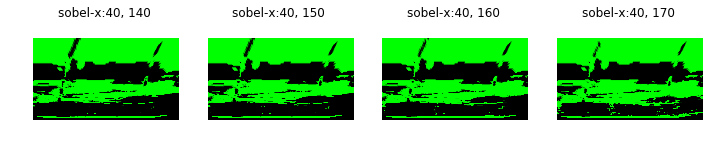

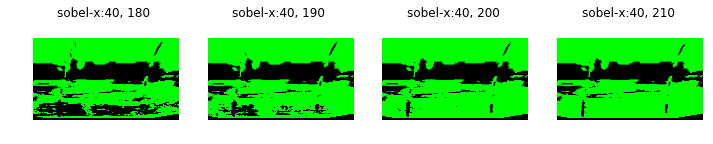

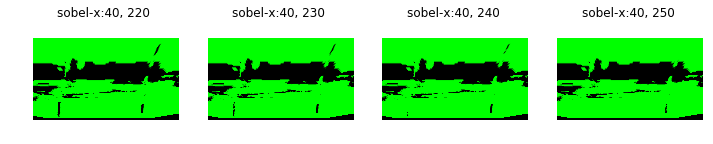

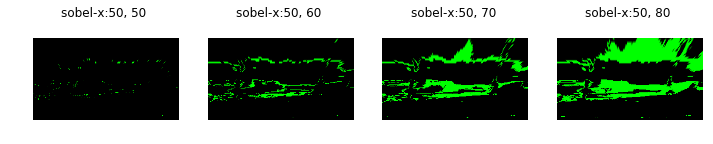

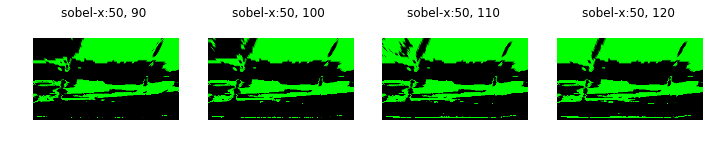

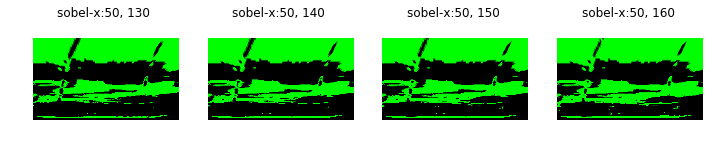

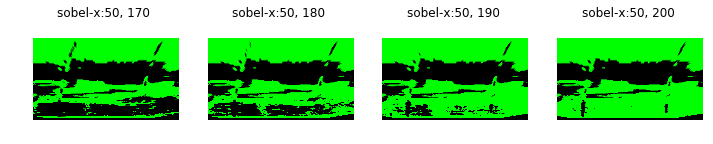

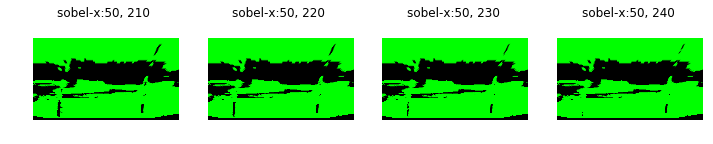

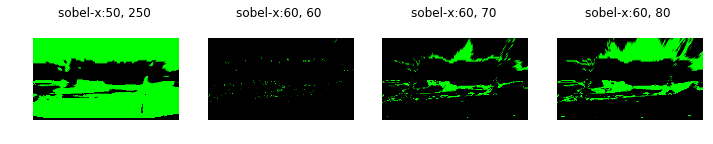

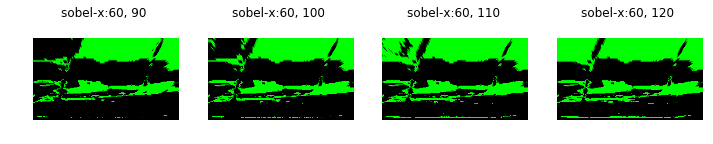

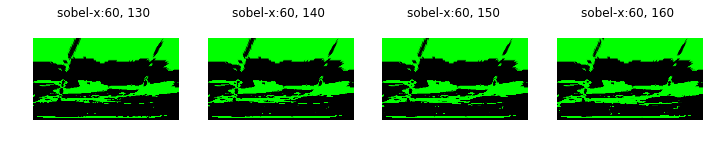

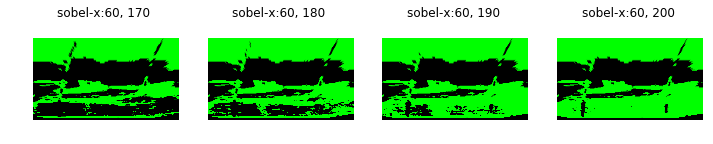

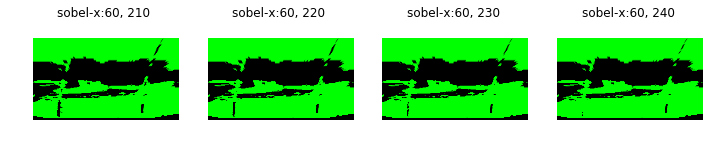

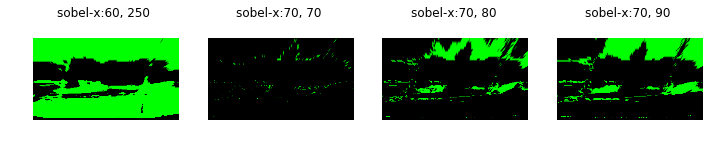

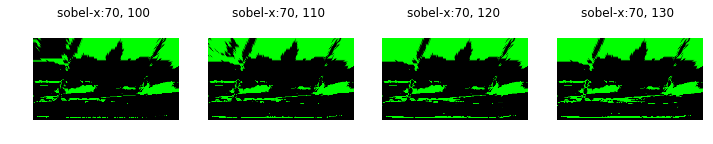

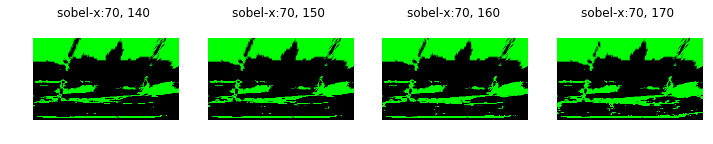

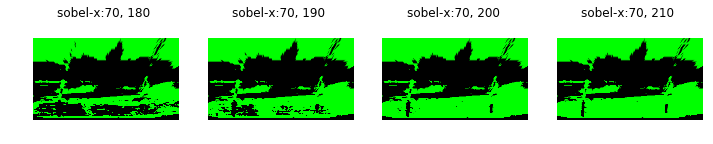

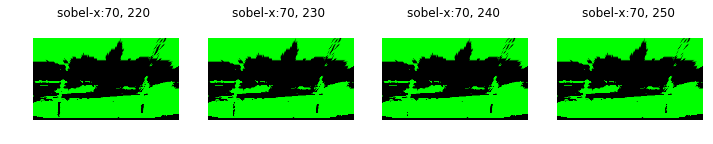

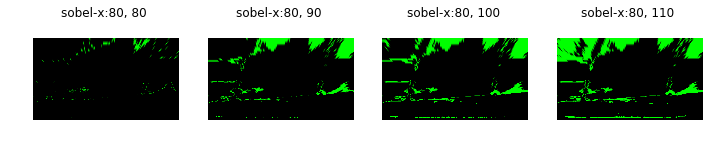

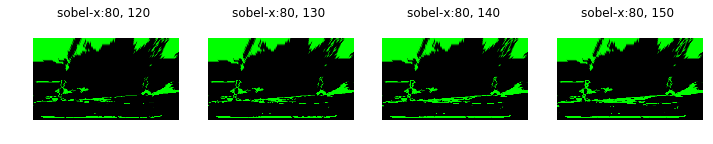

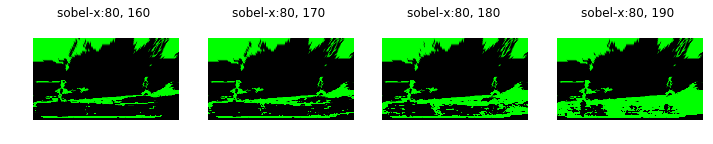

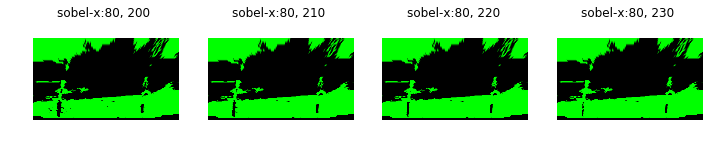

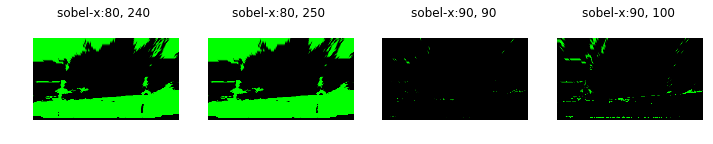

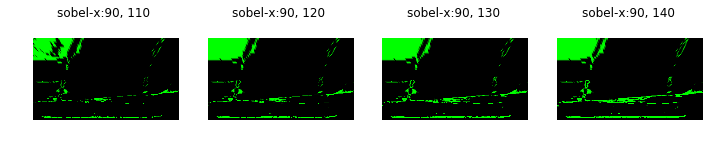

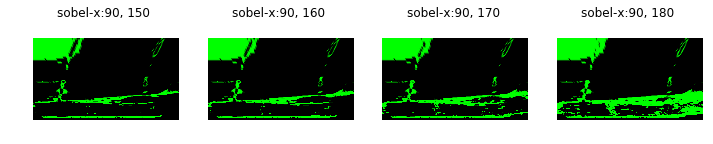

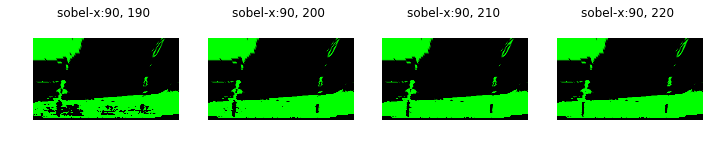

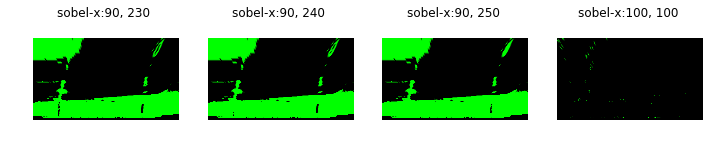

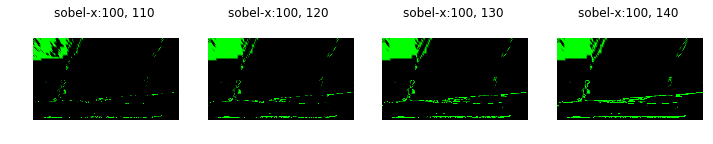

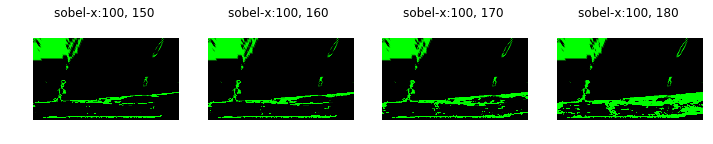

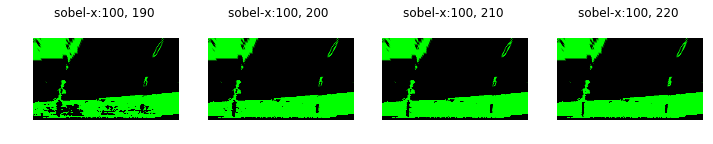

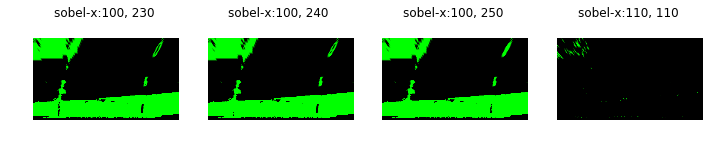

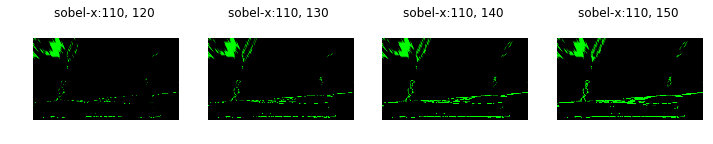

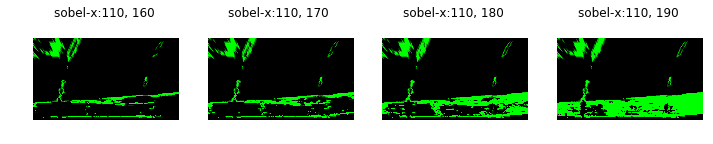

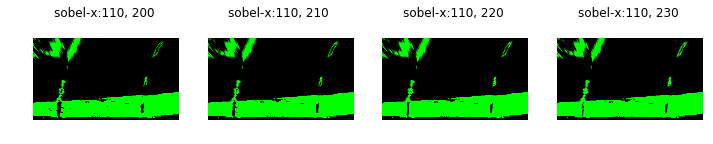

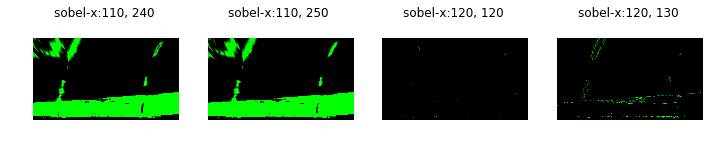

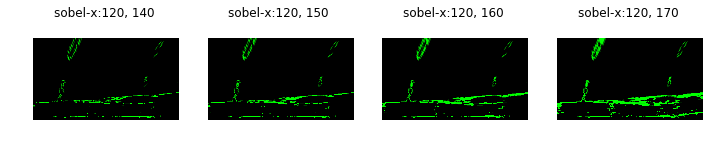

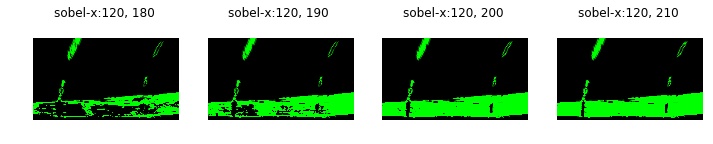

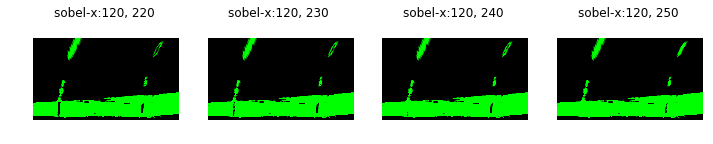

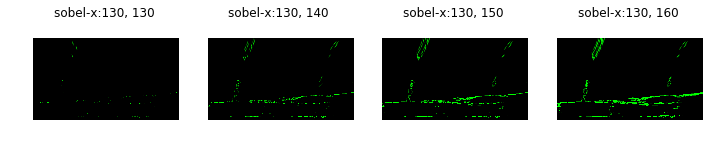

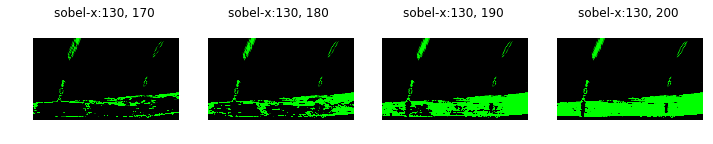

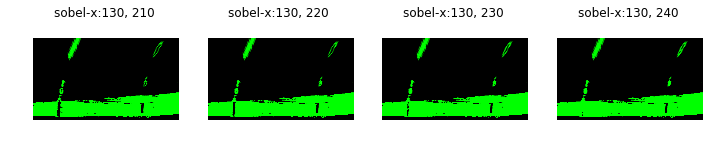

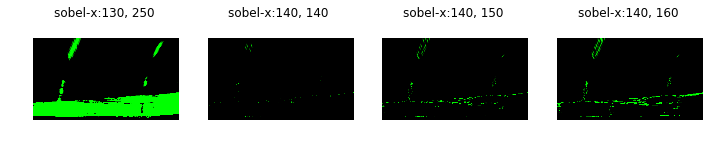

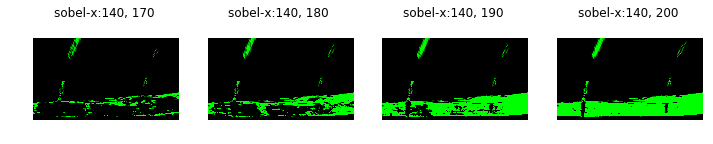

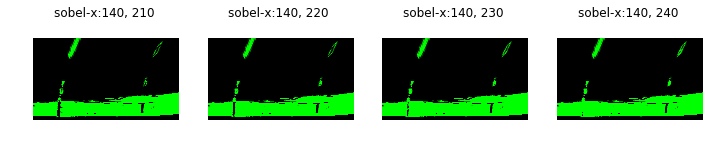

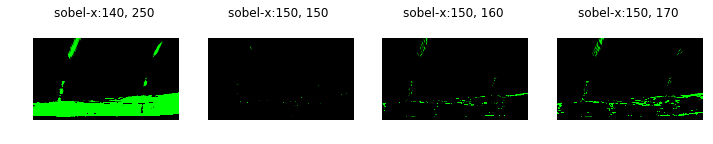

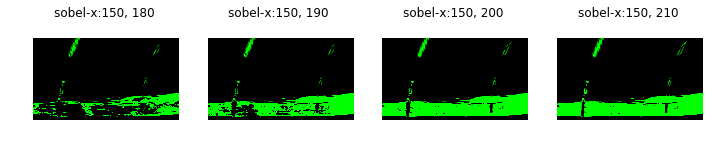

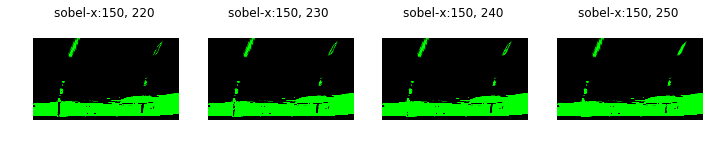

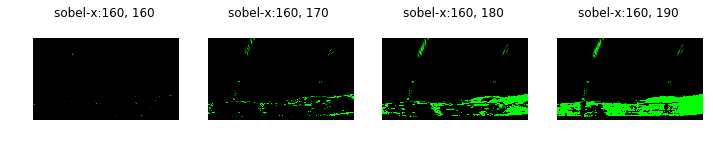

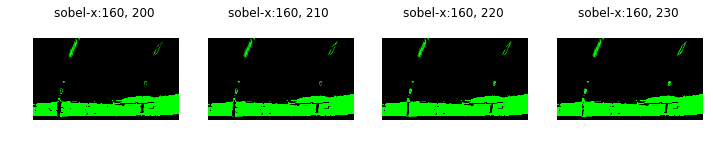

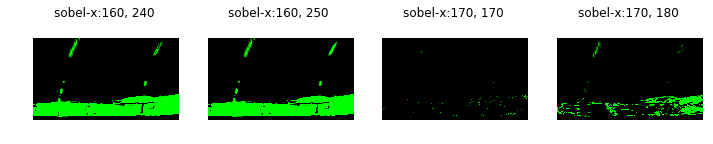

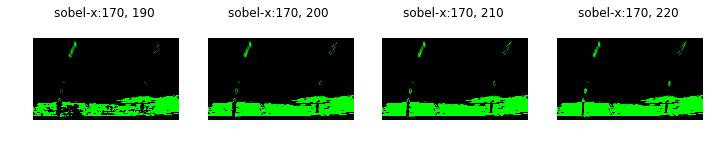

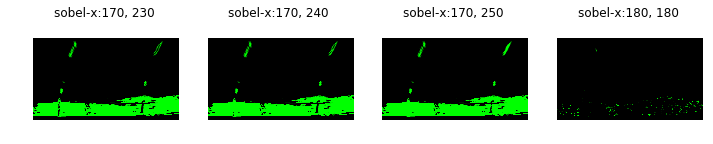

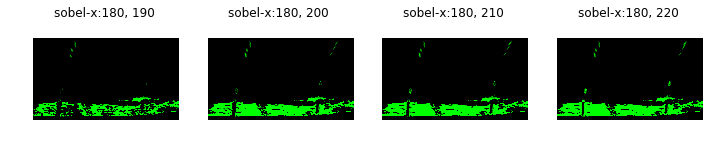

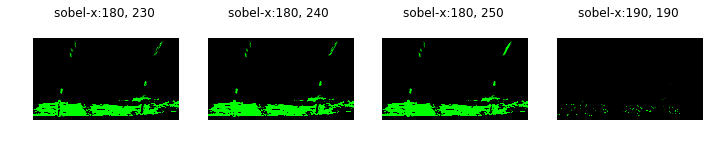

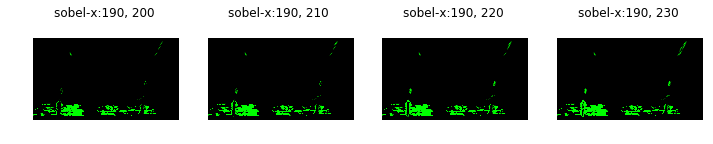

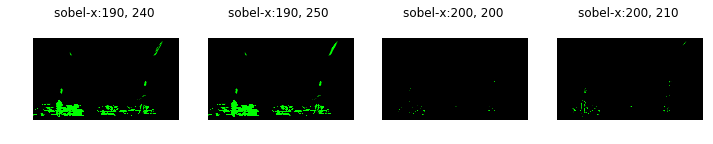

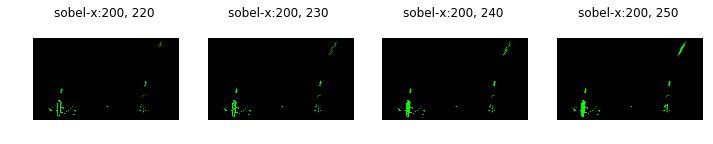

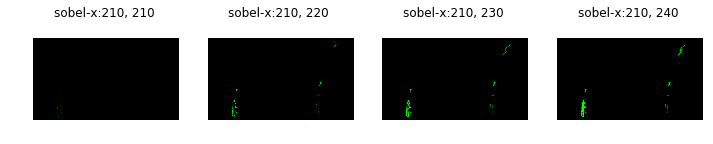

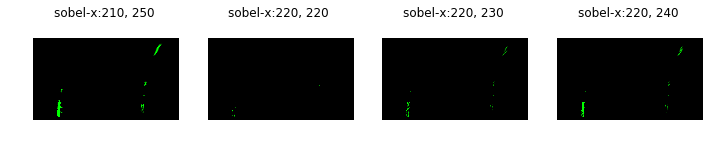

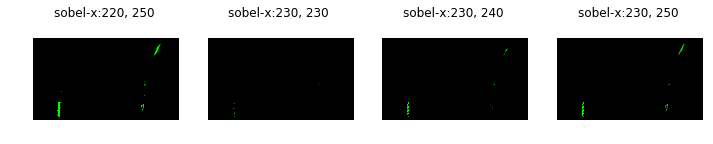

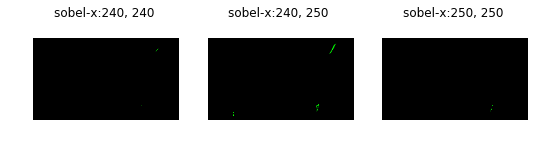

In [14]:
thresholds= []
for i in range(0,255,10):
    for j in range(0,255,10):
        if i>j:
            continue
        thresholds.append((i,j))
        
img  = mpimg.imread('./test_images/test5.jpg')
#hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
R = img[:,:,0]

printLotsOfThresholds(R, thresholds, 4,FIGSIZE = (12,12))

## G in RGB

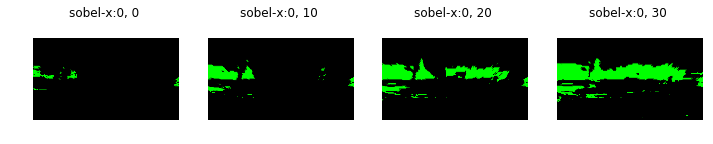

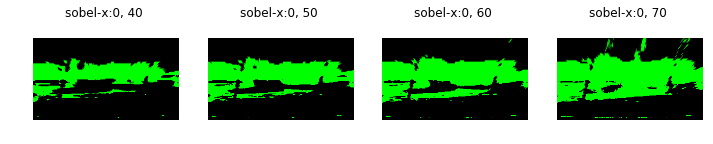

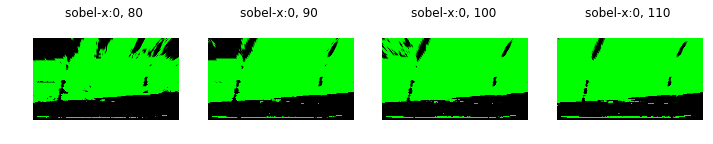

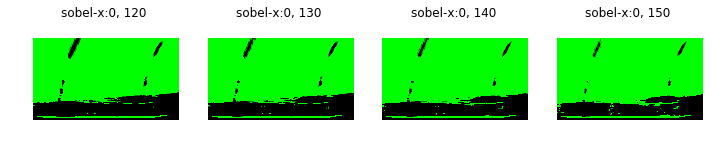

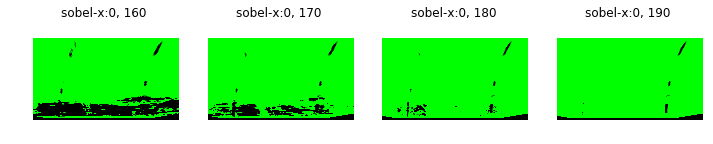

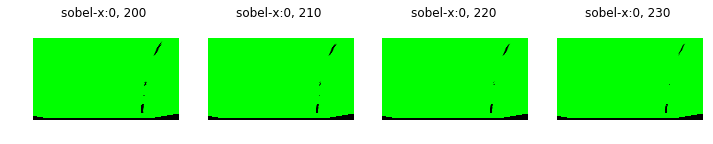

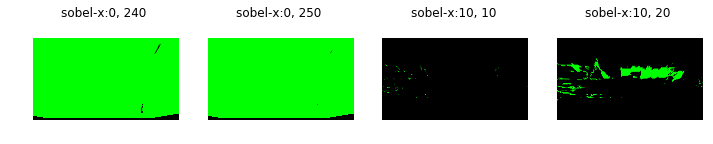

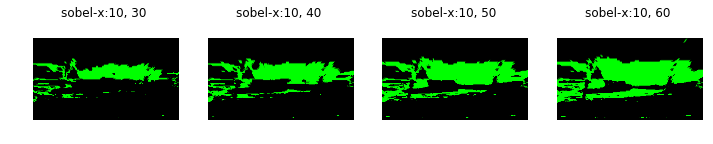

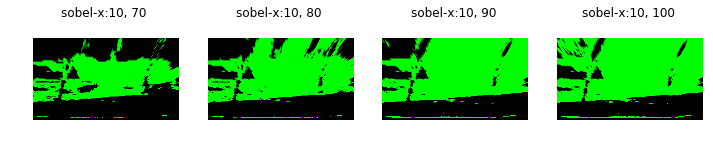

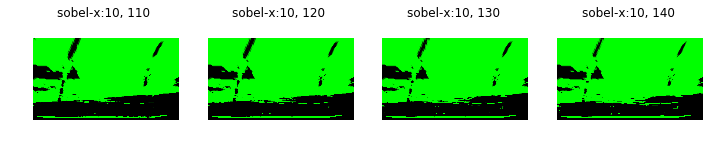

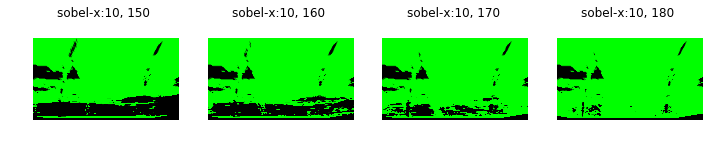

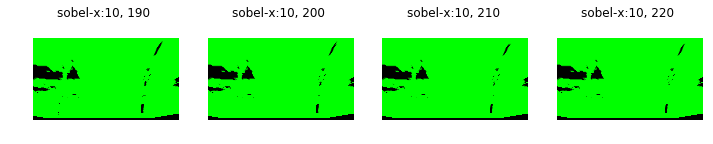

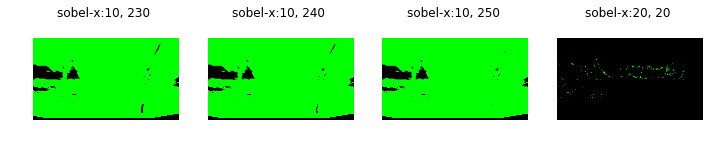

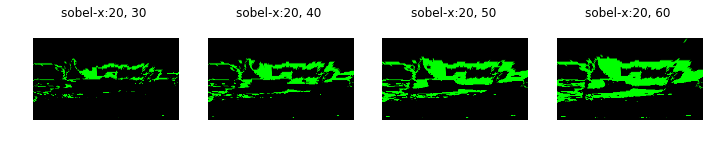

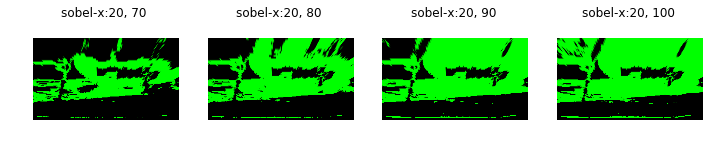

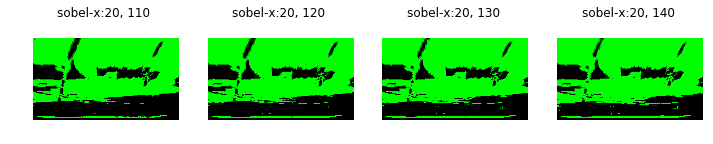

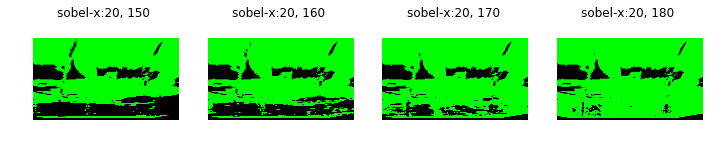

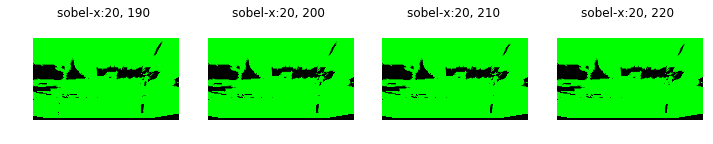

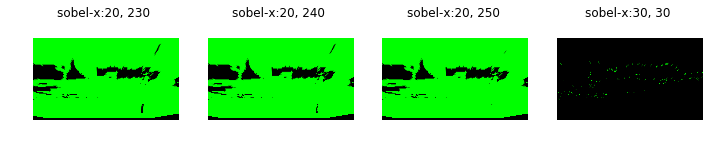

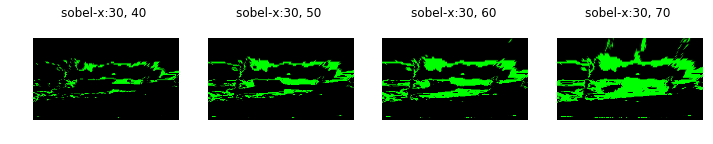

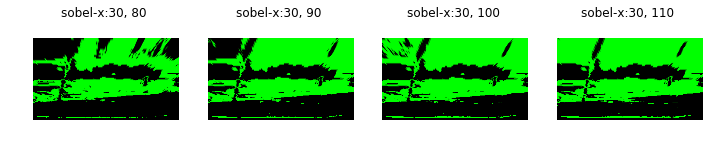

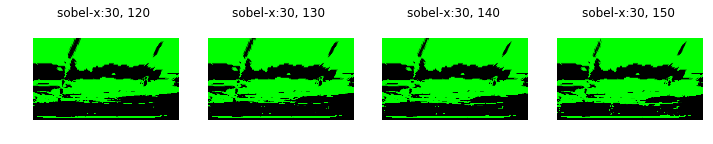

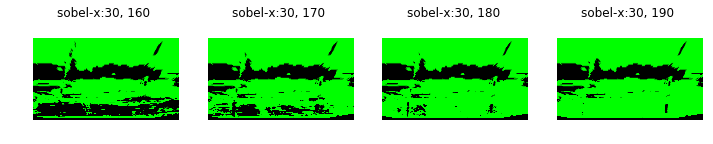

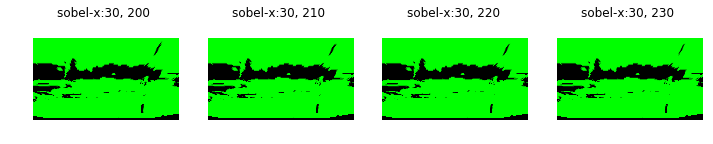

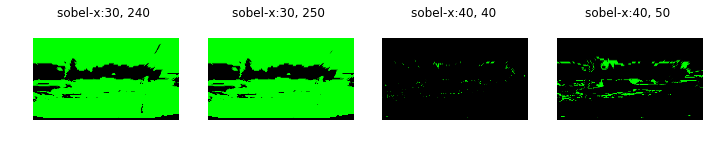

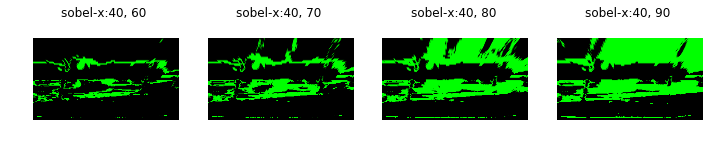

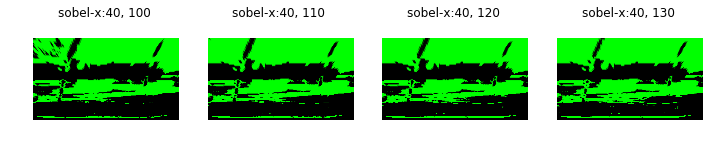

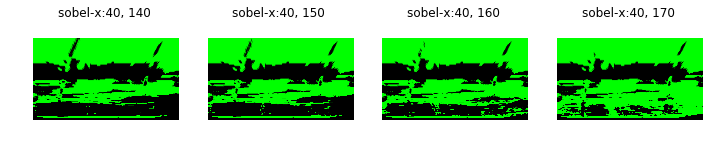

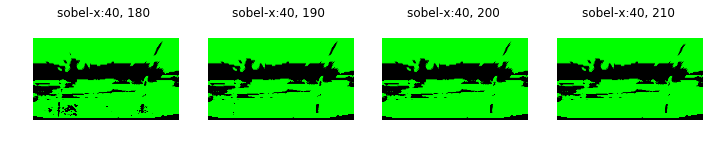

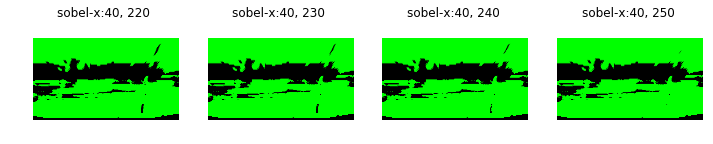

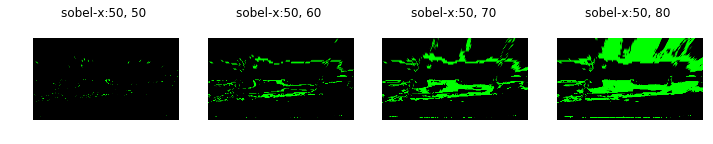

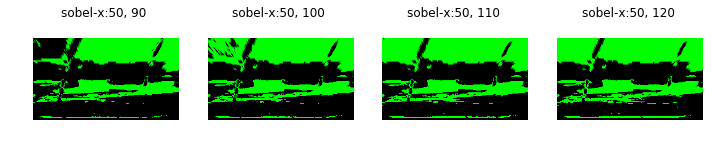

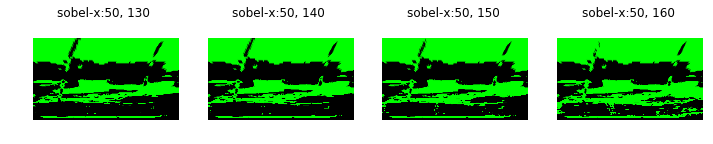

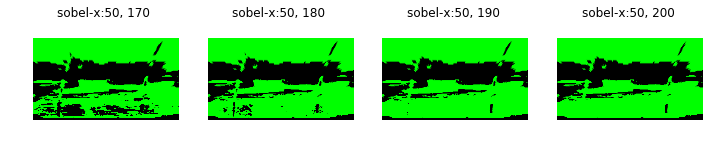

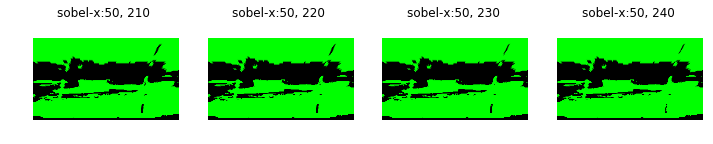

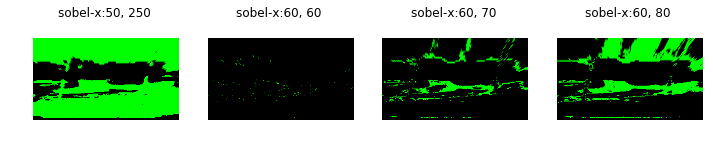

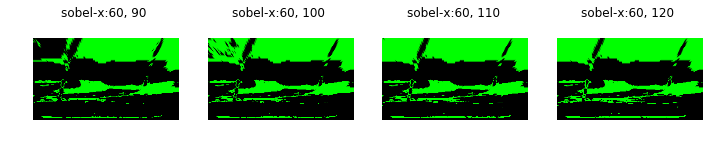

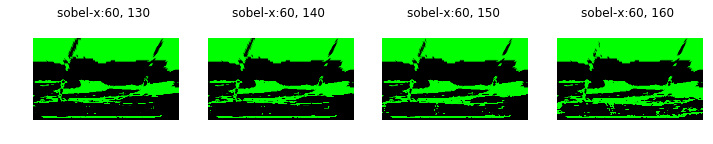

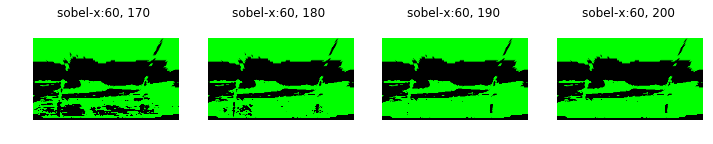

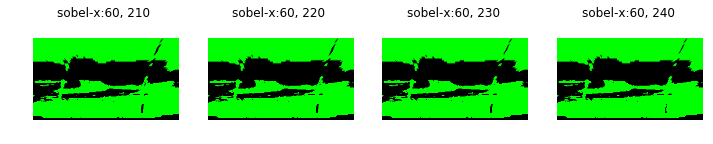

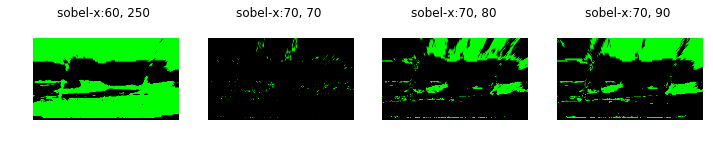

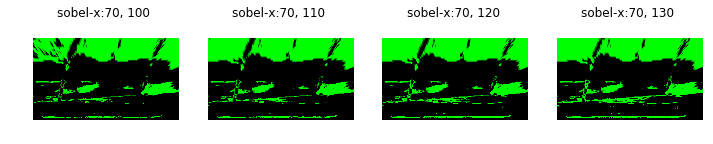

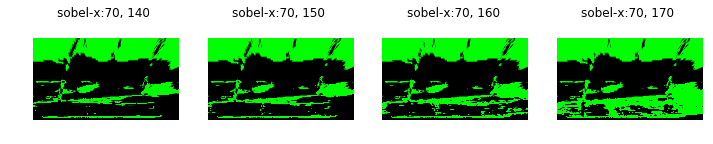

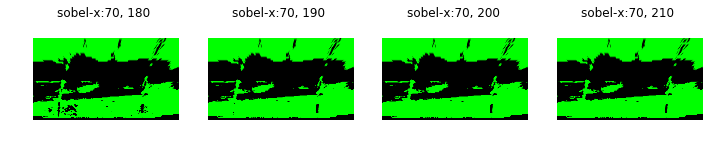

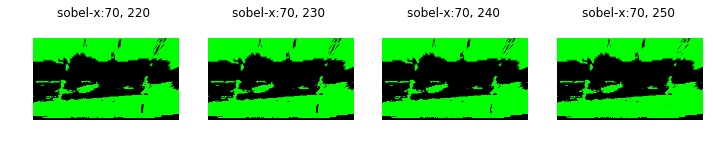

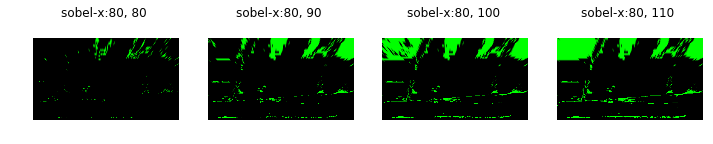

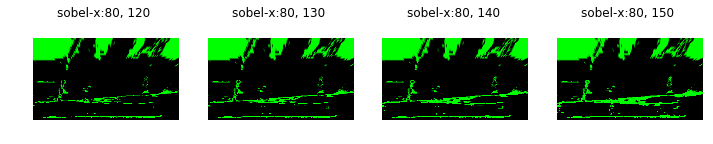

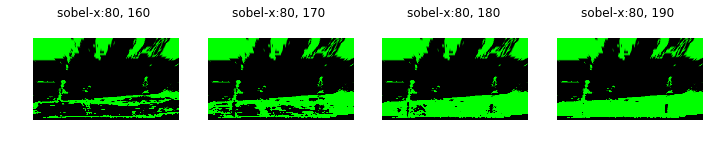

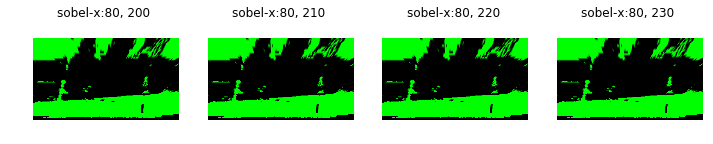

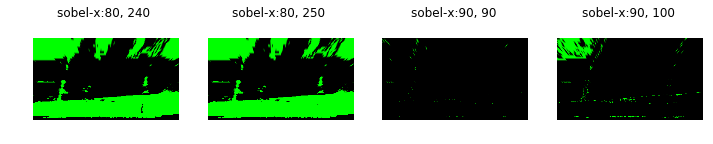

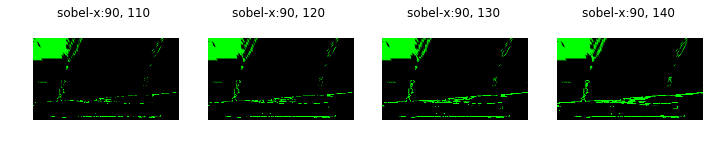

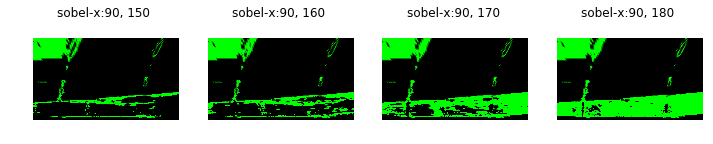

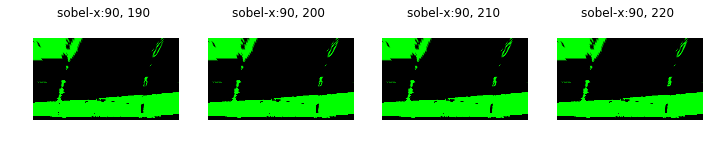

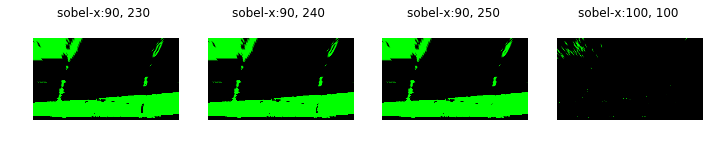

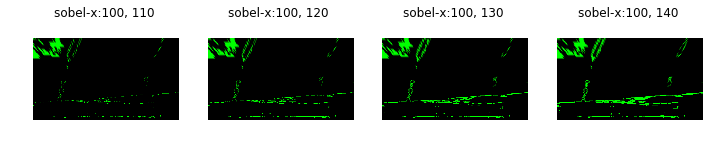

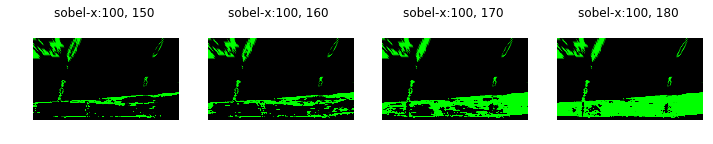

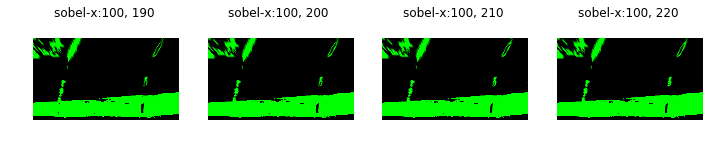

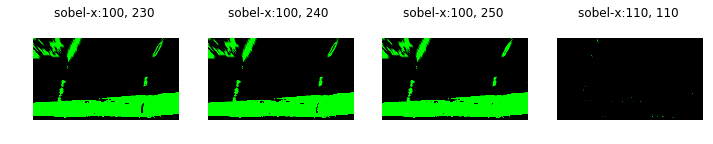

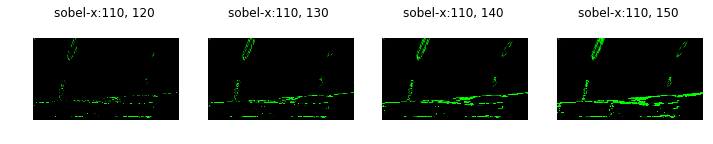

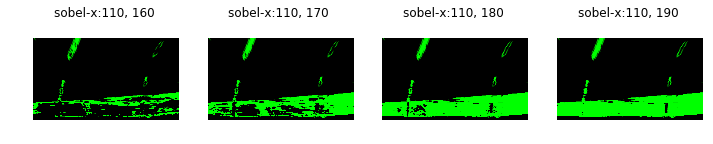

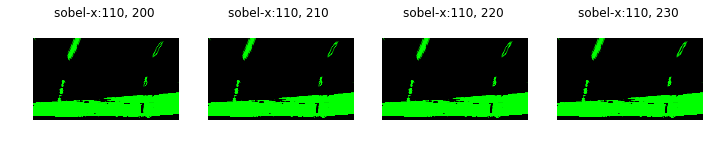

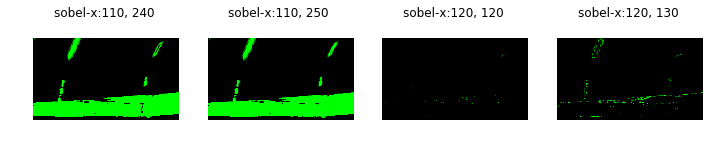

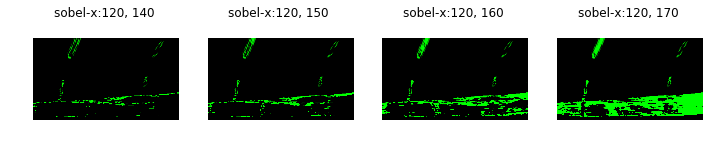

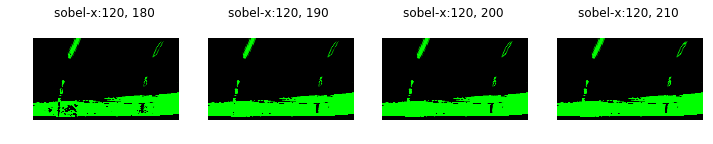

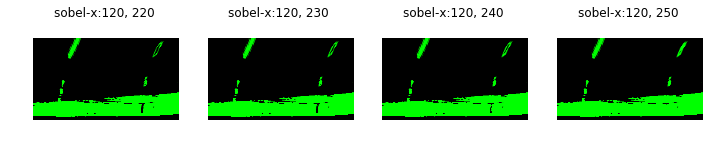

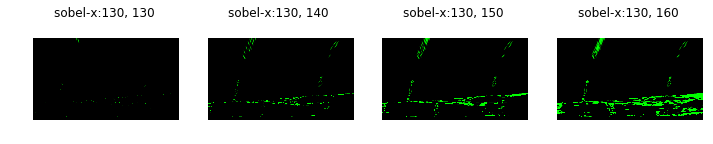

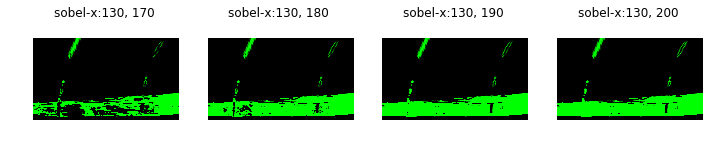

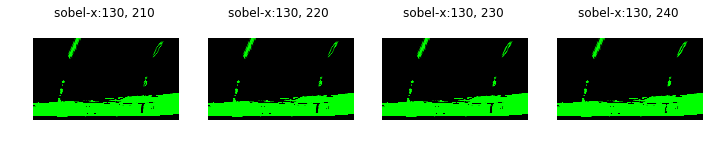

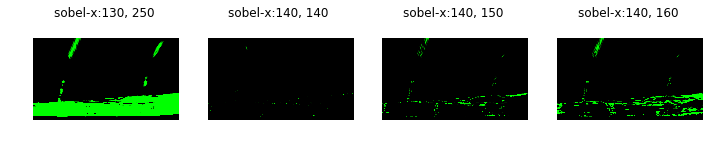

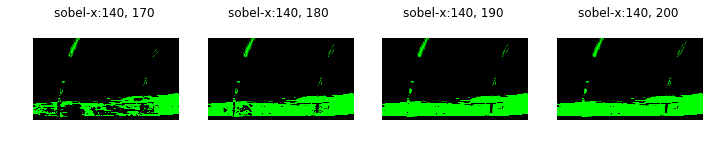

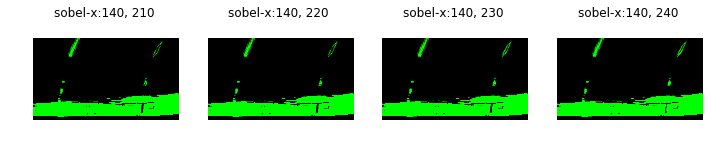

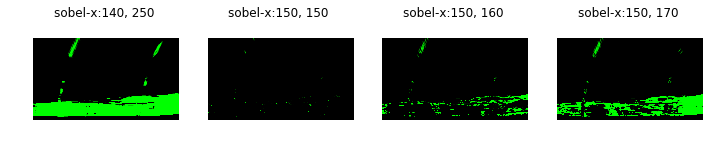

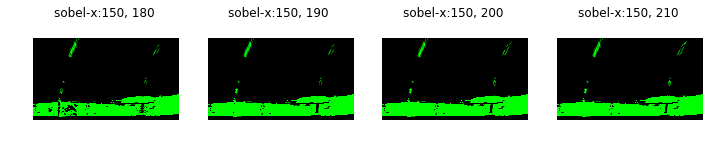

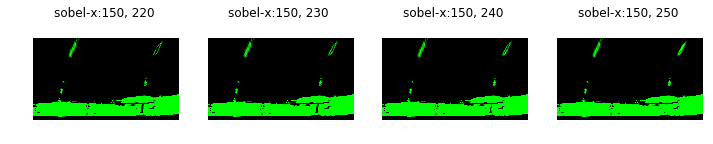

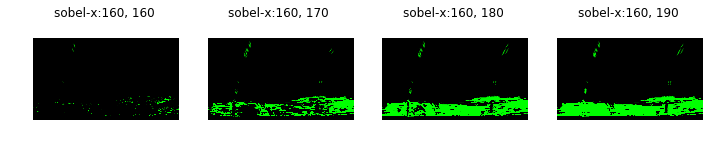

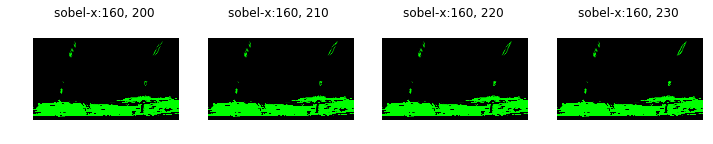

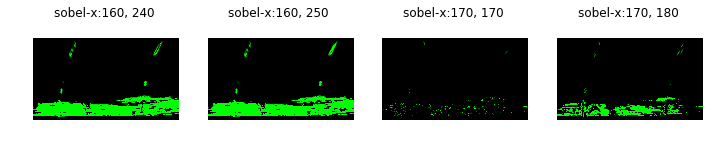

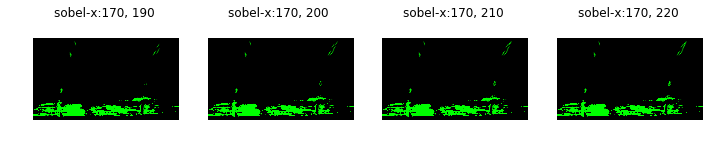

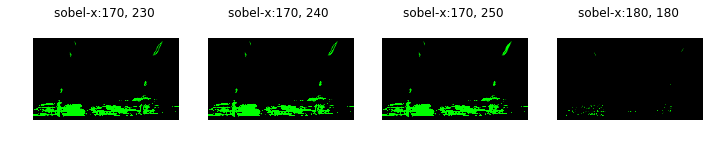

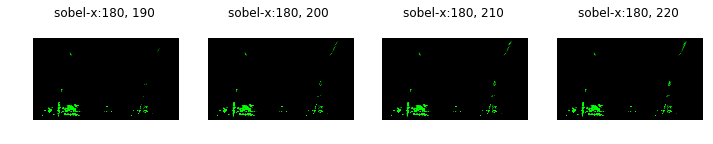

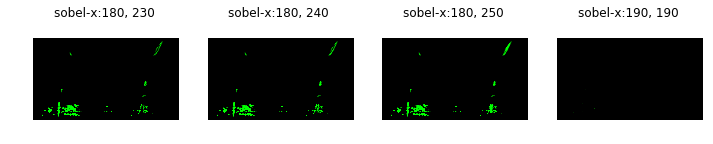

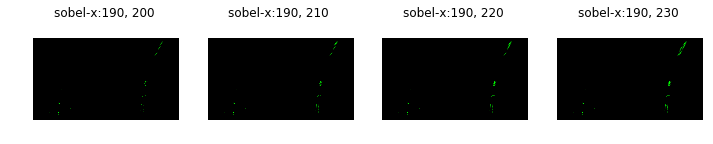

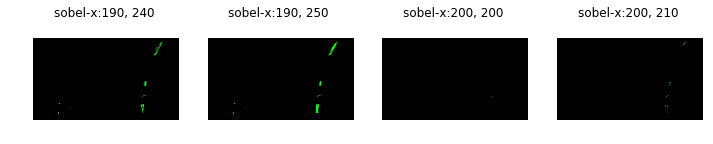

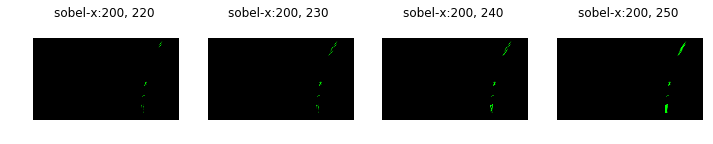

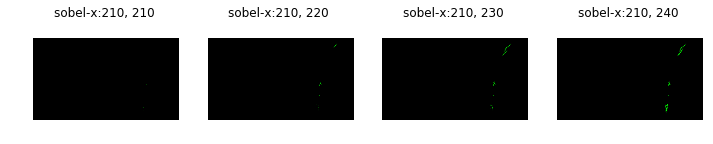

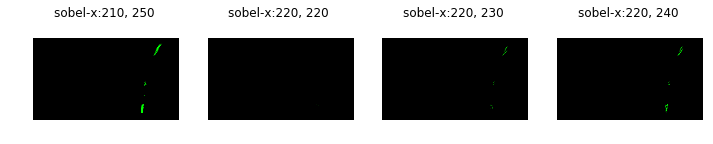

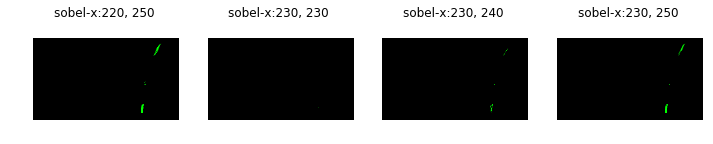

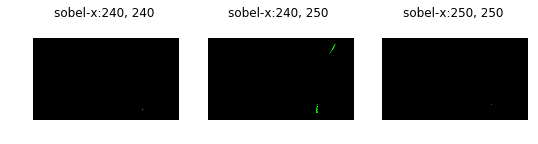

In [15]:
G = img[:,:,1]

printLotsOfThresholds(G, thresholds, 4,FIGSIZE = (12,12))

## B in RGB

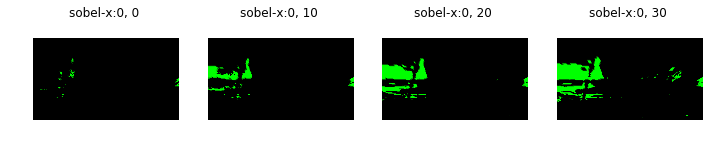

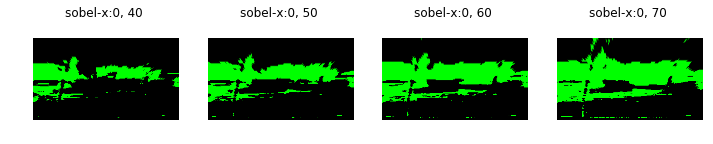

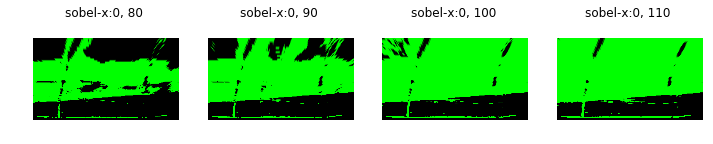

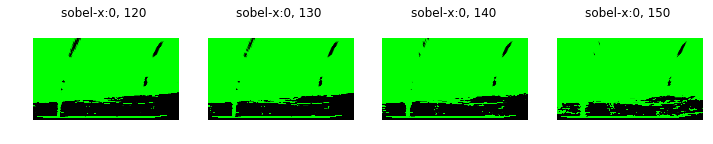

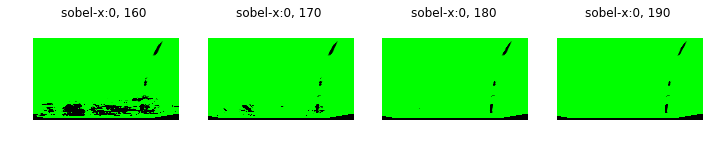

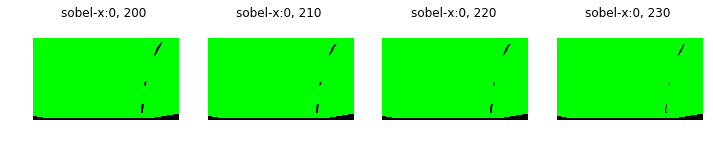

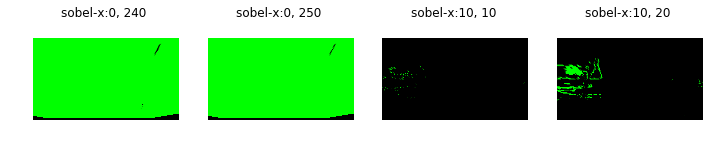

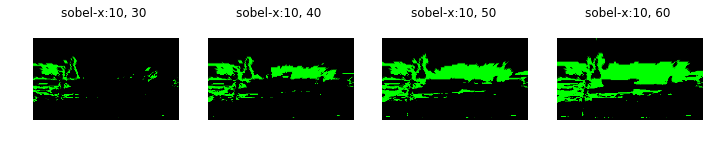

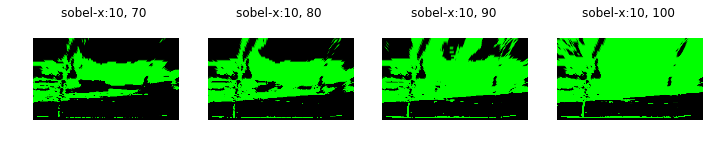

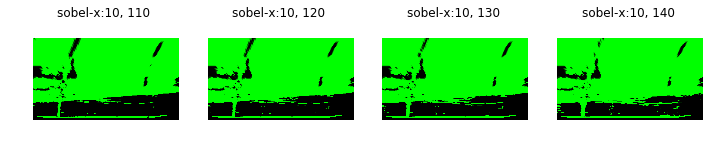

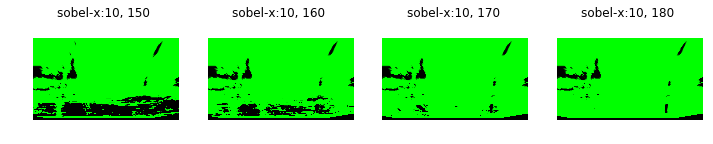

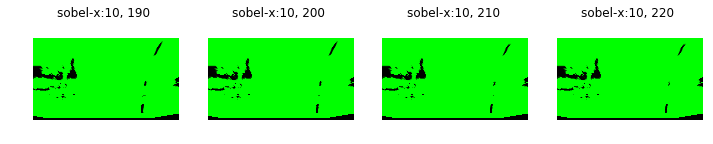

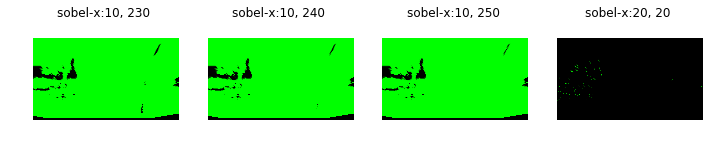

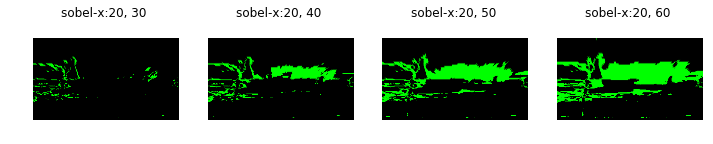

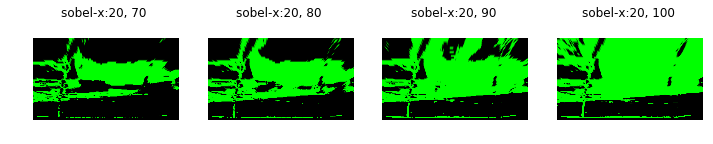

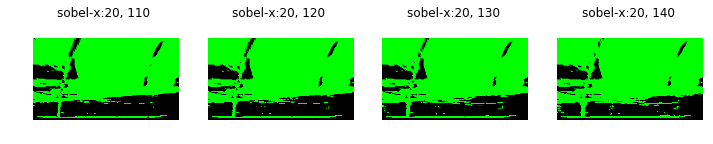

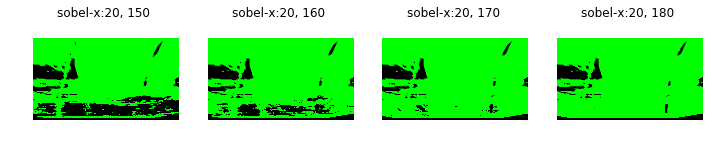

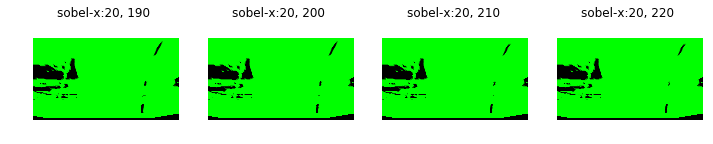

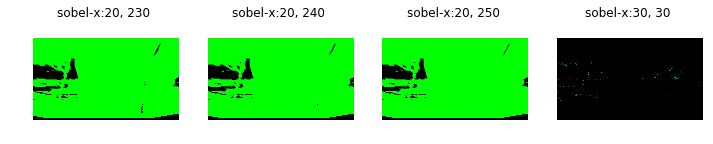

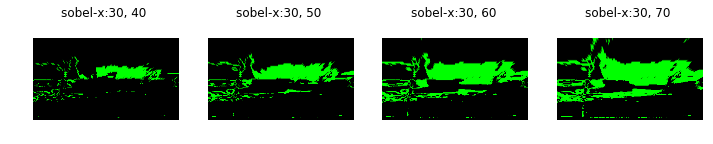

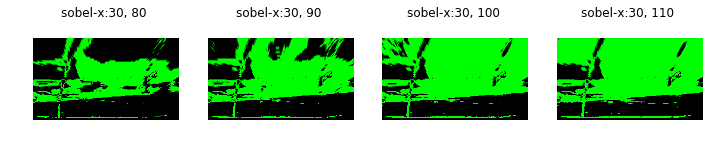

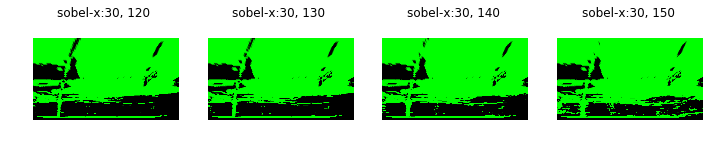

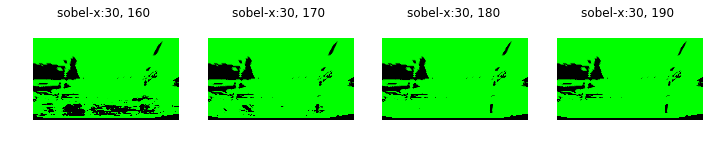

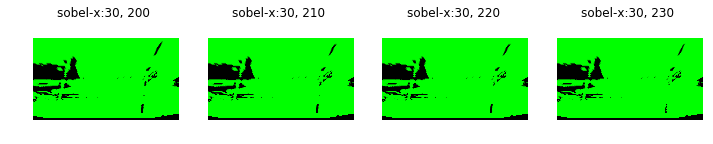

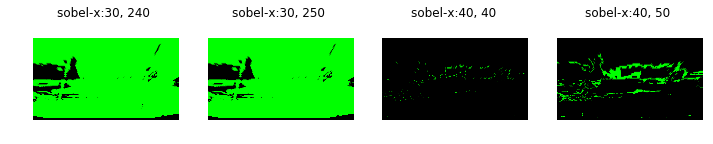

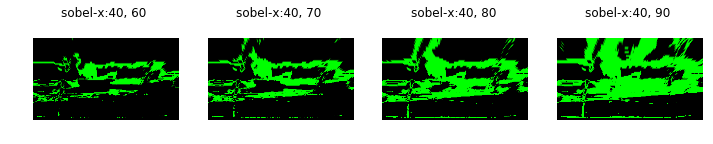

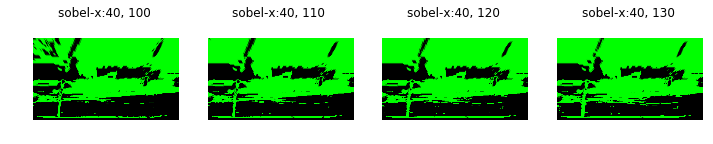

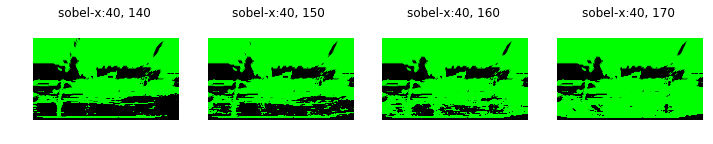

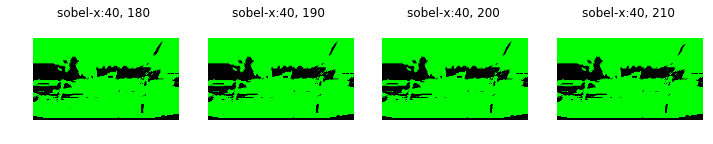

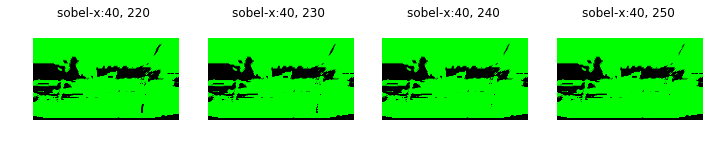

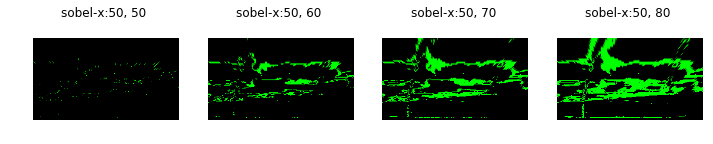

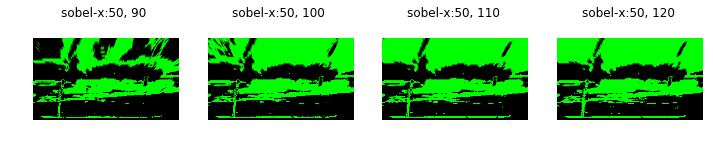

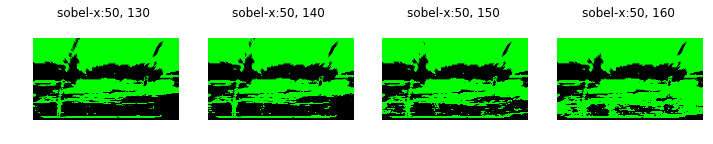

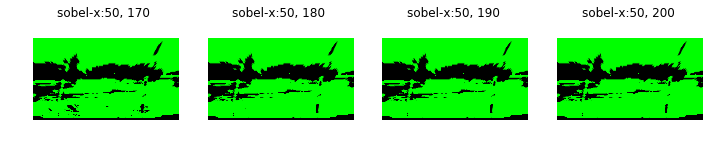

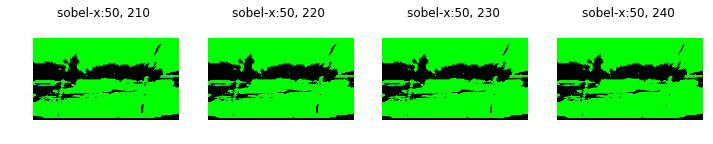

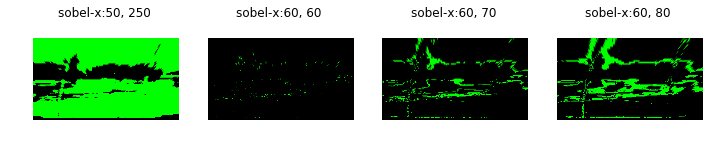

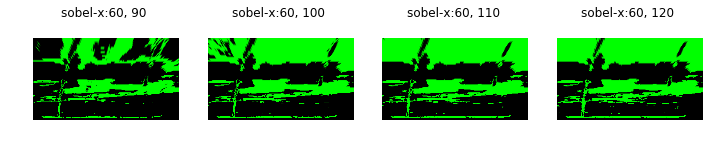

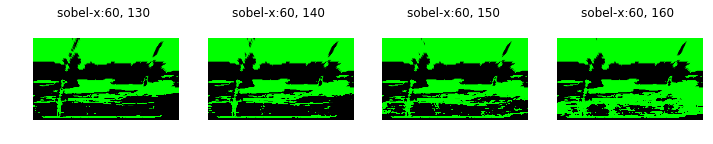

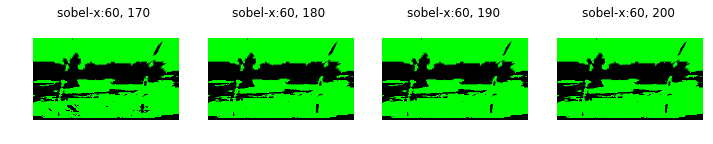

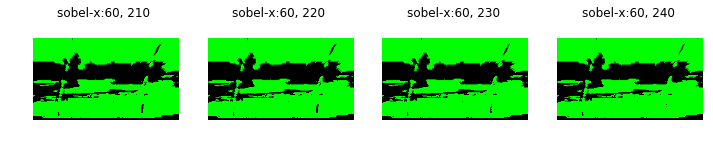

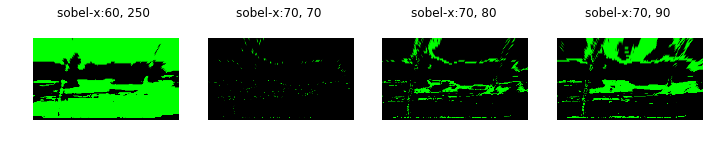

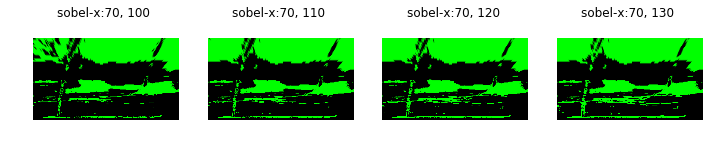

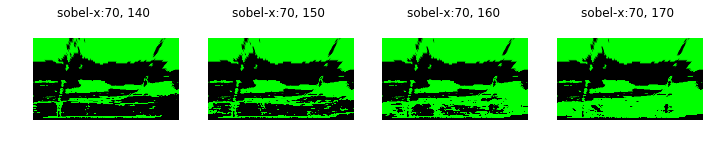

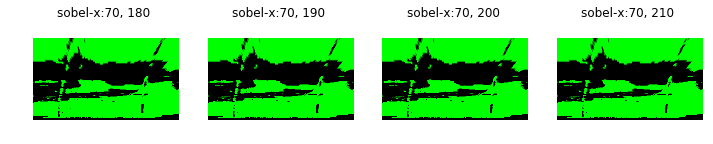

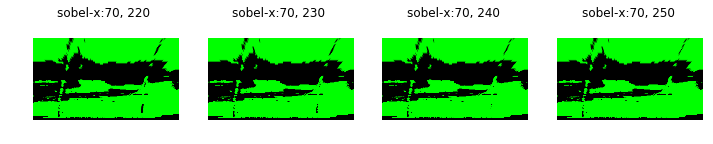

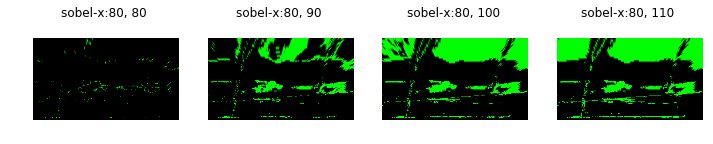

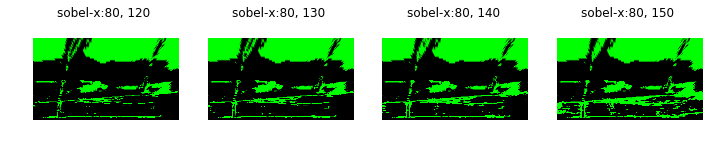

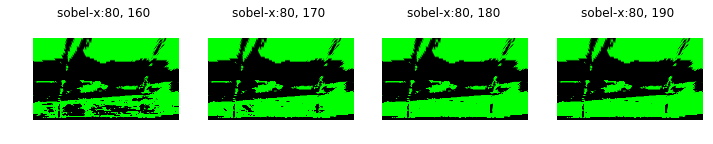

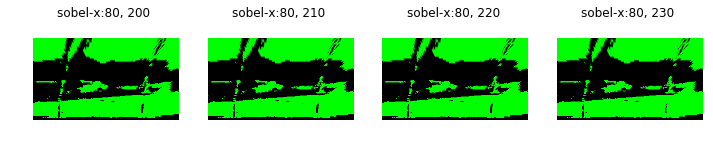

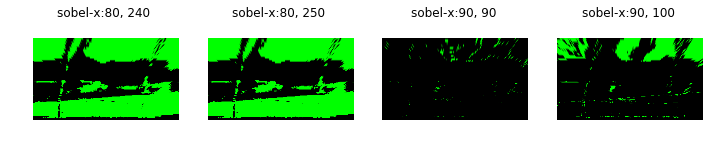

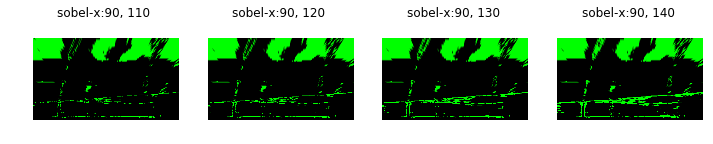

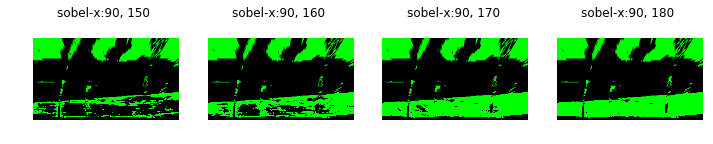

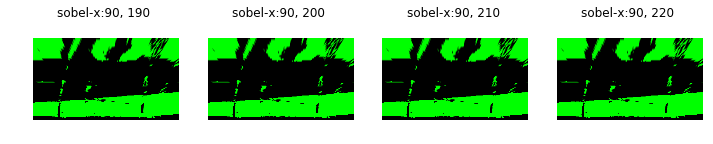

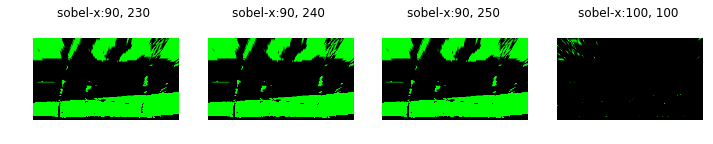

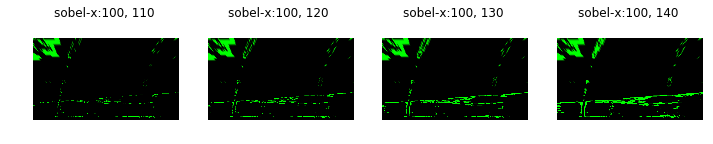

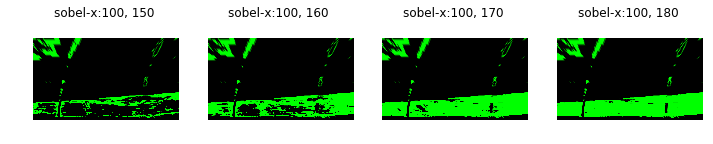

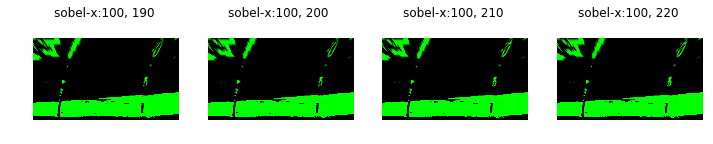

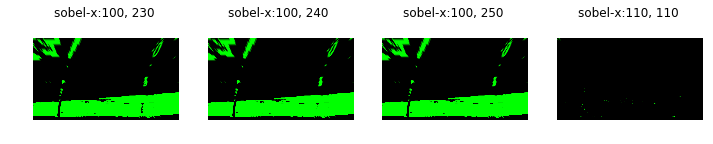

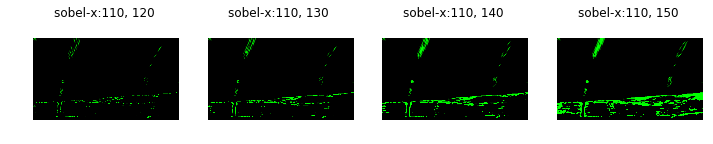

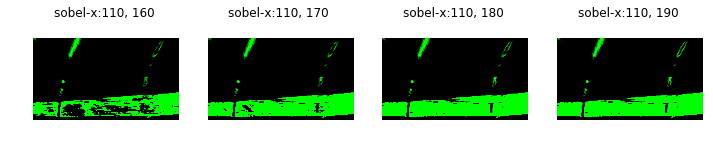

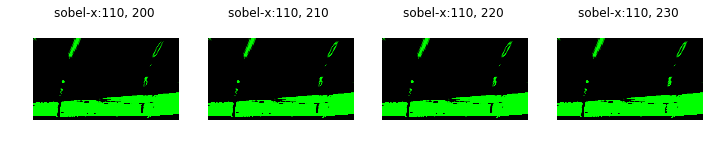

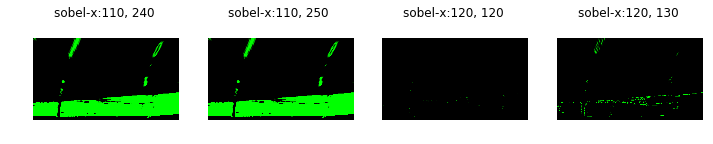

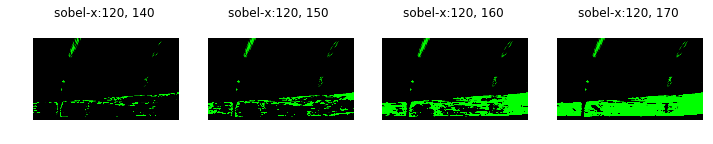

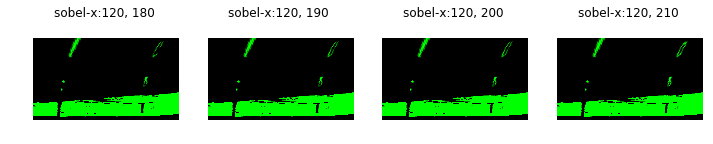

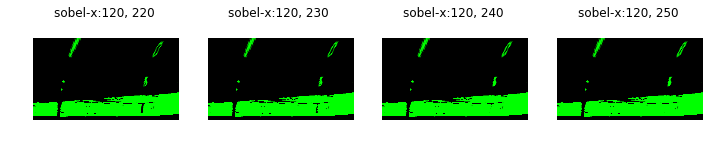

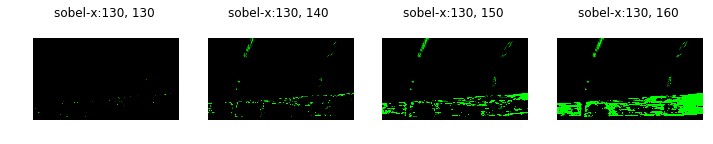

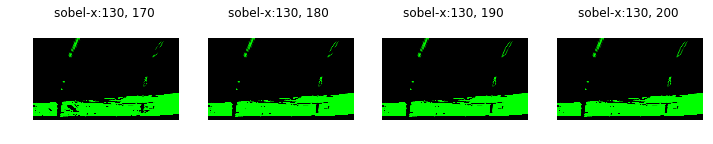

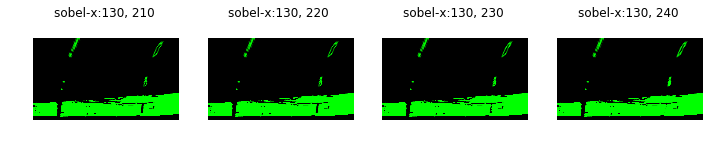

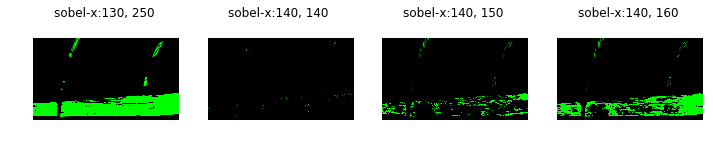

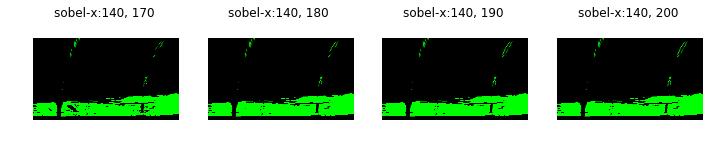

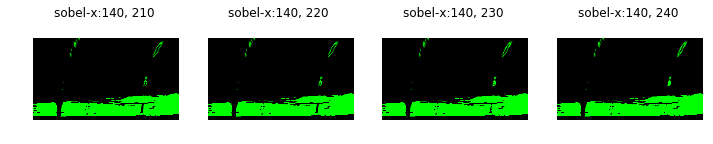

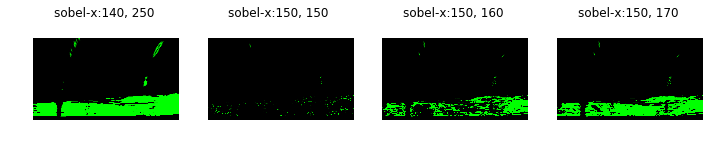

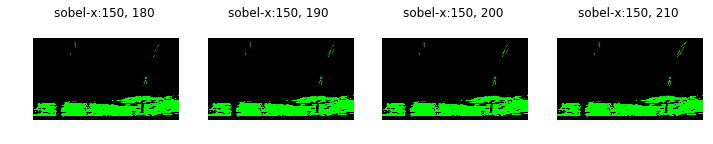

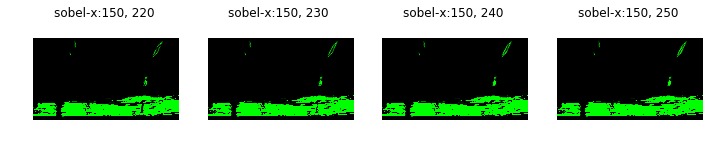

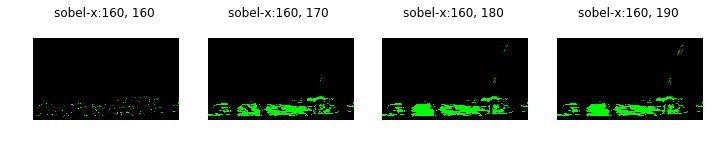

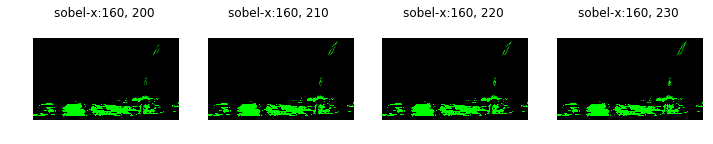

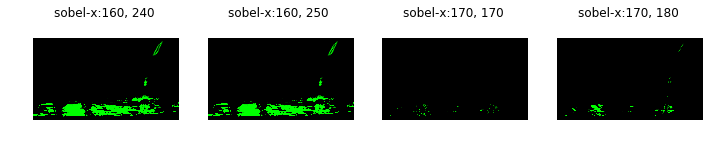

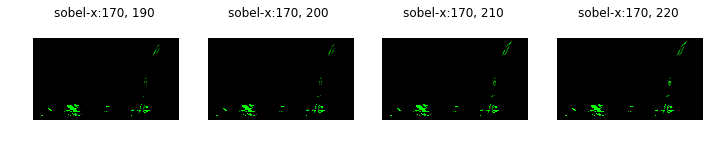

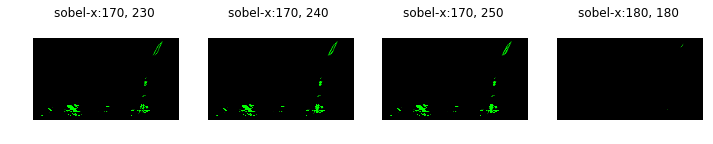

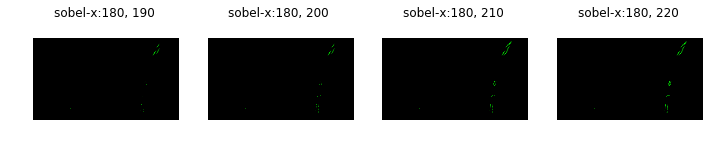

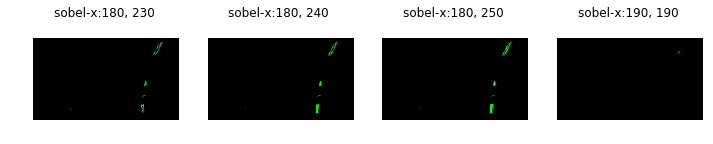

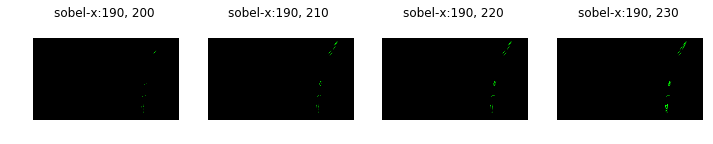

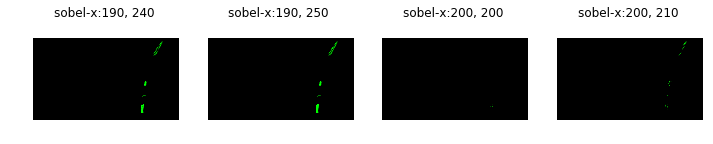

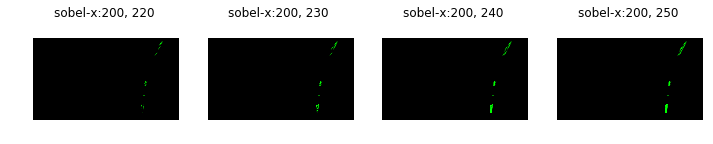

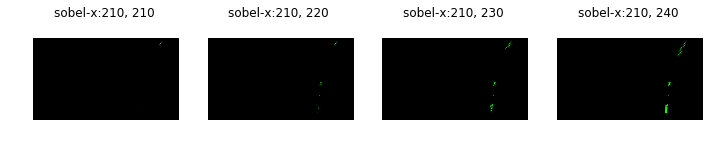

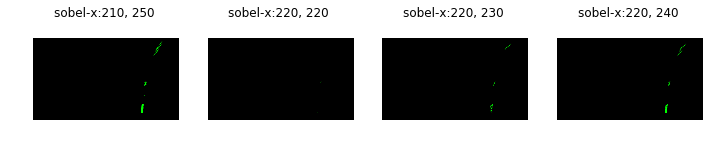

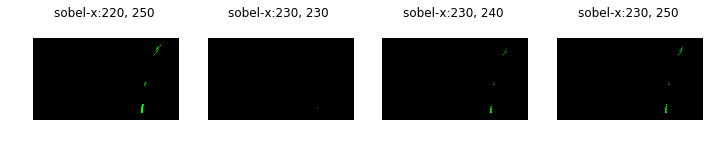

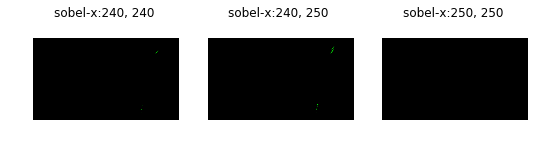

In [16]:
B = img[:,:,2]

printLotsOfThresholds(B, thresholds, 4,FIGSIZE = (12,12))

In [22]:
def unwarp(img):
    
    img2 = deepcopy(img)
    
    img_size = (img2.shape[1], img2.shape[0])
    
    corners = [[[595,450]],[[200,720]],[[1150,720]],[[695,450]]]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([[250,0], [250,700],[960,700], [960,0]])        
    M = cv2.getPerspectiveTransform(src,dst)
    
    unwarped = cv2.warpPerspective(img2, M, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped



def printLotsOfThresholds2(img_1, thresholds, number_of_columns,FIGSIZE = (12,12),xory='x'):
    
    fig = plt.figure(figsize=FIGSIZE)
    col = 0    
    
    for i,t in enumerate(thresholds):
        
        col += 1
        
        if col == number_of_columns + 1:
            fig = plt.figure(figsize=FIGSIZE)
            col = 1
        
        img_try = abs_sobel_thresh(img_1, xory, (t[0], t[1]))
        #img_try = channelImageMaker(img_1, t[0], t[1])
        img_try = unwarp(img_try)
        
        fig.add_subplot(1,number_of_columns,col)     
        plt.imshow(img_try,cmap='gray')
        plt.axis('off')
        title = "sobel-x:{0}, {1} \n".format(
        str(t[0]), str(t[1]) )        
        plt.title(title, wrap=True)

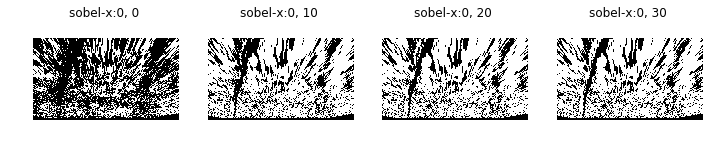

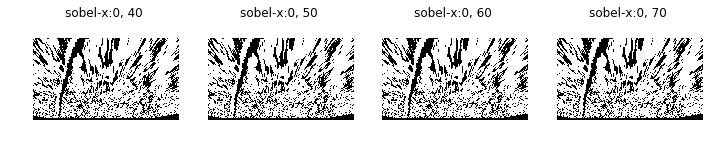

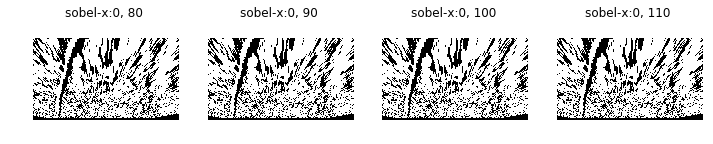

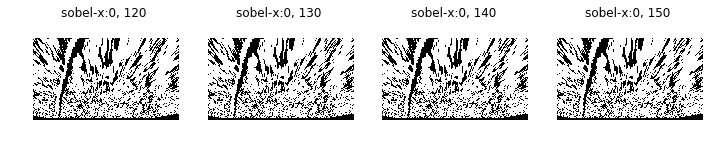

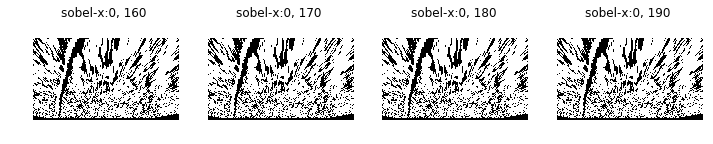

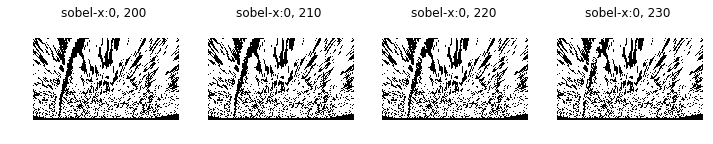

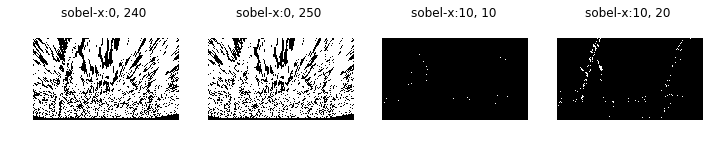

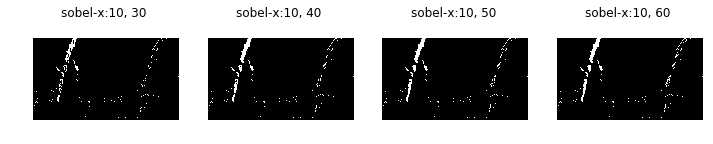

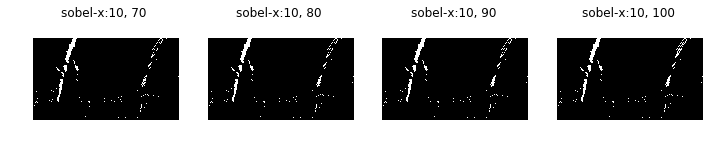

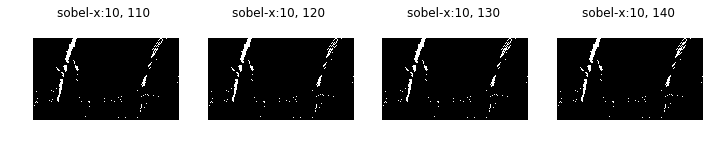

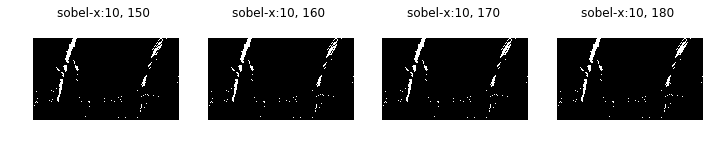

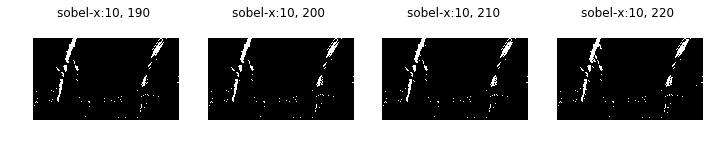

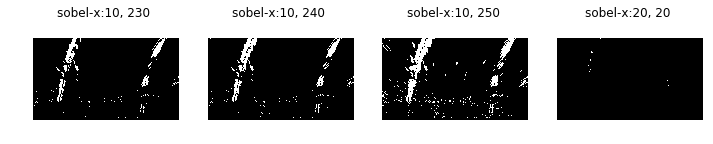

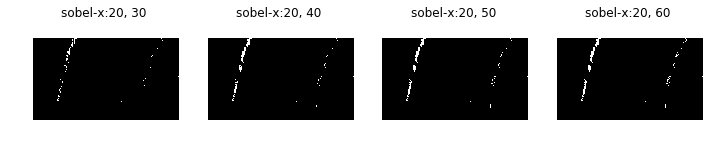

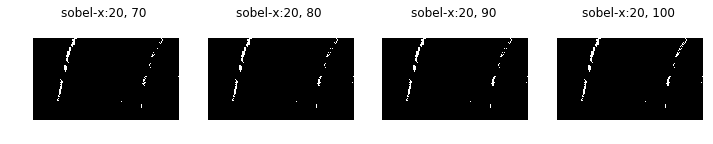

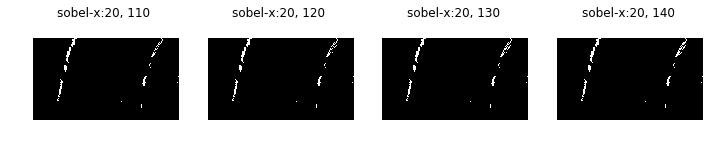

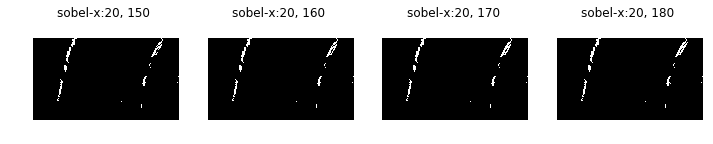

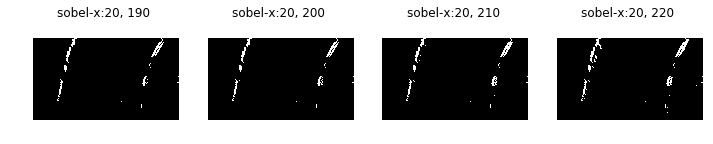

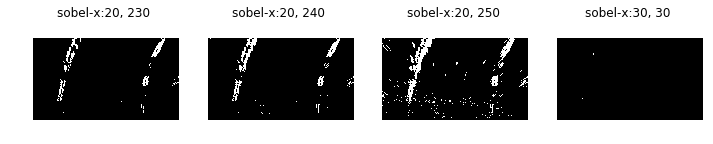

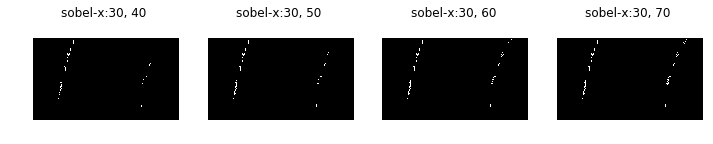

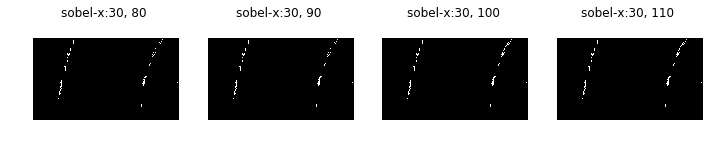

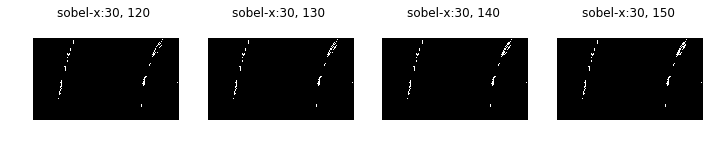

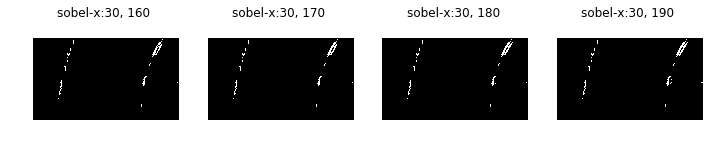

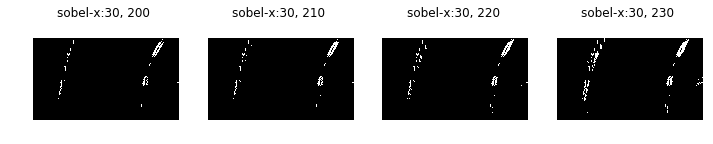

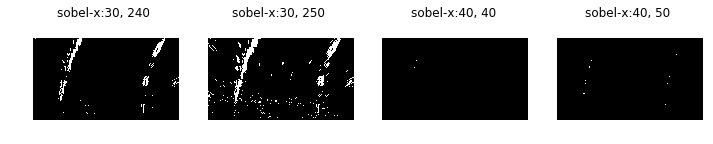

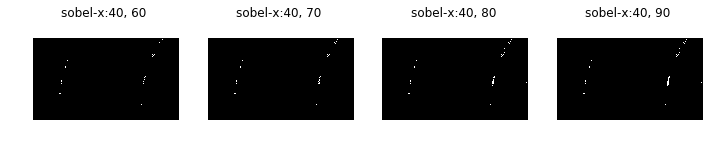

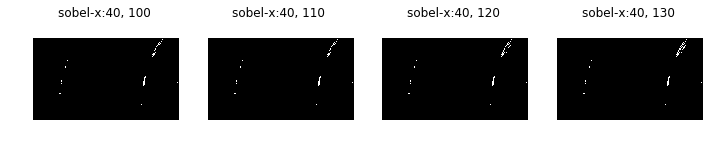

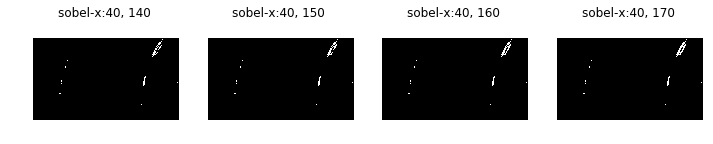

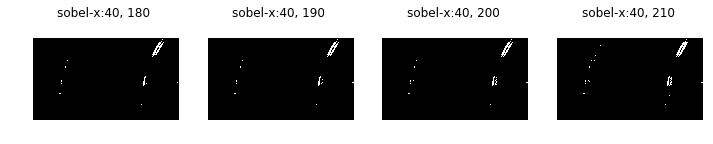

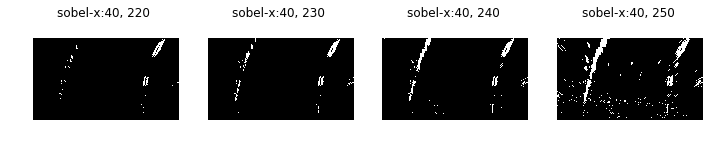

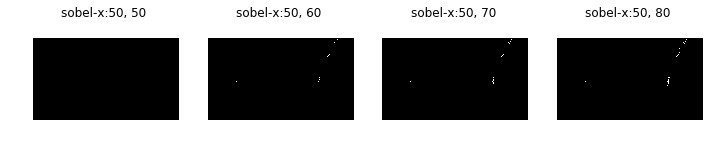

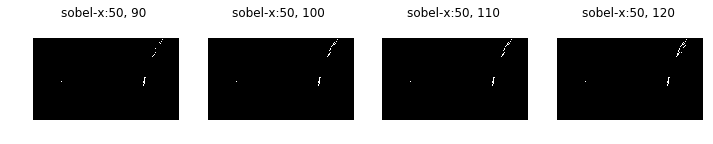

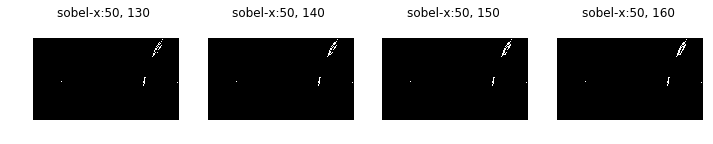

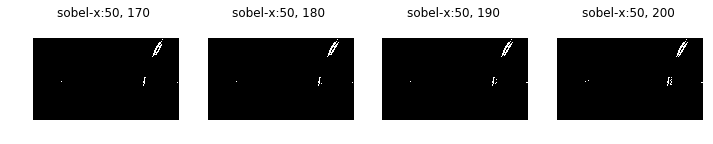

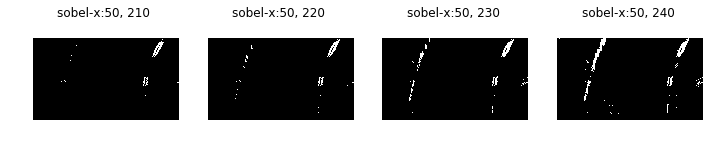

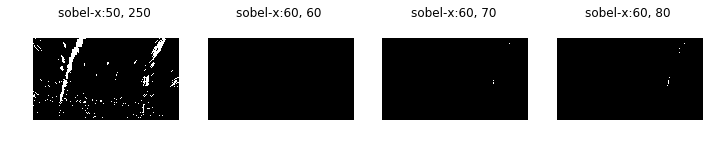

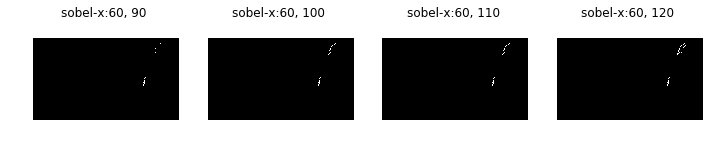

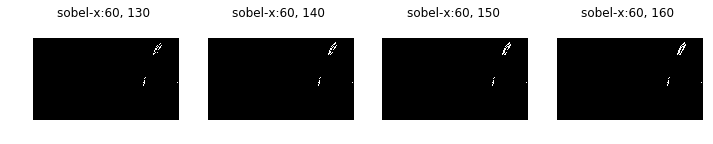

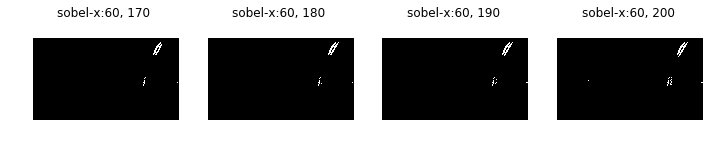

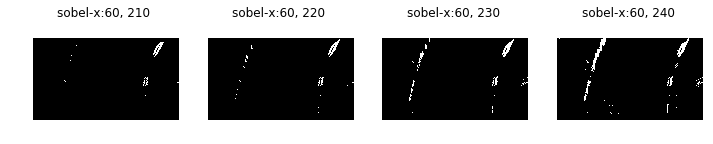

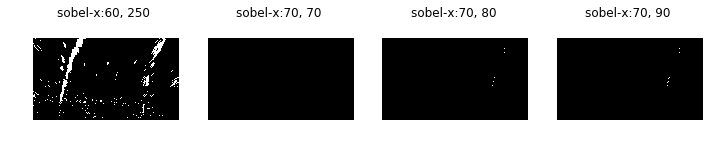

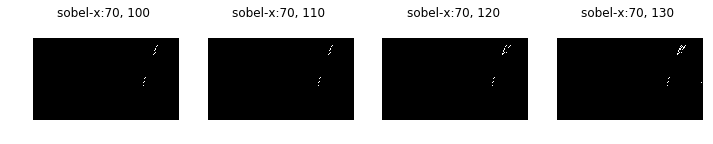

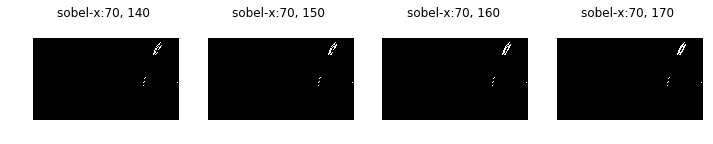

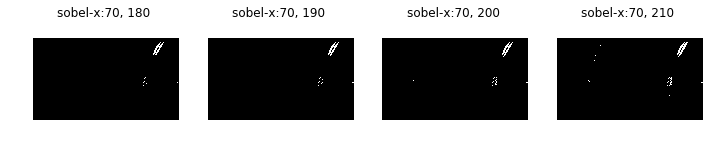

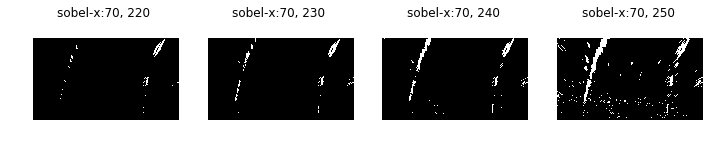

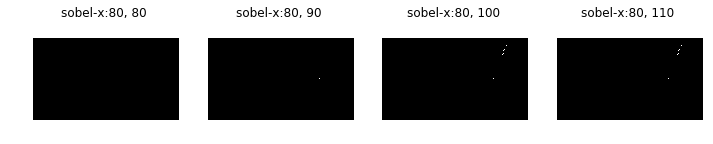

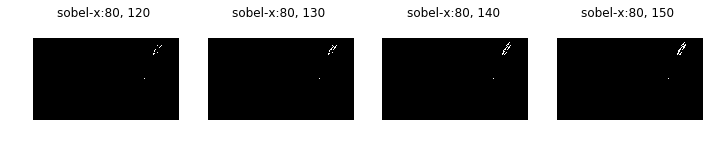

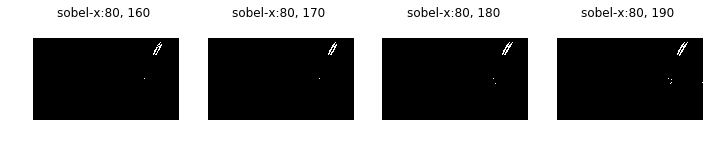

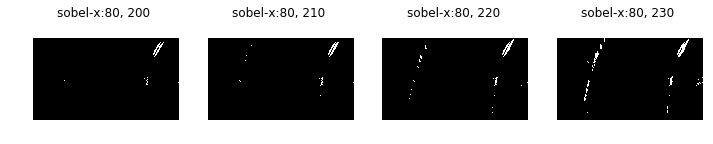

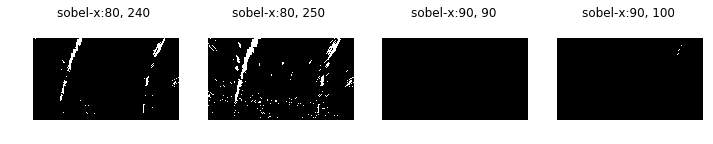

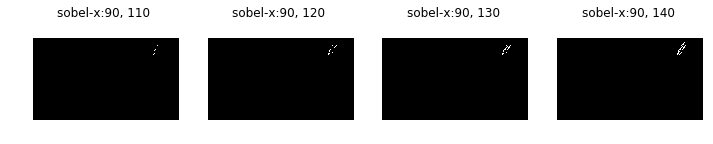

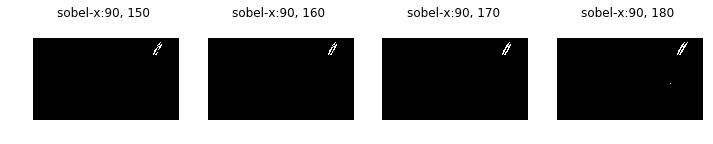

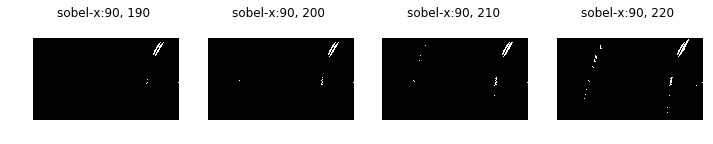

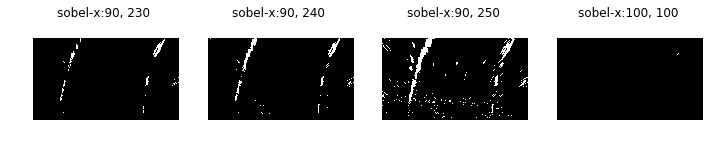

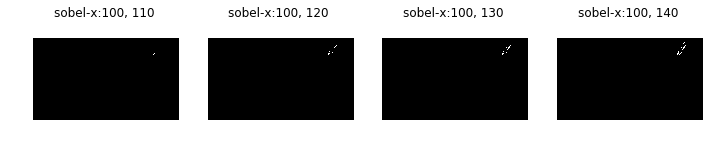

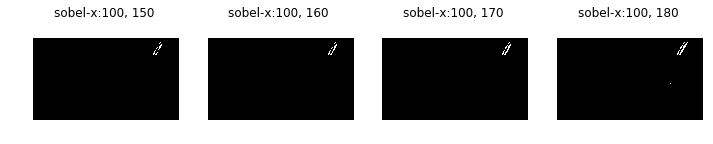

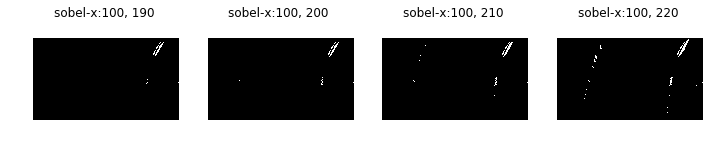

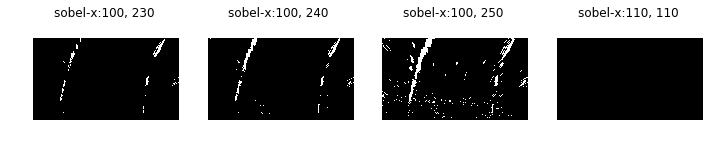

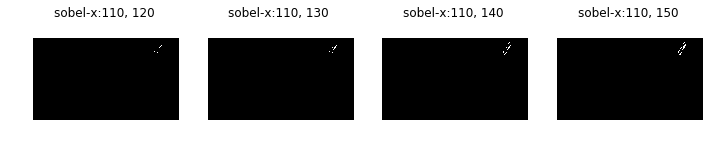

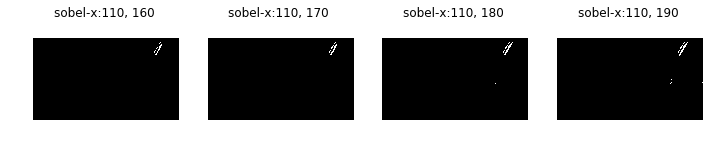

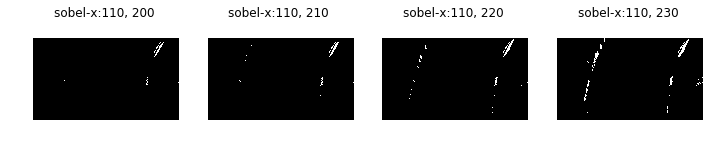

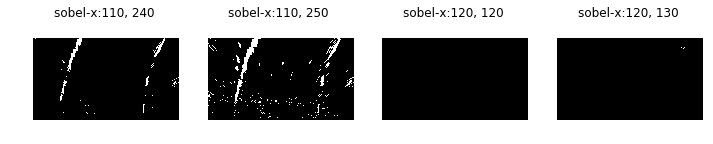

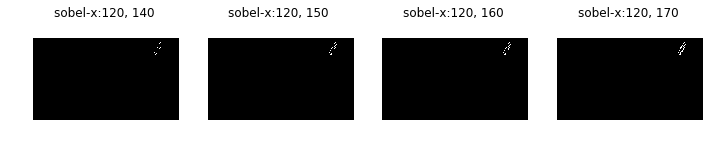

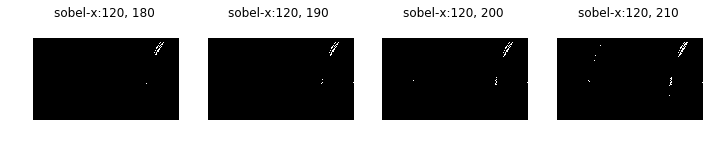

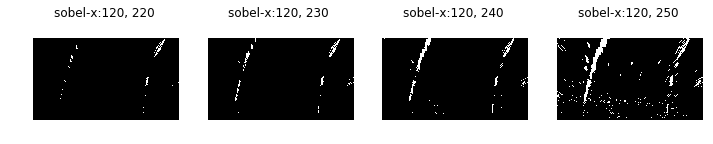

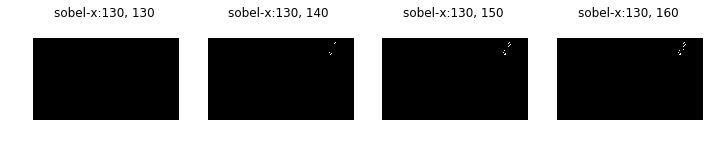

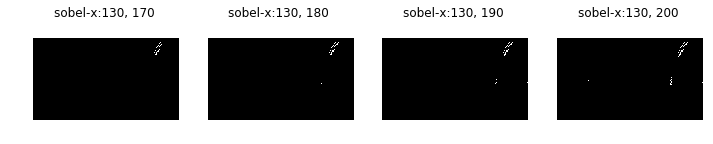

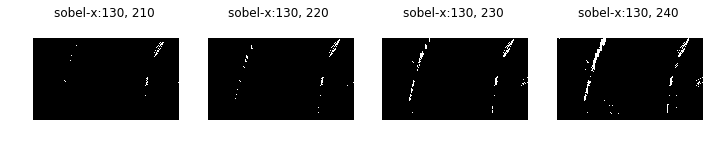

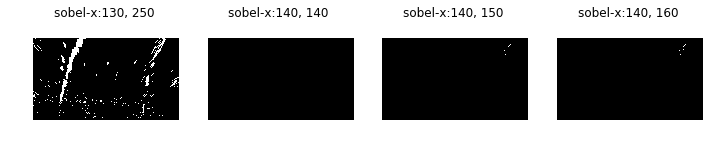

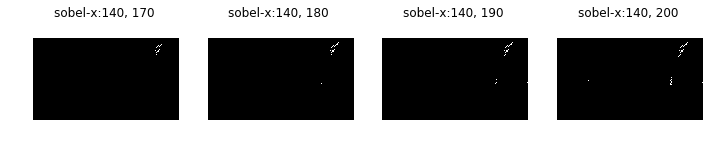

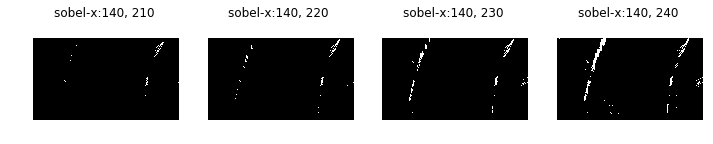

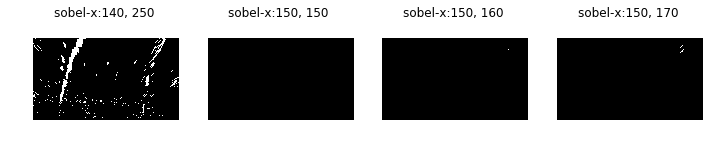

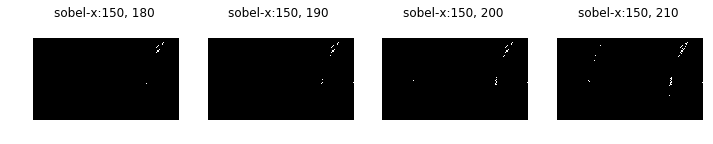

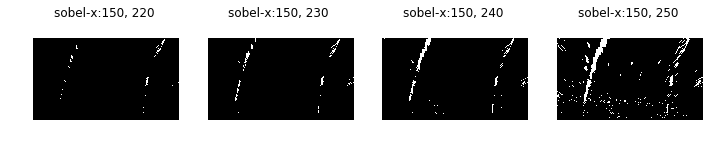

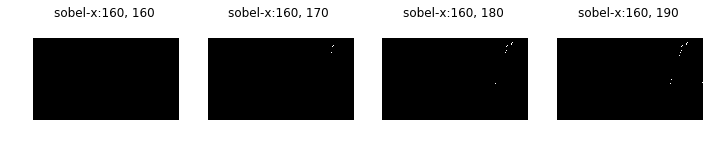

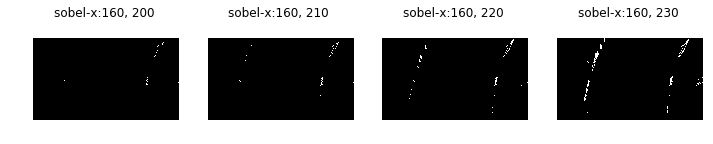

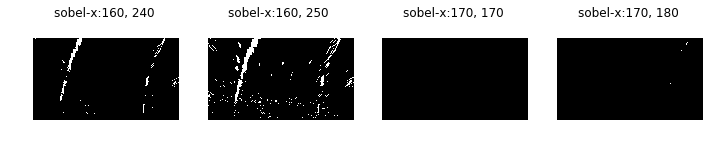

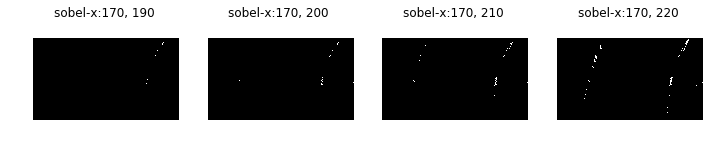

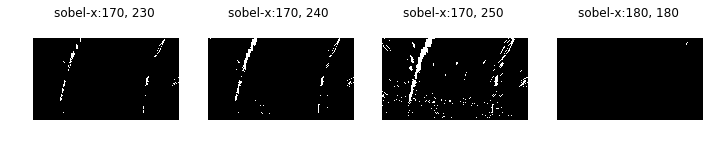

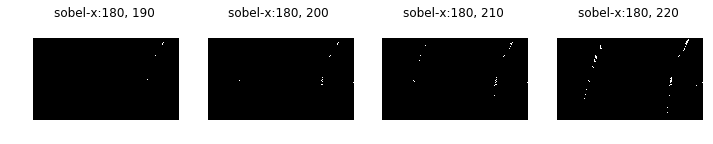

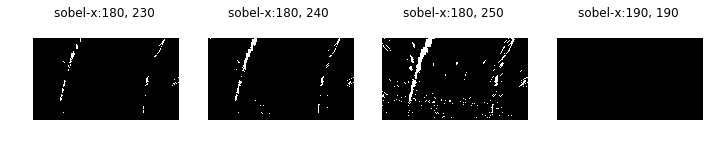

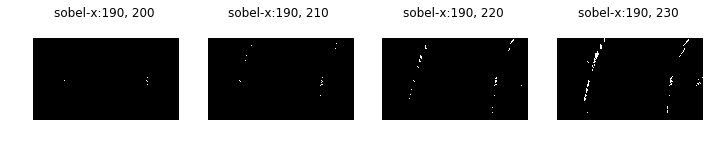

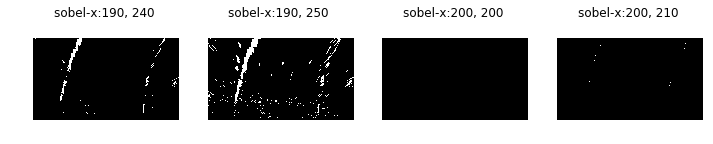

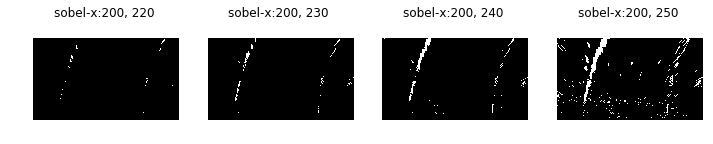

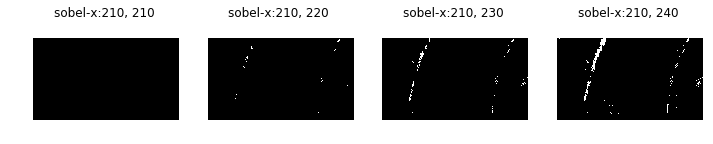

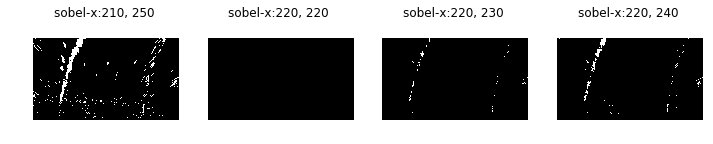

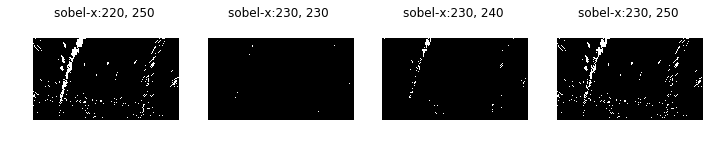

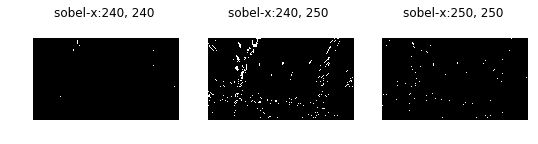

In [23]:
thresholds= []
for i in range(0,255,10):
    for j in range(0,255,10):
        if i>j:
            continue
        thresholds.append((i,j))
img  = mpimg.imread('./test_images/test5.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        
printLotsOfThresholds2(gray, thresholds, 4,(12,12),'x')

## Sobel-Y

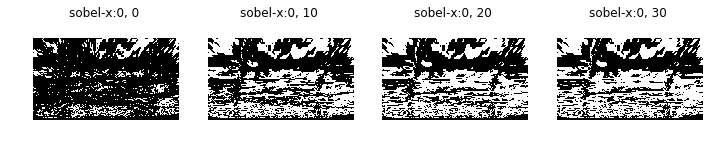

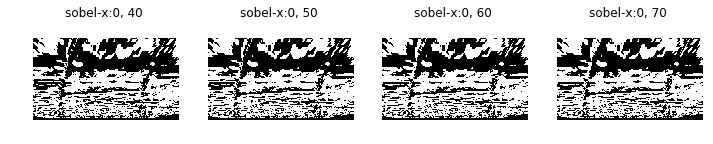

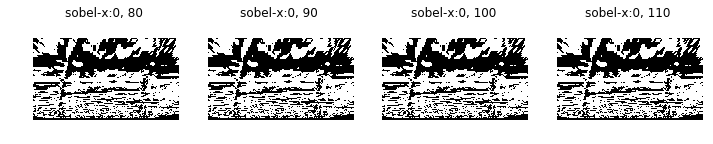

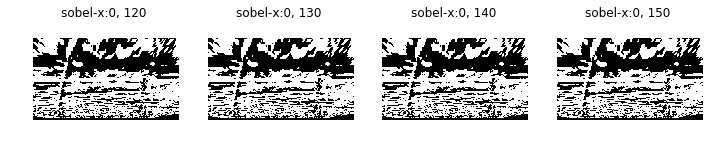

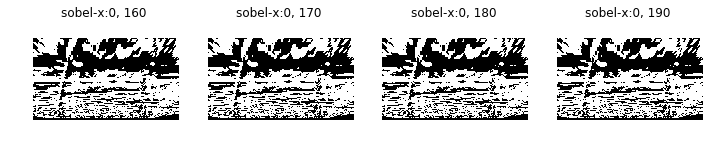

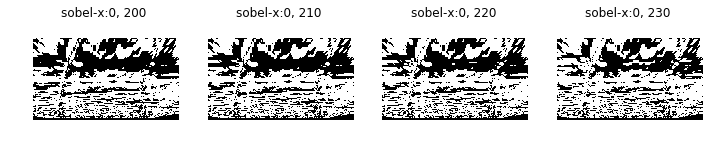

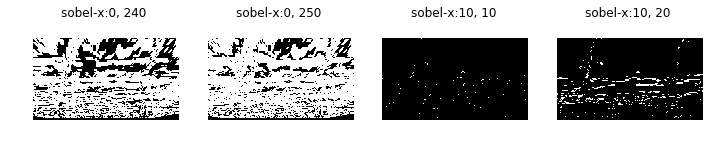

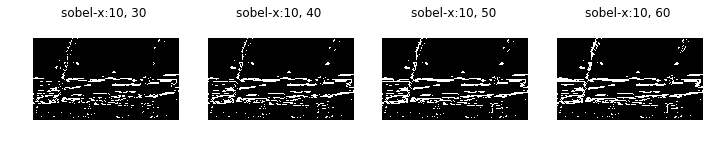

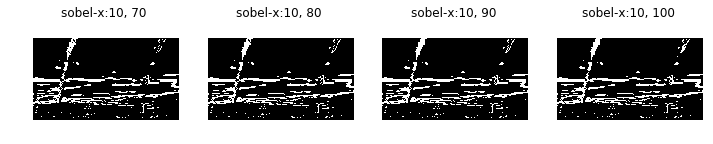

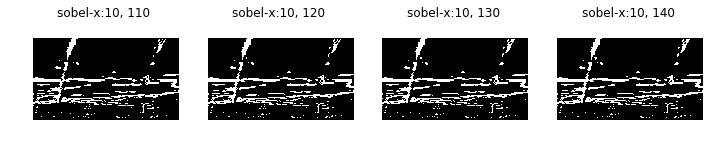

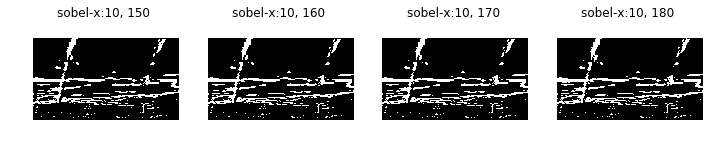

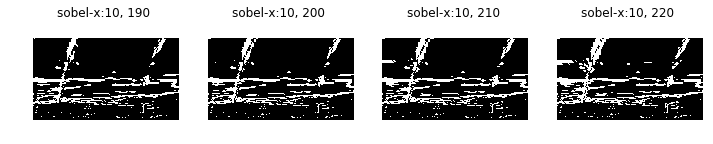

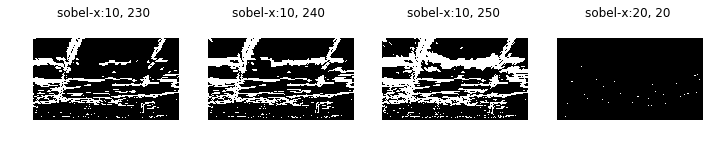

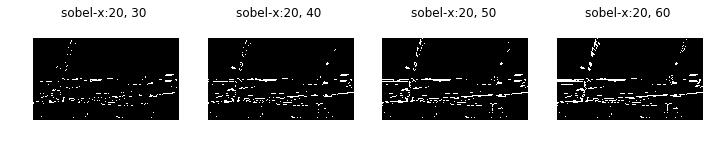

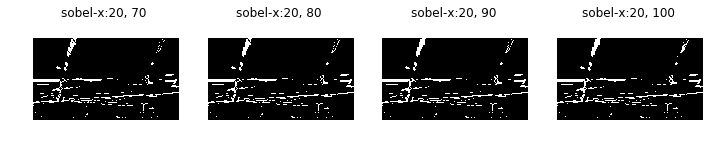

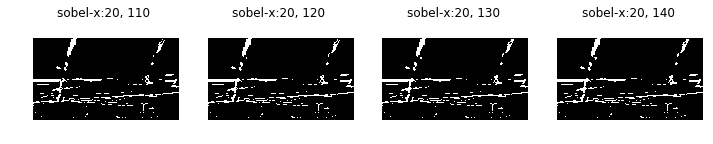

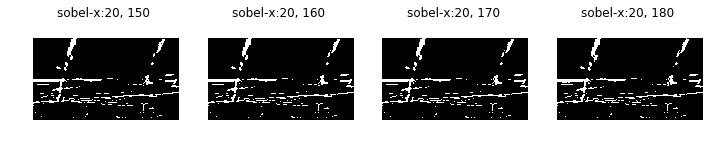

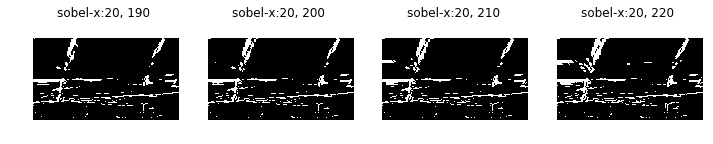

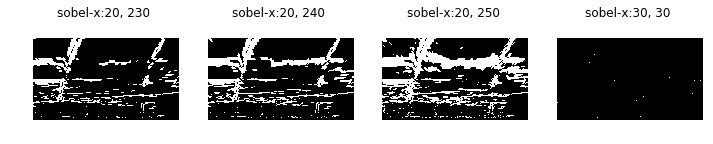

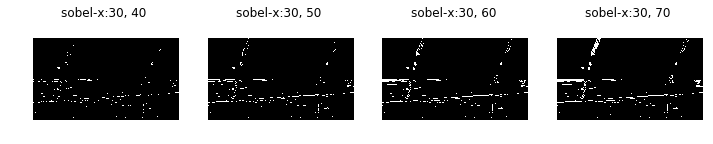

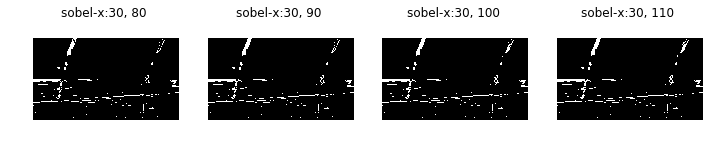

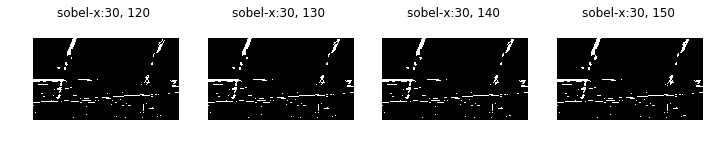

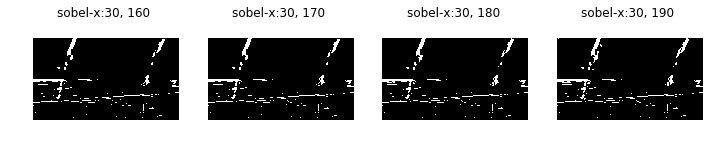

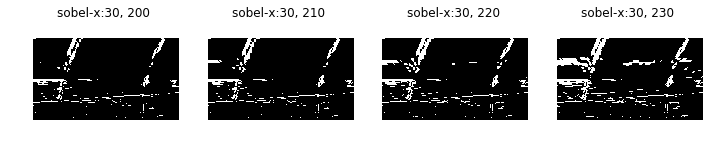

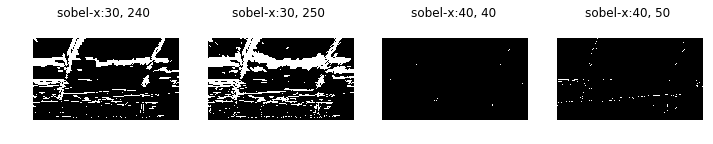

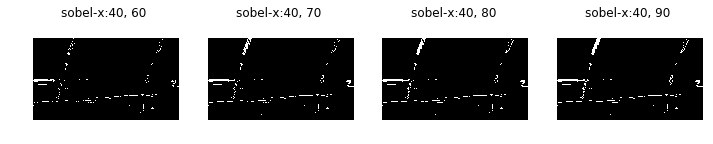

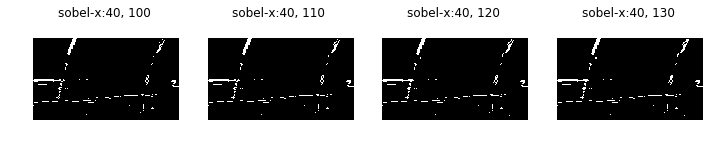

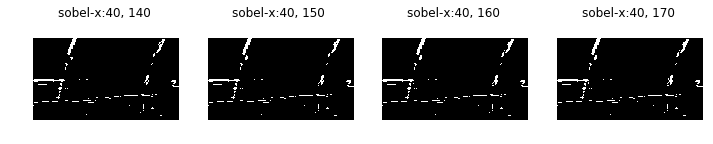

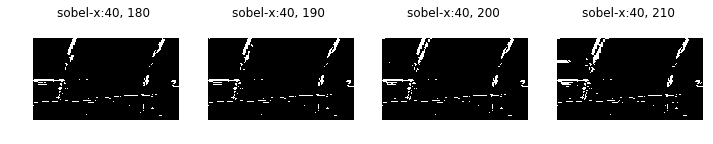

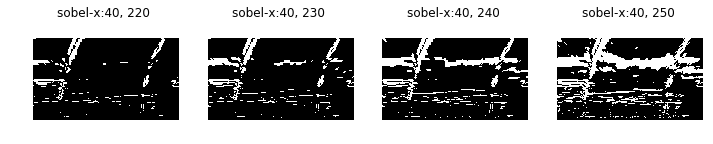

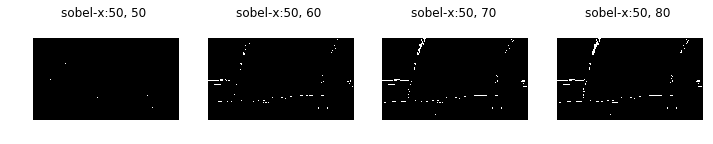

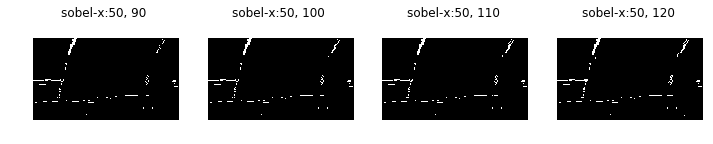

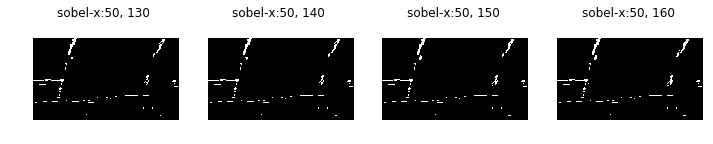

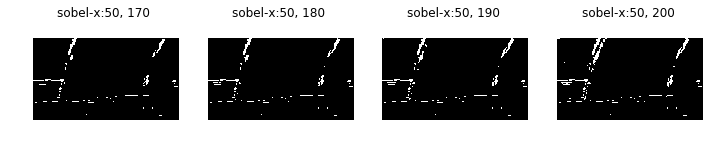

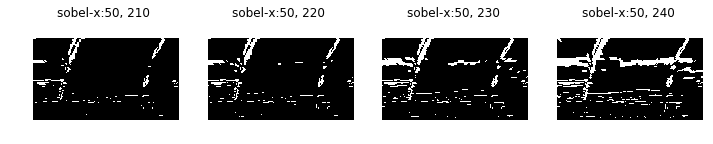

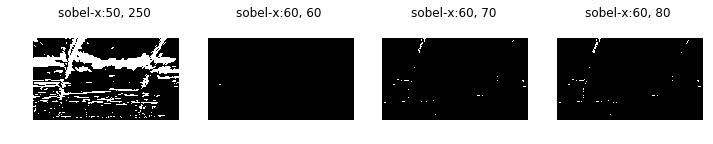

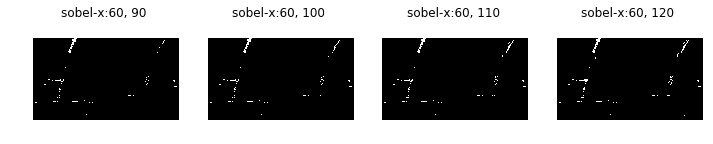

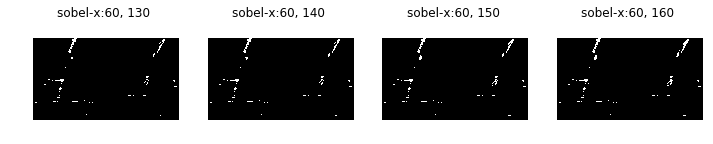

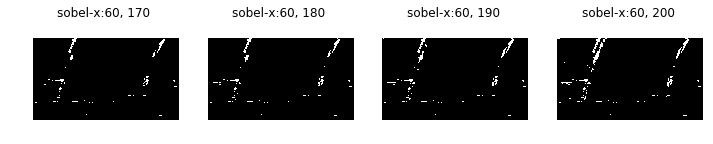

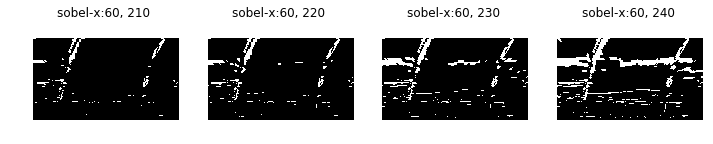

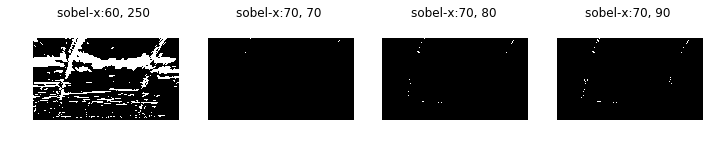

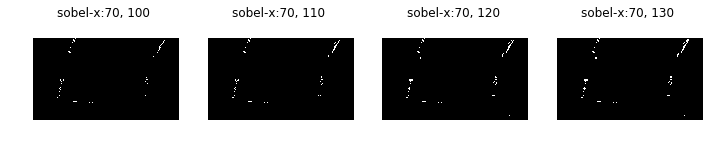

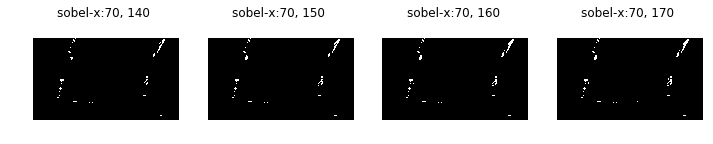

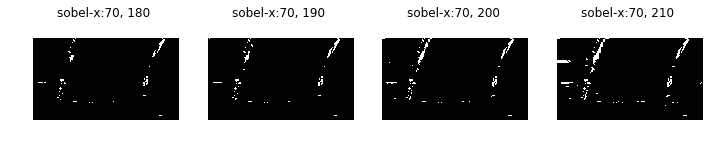

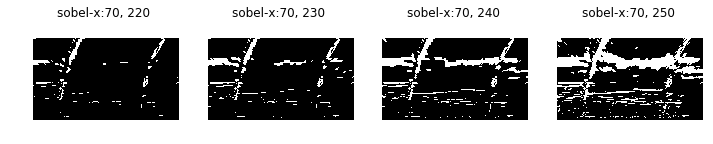

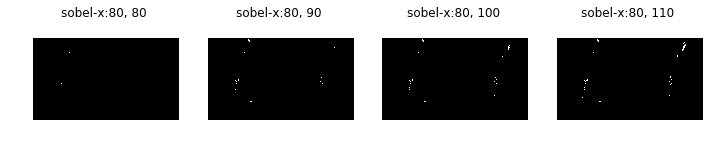

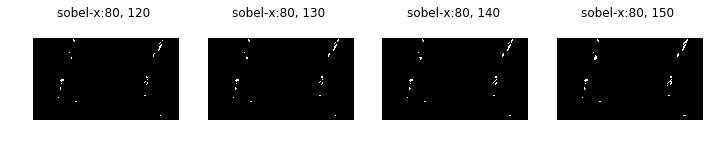

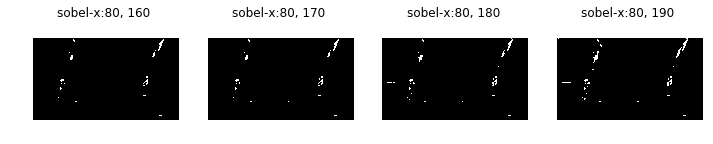

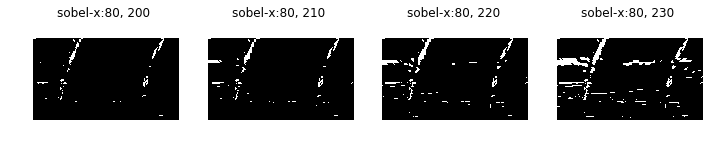

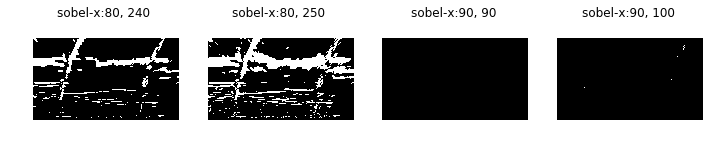

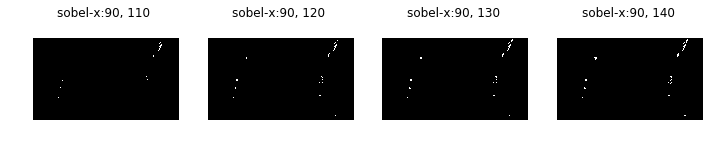

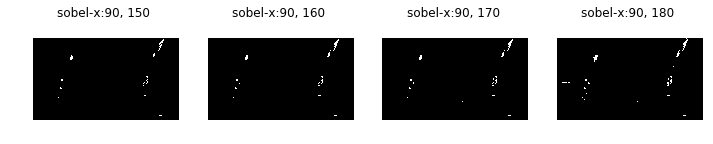

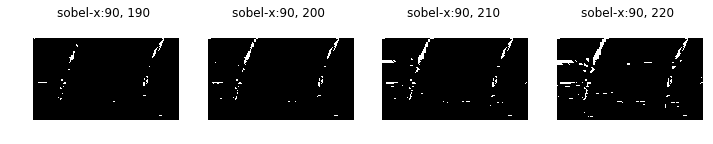

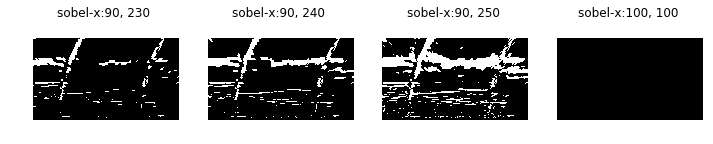

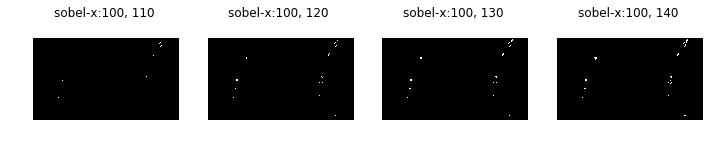

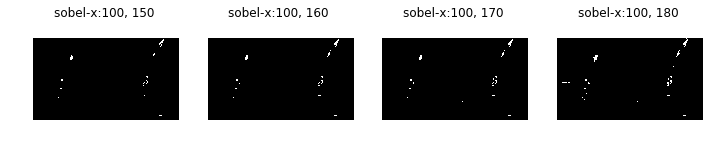

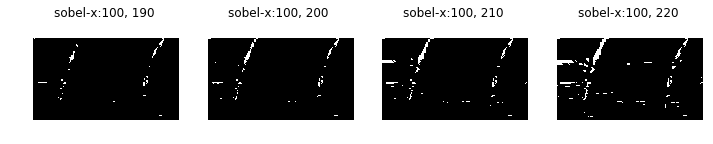

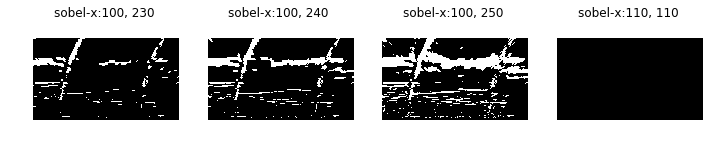

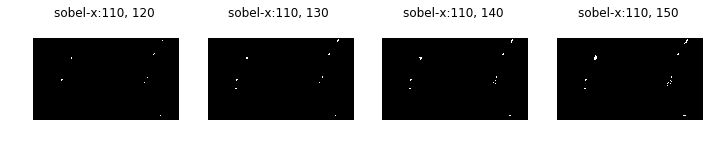

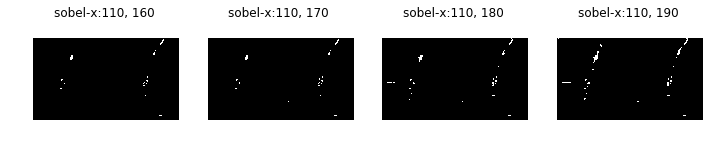

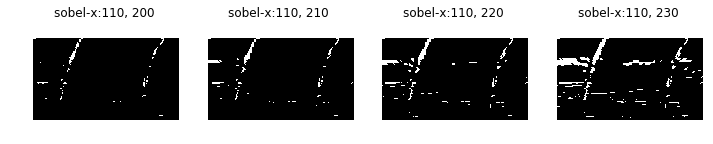

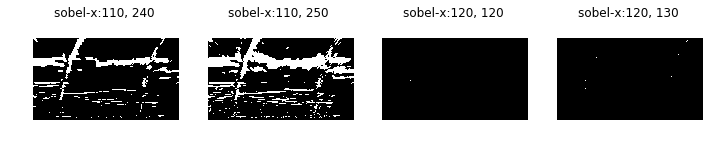

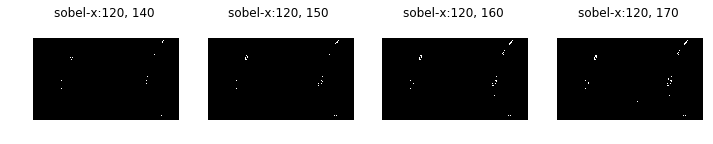

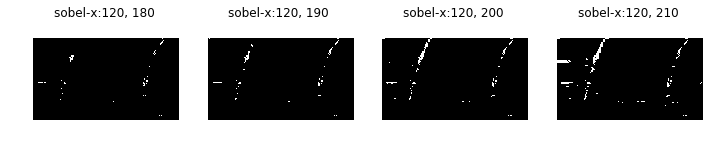

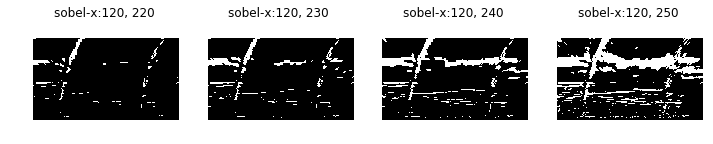

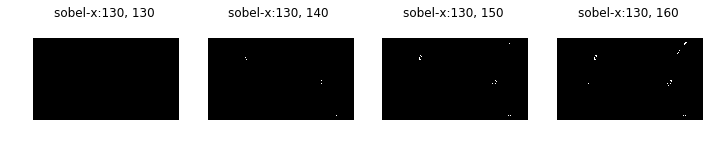

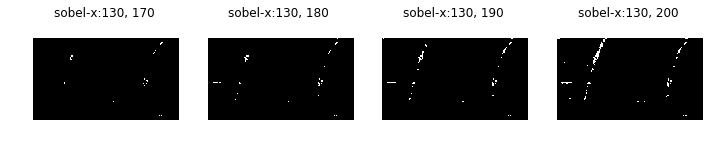

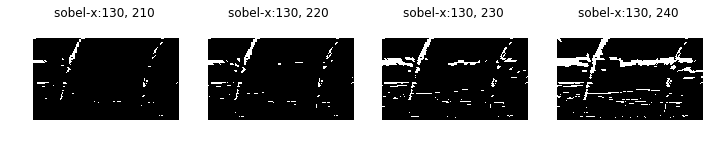

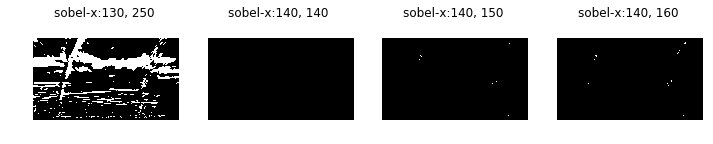

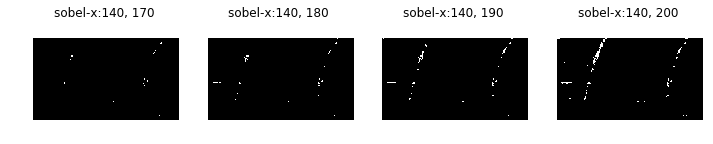

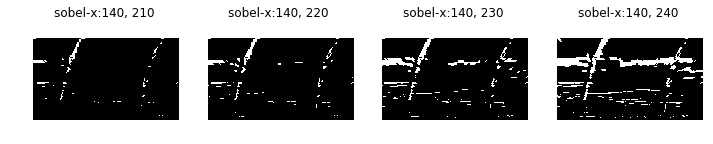

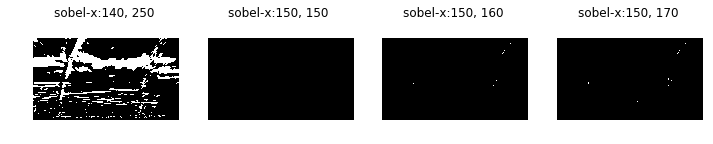

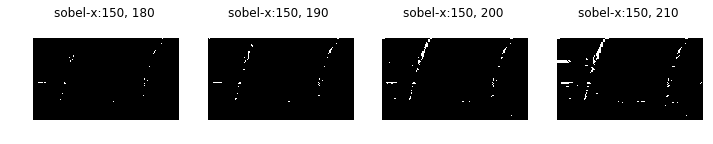

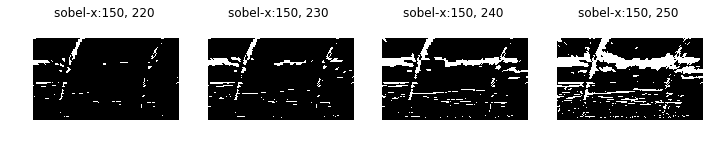

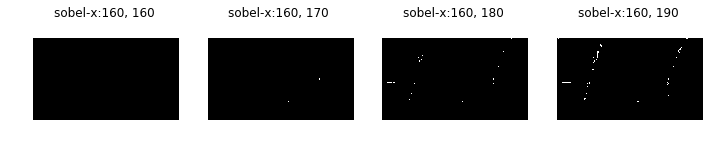

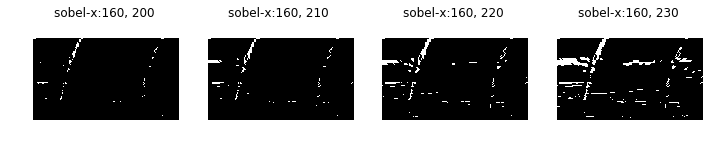

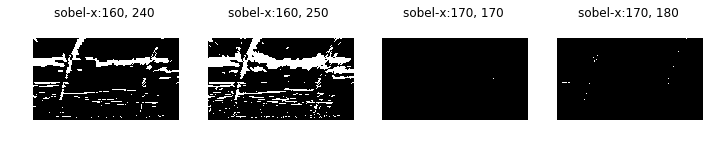

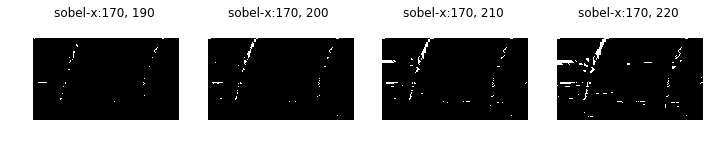

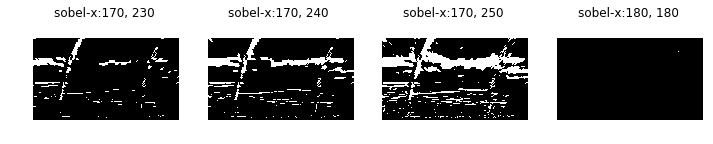

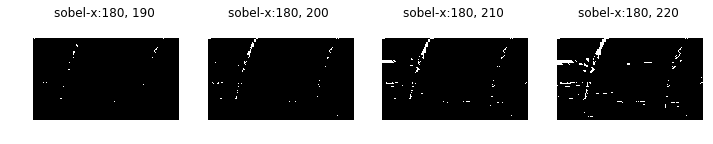

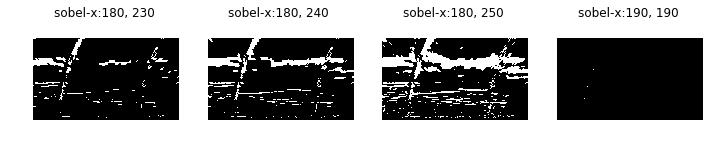

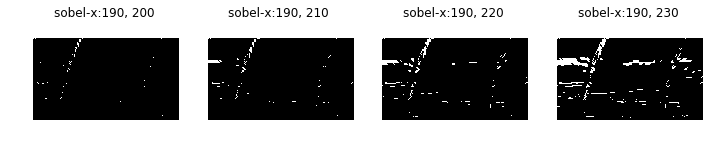

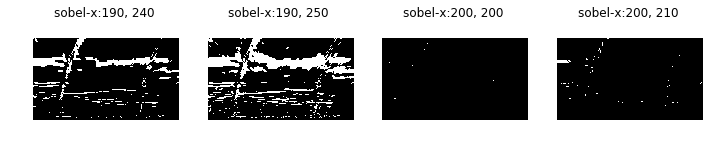

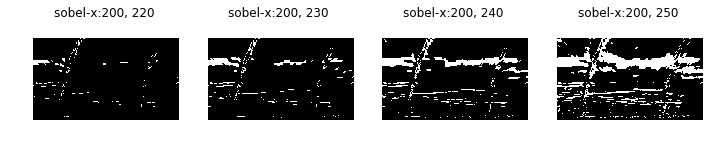

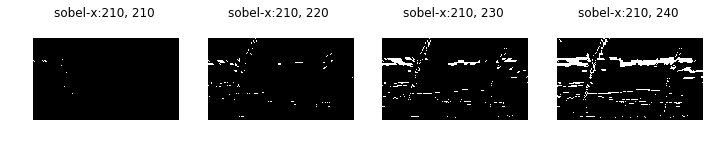

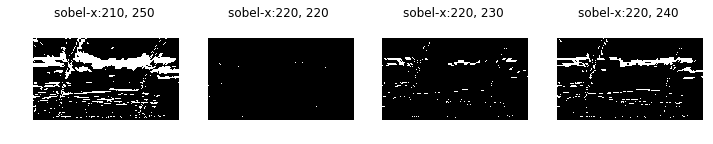

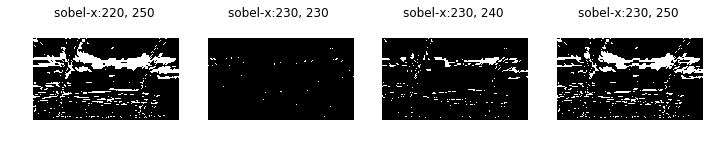

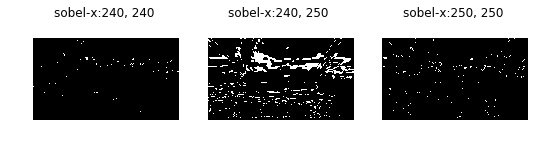

In [26]:
printLotsOfThresholds2(gray, thresholds, 4,(12,12),'y')

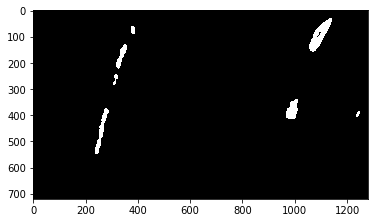

In [35]:
g2 = unwarp(gray)
g2 = abs_sobel_thresh(g2,'x',(40,240) )
cv2.fastNlMeansDenoising(g2,g2,3,7,21)
plt.imshow(g2,cmap='gray')

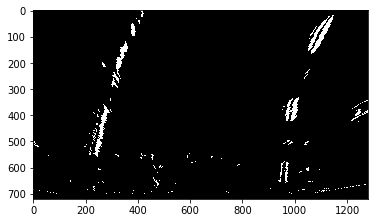

In [33]:
g2 = unwarp(gray)
g2 = abs_sobel_thresh(g2,'x',(40,240) )
cv2.fastNlMeansDenoising(g2,g2,3,7,21)
plt.imshow(g2,cmap='gray')